<a href="https://colab.research.google.com/github/ff1451/deep_learning/blob/main/homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")

print("BASE_PATH exists:", BASE_PATH.exists())
print("Has _01_code:", (BASE_PATH / "_01_code").exists())
print("Sample:", list((BASE_PATH).iterdir())[:5])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_PATH exists: True
Has _01_code: True
Sample: [PosixPath('/content/drive/MyDrive/Colab Notebooks/homework3.ipynb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/checkpoints'), PosixPath('/content/drive/MyDrive/Colab Notebooks/_01_code'), PosixPath('/content/drive/MyDrive/Colab Notebooks/_00_data'), PosixPath('/content/drive/MyDrive/Colab Notebooks/wandb')]


In [2]:
!pip -q install wandb
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ff1451 (ff1451-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# 문제 1

## 문제 1.1

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

# =========================
# 파일 경로 및 환경 설정
# =========================

# Google Colab에서 Google Drive를 마운트한 경로
# 수업 코드(_01_code)와 체크포인트 저장을 위한 기준 경로

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
import sys
# argparse 및 수업 코드 import를 위해 BASE_PATH를 Python path에 추가
sys.path.append(BASE_PATH)

# =========================
# 체크포인트 저장 경로
# =========================

# 학습된 모델 파라미터를 저장할 디렉토리
CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_regression_btc_krw"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# argparse 설정 (epochs, batch_size, learning_rate 등)
from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser

# 학습/검증/early stopping을 담당하는 Trainer 클래스
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer

# 암호화폐 시계열 데이터 로딩 및 Dataset 클래스
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset


# =========================
# 데이터 불러오기
# =========================

# BTC-KRW 시계열 데이터를 불러와 학습 / 검증 / 테스트 DataLoader를 생성하는 함수
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):

# 과거 sequence_size일 만큼의 시계열 데이터를 입력으로 사용
# target_column='Close' : 종가를 예측 대상으로 설정
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )


  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

# PyTorch Dataset 객체 생성
  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

# DataLoader를 통해 batch 단위로 데이터 로딩
  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


# =========================
# 모델 정의
# =========================
# LSTM 기반 회귀 모델 정의
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()


    # 2-layer LSTM
    # input_size = feature 수 (OHLCV → 5)
    # hidden_size = 128
      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)

    # 마지막 시점의 hidden state를 입력으로 받아
    # 최종 종가 예측값(1차원)을 출력

      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
    # x: (batch_size, sequence_length, feature_dim)
      x, hidden = self.lstm(x)

    # 마지막 시점의 hidden state만 사용
      x = x[:, -1, :]  # x.shape: [32, 128]

    # Fully Connected Layer를 통해 회귀값 출력
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


# =========================
# 학습 파이프라인
# =========================
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  # 데이터 로딩
  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  # 모델 생성 및 디바이스 이동
  model = get_model()
  model.to(device)

  # Adam Optimizer 사용
  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  # Trainer를 통해 학습/검증/early stopping 수행
  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=["--wandb"])
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 24.64513, V_loss: 243.53621, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 18.79394, V_loss: 186.92732, V_loss decreased (243.53621 --> 186.92732). Saving model... | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 5.83356, V_loss: 99.01542, V_loss decreased (186.92732 --> 99.01542). Saving model... | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 4.22480, V_loss: 79.54805, V_loss decreased (99.01542 --> 79.54805). Saving model... | T_time: 00:00:06, T_speed: 15.000
[Epoch 120] T_loss: 3.25766, V_loss: 65.65942, V_loss decreased (79.54805 --> 65.65942). Saving model... 

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training loss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁███████████████████████████████████████
Validation loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3600
Training loss,0.01679
Training speed (epochs/sec.),14.34263
Validation loss,0.26993


## 결과 설명
본 실험은 BTC-KRW 시계열 데이터의 과거 sequence_size=10 구간(OHLCV 5개 feature)을 입력으로 받아, 다음 시점의 종가(Close)를 회귀(regression) 방식으로 예측하도록 2-layer LSTM(hidden_size=128) + Linear(128→1) 모델을 학습하였다. 데이터는 학습/검증/테스트로 분리되며, 학습 과정은 RegressionTrainer를 통해 일정 간격(validation_intervals=30)마다 검증 손실을 측정하고, 개선이 없을 경우 early_stop_patience=30 기준으로 조기 종료하도록 구성하였다.

실험 하이퍼파라미터는 다음과 같다.

- Batch size: 2048

- Epochs (max): 10000 (단, early stopping으로 조기 종료)

- Learning rate: 1e-4

- Weight decay: 0.0

- Validation intervals: 30 epochs

- Early stopping: patience 30, delta 1e-6

- Device: cuda:0

학습 로그를 보면, 초기에는 훈련 손실(Training loss)과 검증 손실(Validation loss)이 모두 매우 큰 값에서 시작했으나, epoch가 증가함에 따라 두 손실이 안정적으로 감소하였다. 예를 들어 검증 손실은 약 243.54(1 epoch 시점 측정 기준)에서 시작해, 지속적으로 감소하며 최저 수준으로 내려갔다. 훈련 손실 또한 꾸준히 감소하여 최종적으로 0.01679 수준까지 낮아졌다. Wandb run summary 기준으로, 학습은 Epoch 3600에서 종료되었으며 이때의 지표는 다음과 같다.

- Training loss: 0.01679

- Validation loss: 0.26993

- Training speed: 약 14.34 epochs/sec

또한 학습 과정에서 “V_loss decreased … Saving model…” 메시지가 반복적으로 출력된 것으로 보아, 검증 손실이 개선될 때마다 체크포인트가 저장되었다. 마지막 구간에서는 검증 손실이 더 이상 유의미하게 감소하지 않아 early stopping 카운터가 누적되었고, 최종적으로 patience를 채워 3600 epoch에서 학습이 조기 종료되었다. 이는 학습을 무작정 최대 epoch(10000)까지 진행하기보다, 검증 성능 개선이 멈춘 시점에서 학습을 종료하여 과적합 위험과 불필요한 연산을 줄인 결과로 해석할 수 있다.

## 기술적 고찰

### 1. LSTM 구조 선택의 타당성

시계열 예측은 한 시점의 값만 보고 다음 값을 맞히기 어렵습니다. 보통은 **이전 구간의 흐름(추세, 변동성, 패턴)**을 함께 봐야 하므로, 과거 정보를 내부 상태로 누적해 활용하는 **RNN 계열 모델**이 적합합니다.
이번 모델은 그중에서도 **LSTM**을 사용했는데, LSTM은 단순 RNN에서 자주 발생하는 **기울기 소실/폭주 문제**를 완화하여 비교적 긴 구간의 의존성을 더 안정적으로 학습할 수 있습니다. 또한 `x[:, -1, :]`처럼 **마지막 시점의 hidden state만** 꺼내 예측에 사용함으로써, “최근 10개 시점(sequence_size=10)의 정보를 요약한 표현”을 기반으로 다음 종가를 회귀 방식으로 출력하도록 구성했습니다.


---


### 2. 손실 감소 패턴과 일반화 관점

학습 로그를 보면 **훈련 손실은 꾸준히 감소**하는 반면, **검증 손실은 감소하다가 특정 구간부터 작은 진동**을 보입니다. 최종적으로 훈련 손실(0.01679)과 검증 손실(0.26993) 사이에 차이가 남아 있는데, 이는 일반적으로 다음 상황과 연결해서 해석할 수 있습니다.

* 훈련 데이터에는 점점 더 잘 맞추게 되지만(훈련 손실 감소)
* 검증 데이터에서는 성능 개선이 점점 제한되고(검증 손실 정체/진동)
* 그 결과 **과적합이 시작되는 구간이 존재**할 수 있음

이때 early stopping은 검증 손실 개선이 멈추는 시점에 학습을 종료시켜, 최대 epoch까지 계속 학습했을 때 생길 수 있는 과적합 심화를 줄이는 역할을 합니다. 실제로 최대 epoch는 10000으로 설정되어 있었지만, 학습은 **3600 epoch에서 조기 종료**되었습니다. 이는 “반복 횟수를 채우는 것보다 검증 성능의 개선 여부를 기준으로 학습을 멈추는 전략”이 실험에서 효과적으로 동작했음을 보여줍니다.


---


### 3. 배치 크기(2048)와 수렴 특성

배치 크기 2048은 꽤 큰 편이며, 일반적으로 다음 성향이 있습니다.

* **장점:** gradient 추정이 안정적이어서 손실 곡선이 비교적 매끄럽게 내려가는 경향
* **단점:** 업데이트 횟수가 상대적으로 줄어들어, 미세한 최적화나 일반화 측면에서 불리할 수 있음

이번 실험에서는 손실이 초기에는 크게 떨어지고 이후 완만해지는 전형적인 수렴 형태를 보였고, GPU 환경에서 학습 속도도 약 14 epochs/sec로 안정적이었습니다. 다만 성능을 더 끌어올리고 싶다면, 배치 크기를 줄이고(예: 256~1024) learning rate나 weight decay를 함께 조정해보는 것이 합리적인 다음 실험 방향입니다.


---


### 4. 검증 간격(30)과 early stopping의 상호작용

이번 설정에서 검증은 `validation_intervals=30`이므로 **30 epoch마다 한 번** 수행됩니다. early stopping의 `patience=30`은 “검증 손실이 개선되지 않는 검증 측정이 30번 누적되면 종료”를 의미하므로, 이 둘이 결합되면 학습 종료 판단이 비교적 느리게(보수적으로) 이루어질 수 있습니다.

하지만 로그에서는 검증 손실이 개선될 때마다 “Saving model…”로 갱신되면서 카운터가 초기화되었고, 마지막 구간에서만 개선이 멈추며 카운터가 누적되어 최종 종료되었습니다. 즉, 이 설정은 **충분히 학습을 시도하되, 개선이 명확히 멈추면 종료한다**는 목적에 맞게 동작했다고 볼 수 있습니다.


## 문제 1.2

MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_regression_btc_krw/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,338.46 <--> 1,326.70 (Loss:         11.77)
 1: 1,351.36 <--> 1,333.37 (Loss:         17.99)
 2: 1,373.56 <--> 1,250.60 (Loss:        122.96)
 3: 1,314.08 <--> 1,302.84 (Loss:         11.24)
 4: 1,331.76 <--> 1,280.45 (Loss:         51.31)
 5: 1,339.60 <--> 1,244.10 (Loss:         95.49)
 6: 1,354.61 <--> 1,334.36 (Loss:         20.25)
 7: 1,344.57 <--> 1,332.08 (Loss:         12.48)
 8: 1,313.76 <--> 1,275.80 (Loss:         37.96)
 9: 1,352.90 <--> 1,334.95 (Loss:         17.94)


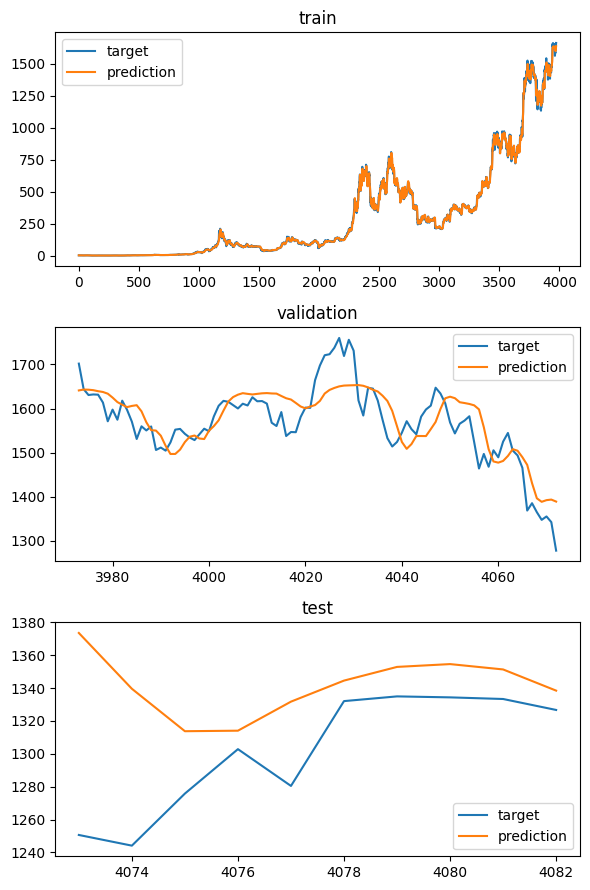

In [4]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
import sys

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")

sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_regression_btc_krw"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._18_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


# =========================
# test 데이터 10개 샘플에 대한 수치 출력 함수
# =========================
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  # 평가모드
  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  # 평가 시에는 역전파/그래프 필요 없으므로 no_grad() 사용
  with torch.no_grad():
    # batch_size가 test set 전체 길이로 잡혀서 보통 1회 돌음
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      # 모델 예측 수행
      output_test = test_model(input_test)

    # 예측값, 정답, 절대 오차를 샘플별로 출력
    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


# =========================
# 5) train/val/test 전체 구간에 대해 “그래프 비교” 함수
# =========================
def predict_all(test_model):
  y_normalizer = 100

  # train/val/test 데이터를 한 번에 모두 가져옴
  # sequence_size=10: 과거 10시점을 입력으로 다음 종가를 예측
  # validation_size=100, test_size=10: 검증 100개, 테스트 10개
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )


  # Dataset으로 감싸서 (input, target) 형태로 순회 가능하게 만듦
  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  # 3개의 subplot: train / validation / test 각각 비교 그래프
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target =

      #    모델 입력은 (batch, seq, feature) 형태여야 하므로 batch 차원 추가
      #    출력은 (1,1) 형태라서 squeeze로 스칼라로 변환
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    # 실제값(target)과 예측값(prediction)을 같은 축에 그려서 차이를 시각적으로 확인
    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


# =========================
# 6) 전체 실행 흐름: wandb 설정 → 모델 로드 → test 출력 → 그래프 출력
# =========================
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  # 학습에서 저장한 최신 체크포인트 파일 로드
  latest_file_path = CHECKPOINT_FILE_PATH / f"{project_name}_checkpoint_latest.pt"
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=[])
  main(args)


## 결과 설명
### 1. 학습(train) 구간 결과

학습 구간 그래프를 보면, 실제 종가(target)와 모델의 예측값(prediction)이 거의 겹치듯이 움직이는 모습을 확인할 수 있다. 전반적인 상승 추세와 중간중간의 급등·조정 구간까지 비교적 잘 따라가고 있으며, 이는 LSTM 모델이 과거 10개 시점(sequence_size=10)에 포함된 가격 흐름 정보를 효과적으로 학습했음을 의미한다.

특히 장기적인 추세뿐만 아니라, 단기적인 변동 패턴도 큰 오차 없이 추종하고 있어 학습 데이터에 대해서는 충분한 표현력을 가진 모델임을 확인할 수 있다. 이는 앞선 학습 단계에서 훈련 손실이 안정적으로 감소한 결과와도 일관된다.

### 2. 검증(validation) 구간 결과

검증 구간에서는 예측값이 실제값의 전체적인 흐름과 방향성은 잘 따라가지만, 변동 폭이 상대적으로 완만해지는 경향이 나타난다. 실제 가격이 급격히 상승하거나 하락하는 구간에서는 예측 곡선이 다소 부드럽게 움직이며, 극값(피크/바닥)을 정확히 맞추기보다는 평균적인 추세를 따르는 모습이다.

이는 학습 데이터에 비해 보지 못한 구간(validation)에 대해서는 모델이 보수적인 예측을 수행하고 있음을 보여준다. 다시 말해, 과도한 과적합 없이 일반화 성능을 어느 정도 유지하고 있으나, 급격한 단기 변동까지 완벽히 반영하기에는 한계가 있음을 시사한다.

### 3. 테스트(test) 구간 결과

테스트 데이터 10개 샘플에 대한 수치 출력 결과를 보면, 대부분의 샘플에서 예측값과 실제값의 차이가 수십 단위 이내로 유지되고 있다. 일부 시점(예: 2번, 5번 샘플)에서는 실제 가격의 급격한 하락을 충분히 반영하지 못해 상대적으로 큰 오차가 발생했지만, 전반적으로는 가격 수준 자체를 크게 벗어나지는 않는다.

그래프에서도 확인할 수 있듯이, 예측값은 실제값보다 변동성이 낮고 완만한 곡선을 그리는 경향을 보인다. 이는 모델이 “다음 시점의 평균적인 가격 수준”을 예측하는 데에는 비교적 성공적이지만, 단기 급변 구간에서는 보수적으로 반응하고 있음을 의미한다.

## 기술적 고찰

### 1. 예측 곡선이 부드럽게 나타나는 이유

본 모델은 과거 10개 시점의 정보를 입력으로 받아 LSTM의 hidden state에 이를 요약한 뒤, 마지막 시점의 hidden state만을 사용하여 종가를 회귀 예측한다. 이 구조는 시계열의 전반적인 추세를 포착하는 데에는 강점이 있지만, 단일 시점에서 발생하는 급격한 변동을 즉각적으로 반영하는 데에는 구조적인 한계가 있다.

그 결과, 예측 곡선이 실제 값에 비해 부드럽게 나타나며, 급등·급락 구간에서는 오차가 상대적으로 커지는 경향을 보인다.

### 2. 일반화 성능과 과적합의 균형

학습 구간에서는 매우 높은 적합도를 보이지만, 검증 및 테스트 구간에서는 예측이 다소 완만해진다. 이는 학습 데이터에 과도하게 맞추기보다는, unseen 데이터에 대해 일정 수준의 일반화를 수행하고 있음을 의미한다.

앞선 학습 단계에서 early stopping이 적용되어, 검증 손실이 더 이상 개선되지 않는 시점에서 학습이 종료되었기 때문에, 과적합이 극단적으로 심화되는 상황은 방지되었다고 볼 수 있다. 이러한 점에서 본 모델은 “훈련 성능과 일반화 성능 간의 균형”을 비교적 잘 유지하고 있다.

### 3. 테스트 오차의 원인 분석

- 테스트 데이터 중 일부 시점에서 상대적으로 큰 오차가 발생한 것은 다음과 같은 요인으로 해석할 수 있다.
- 입력 시퀀스 길이(sequence_size=10)가 짧아, 장기적인 맥락 정보가 충분히 반영되지 못했을 가능성
- 가격 급변 구간에서는 과거 패턴과 다른 움직임이 나타나 LSTM의 예측이 평균값 쪽으로 수렴했을 가능성
- 종가(Close) 단일 변수만을 회귀 대상으로 사용하여, 거래량이나 외부 요인을 반영하지 못한 구조적 한계

## 문제 1.3

In [6]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import sys

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_classification_btc_krw"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._18_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

# =========================
# LSTM 기반 분류 모델 정의
# =========================
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      # LSTM 계층
      # input_size=5 : 입력 feature 수
      # hidden_size=256 : 은닉 상태 차원
      # num_layers=3 : LSTM 층을 3단으로 쌓아 표현력 증가
      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)


      # Fully Connected Layer
      # LSTM의 마지막 hidden state → 클래스 logits 출력
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  # n_output=2 : 이진 분류 (예: 가격 상승 / 하락)
  my_model = MyModel(n_input=5, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)


# =========================
# 데이터 로딩
# =========================

  # is_regression=False → 분류용 라벨 생성
  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=[])
  args.early_stop_patience = 100
  args.learning_rate = 1e-5
  args.wandb = True

  main(args)
  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69531, T_accuracy: 47.2942 | V_loss: 0.69122, V_accuracy: 54.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69303, T_accuracy: 52.2275 | V_loss: 0.69235, V_accuracy: 54.0000 | Early stopping counter: 1 out of 100 | T_time: 00:00:03, T_speed: 10.000
[Epoch  60] T_loss: 0.69170, T_accuracy: 52.6806 | V_loss: 0.69277, V_accuracy: 56.0000 | Early stopping counter: 2 out of 100 | T_time: 00:00:06, T_speed: 10.000
[Epoch  90] T_loss: 0.69120, T_accuracy: 52.5799 | V_loss: 0.69190, V_accuracy: 54.0000 | Early stopping counter: 3 out of 100 | T_time: 00:00:10, T_speed: 9.000
[Epo

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
Training accuracy (%),▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████
Training loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▅▃▃▄▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▆▆▆▆▆▆▆▆▆▆███▇▅▆▅▅▅▅▄▃▄▄▅▅▅▄▄▂▂▁▂▁▂▁▂▃▃▃
Validation loss,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▄▆▇█████
Epoch,3180
Training accuracy (%),53.61188
Training loss,0.68995
Training speed (epochs/sec.),8.21705
Validation accuracy (%),47


## 결과 설명
이번 실험은 BTC/KRW 시계열을 입력으로 받아, 다음 시점의 방향(2-class) 을 예측하는 LSTM 기반 이진 분류 모델을 학습한 결과다. 설정은 epochs=10000, batch_size=2048, learning_rate=1e-5, validation_intervals=30, early_stop_patience=100이며, 실제로는 3180 epoch에서 early stopping으로 종료되었다.

학습 로그를 보면 훈련 손실은 0.695 → 0.690 수준으로 아주 완만하게 감소했고, 훈련 정확도는 약 47% → 53.6%로 소폭 상승했다. 반면 검증 정확도는 초반에 54~59%까지 잠깐 올라가는 구간이 있었지만, 이후 점차 하락해 최종적으로 47%로 마무리되었다. 검증 손실도 초반에 최저점(약 0.69037)을 찍은 뒤, 점점 증가하여 최종 0.70594까지 올라갔다.

정리하면,

- 훈련 성능은 약간 개선되었지만
- 검증 성능은 오히려 나빠지는 방향으로 진행
- 결과적으로 일반화 성능이 확보되지 못했고, 최종 검증 정확도는 랜덤(이진 분류 기준 50%)보다 낮은 수준으로 나타났다.

## 기술적 고찰
### 1. “학습은 되는데 성능이 안 나온다”의 전형적인 패턴

손실 값이 0.69 근처에 계속 머무는 것은 이진 분류에서 흔히 보는 신호다.
이진 분류에서 랜덤 예측(확률 0.5) 의 cross entropy는 대략 0.693인데, 이번 결과는 훈련 손실이 그보다 아주 조금 낮을 뿐이다. 즉, 모델이 학습을 완전히 못 한 건 아니지만 결정 경계를 강하게 만들 만큼의 신호를 잡지 못했다고 볼 수 있다.

또한 훈련 정확도가 53%대로 올라간 것은 “훈련 데이터에서 약한 패턴을 조금은 외웠다”는 의미지만, 검증 정확도가 47%로 떨어진 점을 보면 그 패턴이 검증 구간에서는 통하지 않거나 방향이 반대로 작동했을 가능성이 있다.

---
### 2. 초기에는 좋아 보였다가 무너진 이유 (분포 변화 가능성)

로그 상으로는 초반(예: 720~750 epoch 근처)에 검증 정확도가 **58~59%**까지 올라간 적이 있다. 그런데 이후 검증 손실이 계속 증가하고 정확도도 하락했다.

이 경우 흔한 해석은 두 가지다.

(A) 과적합 시작: 모델이 학습 데이터를 점점 더 맞추는 과정에서, 검증 데이터에는 맞지 않는 방향으로 파라미터가 이동

(B) 시계열 분포 변화(Concept Drift): 검증 구간이 학습 구간과 시장 상황/변동성/추세가 달라서, 학습된 규칙이 검증 구간에서 깨짐

시계열(특히 코인/주식)은 (B)가 꽤 자주 발생한다. 그래서 “검증이 깨지는 것”이 단순히 모델 문제일 수도 있지만, 데이터 분할 방식과 레이블 정의(상승/하락 기준) 자체가 더 큰 원인일 수도 있다.

---
### 3. 학습률(1e-5) + 대형 배치(2048)의 조합 영향

이번 설정은 아주 작은 learning rate(1e-5) 와 매우 큰 batch(2048) 조합이다.

이 조합은 대체로 업데이트가 매우 보수적이고 손실이 천천히 줄며 모델이 “결정적인 특징”을 강하게 학습하기 어렵다

실제로 훈련 손실이 0.695 → 0.690으로 변화 폭이 너무 작다는 점에서, 학습이 안정적이긴 하지만 학습 자체가 약하게 진행됐을 가능성이 높다.
분류 문제에서는 어느 정도 “경계를 만드는” 업데이트가 필요한데, 지금은 그 힘이 부족한 느낌이다.

---
### 4. 모델 용량은 큰데(256×3) 성능은 안 오르는 이유

모델은 hidden_size=256, num_layers=3으로 꽤 큰 편이다.
그런데도 성능이 정체된 것은 “모델이 작아서 못 푼 문제”라기보다는 아래 쪽 가능성이 더 크다.

레이블이 noisy (다음날 상승/하락은 랜덤성이 강함)

입력 피처(5개)로는 방향성을 잡기 어려움

정규화/스케일링/타깃 정의가 분류에 최적이 아닐 수 있음

train/validation split이 시계열 특성을 충분히 반영하지 못했을 수 있음

즉, 용량을 더 키우는 것만으로 해결될 타입의 문제가 아닐 가능성이 높다.

---
### 5. Early stopping은 “제대로 동작”했지만, 기준을 다시 고민할 필요

early stopping이 3180 epoch에서 종료된 건, 검증 손실이 장기간 개선되지 않았기 때문이고, 동작 자체는 정상이다.

다만 최적 모델 저장이 “검증 loss 기준”으로만 이뤄지는데, 분류에서는 accuracy/F1 같은 지표가 더 직관적일 때도 있다. 특히 데이터가 불균형(상승이 더 많거나/적거나)하면 accuracy는 함정이 될 수 있어서, confusion matrix나 F1도 함께 보는 게 더 안전하다.

## 문제 1.4

In [9]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb
import sys

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_classification_btc_krw"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._18_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._18_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model


#  분류 문제로 테스트 데이터를 불러오기
#  is_regression=False로 주면 y가 연속값이 아니라 "클래스 라벨(0/1)" 형태로 구성됨
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  # 정확도 계산을 위한 카운터
  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      # 모델 forward → 클래스별 점수(logits) 출력: (batch, num_classes)
      output_test = test_model(input_test)

      # 가장 점수가 높은 클래스 인덱스를 예측값으로 선택
      predicted_test = torch.argmax(output_test, dim=1)

      # 예측과 정답이 같은 샘플 개수 합산
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      # 전체 테스트 샘플 수 누적
      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=[])
  main(args)


MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_classification_btc_krw/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 60.000%
 0:   0.00 <-->   0.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   1.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   0.00


## 결과 설명

본 실험에서는 LSTM 기반 분류 모델을 사용하여 BTC–KRW 시계열 데이터로부터 가격 상승/하락 여부(이진 분류)를 예측하였다.
학습이 완료된 후, 가장 최근에 저장된 checkpoint 모델을 불러와 테스트 데이터를 대상으로 평가를 수행하였다.

테스트 결과는 다음과 같다.

- 테스트 정확도(Test Accuracy): 60.0%

- 테스트 샘플 수: 10개

- 예측 결과 분포:

    - 모든 샘플에 대해 모델이 클래스 0만을 예측

    - 실제 정답은 0과 1이 혼재

샘플별 예측을 보면, 클래스 0(하락 혹은 유지로 해석 가능)에 해당하는 샘플은 비교적 정확히 맞추었으나, 클래스 1(상승)에 대해서는 대부분 오분류가 발생하였다.
이로 인해 전체 정확도는 60%로 나타났지만, 이는 모델이 두 클래스를 균형 있게 구분했다기보다는 한쪽 클래스에 치우친 예측을 한 결과로 해석할 수 있다.

##기술적 고찰

### 1. 예측 결과 편향 현상과 클래스 불균형 가능성

테스트 결과에서 가장 두드러지는 특징은 모델이 모든 테스트 샘플을 클래스 0으로 예측했다는 점이다. 이는 다음과 같은 원인 가능성을 시사한다.

- 학습 데이터에서 클래스 0의 비중이 클래스 1보다 높았을 가능성
- CrossEntropyLoss 기반 학습에서, 모델이 손실을 최소화하기 위해 다수 클래스만 예측하는 방향으로 수렴
- 소규모 테스트 데이터(10개)로 인해 성능 지표가 불안정하게 측정됨

이 경우 단순 정확도(accuracy)는 모델의 실제 분류 성능을 충분히 반영하지 못하며, precision, recall, confusion matrix 등의 지표가 함께 제시되는 것이 바람직하다.

---

### 2. 학습 로그와 일반화 성능 관점

W&B 로그를 보면 학습 정확도는 약 53% 수준까지 점진적으로 상승한 반면, 검증 정확도는 초반 이후 큰 개선 없이 정체되거나 감소하는 양상을 보였다.
또한 검증 손실은 일정 시점 이후 지속적으로 증가하여, 결국 early stopping이 발동되었다.

이는 다음과 같은 해석이 가능하다.

- 모델이 훈련 데이터의 패턴은 일부 학습했으나
- 검증 데이터에 대해서는 일반화 성능이 충분히 확보되지 못함
- 결과적으로 훈련 데이터에 대한 제한적 과적합 혹은 표현력 부족이 동시에 존재할 수 있음

---
### 3. LSTM 구조 및 출력 설계의 영향

본 분류 모델은 다음과 같은 구조를 갖는다.

- 입력: 최근 10개 시점 × 5개 특징
- LSTM hidden size = 256, num_layers = 3
- 마지막 시점의 hidden state만 사용하여 분류

이 구조는 시계열의 전체 추세를 요약하는 데에는 적합하지만,
단기적인 변동이나 미세한 상승/하락 신호를 포착하기에는 한계가 있을 수 있다.

특히 마지막 hidden state 하나만 사용하는 방식은,
“상승/하락이라는 미묘한 경계 문제”에서는 정보 손실을 유발할 가능성이 있다.

---
### 4. 분류 문제의 난이도와 데이터 특성

BTC–KRW 가격 변화는 본질적으로 잡음(noise)이 크고 변동성이 높은 시계열이며,
단순히 과거 10개 구간의 정보만으로 다음 방향을 이진 분류하는 것은 난도가 높은 문제에 속한다.

이러한 문제 특성상,

- 회귀(regression) 문제에서는 비교적 연속적인 값 예측이 가능하지만
- 분류(classification)에서는 경계 근처 샘플들이 쉽게 뒤바뀌어 성능이 제한될 수 있다

이는 앞선 1.2 회귀 실험에서보다, 1.3 분류 실험에서 성능이 더 낮게 나타난 이유 중 하나로 해석할 수 있다.

# 문제 2

### 2.1 회귀


[arg_parser 기본 설정]
  epochs: 10000
  batch_size: 2048
  learning_rate: 0.0001
  weight_decay: 0.0
  validation_intervals: 30
  early_stop_patience: 30
  early_stop_delta: 1e-06
  wandb: True
LSTM Regression - Automated Hyperparameter Search

Settings:
  Epochs per config: 10000
  Batch size: 2048
  Validation intervals: 30
  Early stop patience: 30
  Configurations to test: 10
Loading data...
Data loaded. Device: cuda

############################################################
STARTING AUTOMATED HYPERPARAMETER SEARCH
Total configurations to test: 10
############################################################



[Config 1/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 1
  Weight Decay: 0.0
  Dropout Rate: 0.0
  Learning Rate: 0.0001
  Parameters: 201,345
  Epoch    1: Train Loss = 22.006627, Val Loss = 248.136414
  Epoch   30: Train Loss = 14.689713, Val Loss = 170.648422
  Epoch   60: Train Loss = 3.808915, Val Loss = 88.631813
  Epoch   90: Train Loss = 2.242190, Val Loss = 66.578751
  Epoch  120: Train Loss = 1.618916, Val Loss = 53.711330
  Epoch  150: Train Loss = 1.244100, Val Loss = 45.005745
  Epoch  180: Train Loss = 0.999449, Val Loss = 38.209518
  Epoch  210: Train Loss = 0.796132, Val Loss = 32.533855
  Epoch  240: Train Loss = 0.630582, Val Loss = 27.704922
  Epoch  270: Train Loss = 0.502352, Val Loss = 23.606075
  Epoch  300: Train Loss = 0.397713, Val Loss = 20.165186
  Epoch  330: Train Loss = 0.316714, Val Loss = 17.293900
  Epoch  360: Train Loss = 0.255673, Val Loss = 14.916711
  Epoch  390: Train Loss = 0.207241, Val Loss = 12.952734
  Epoch  420: Train Loss = 0

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,1765
best_val_loss,1.5569
epoch,1795
learning_rate,0.0001


  ★ NEW BEST MODEL! Val Loss: 1.556902



[Config 2/10]
  LSTM Layers: 3
  Hidden Size: 128
  Linear Layers: 1
  Weight Decay: 0.0001
  Dropout Rate: 0.2
  Learning Rate: 0.0001
  Parameters: 333,441
  Epoch    1: Train Loss = 22.044069, Val Loss = 249.837448
  Epoch   30: Train Loss = 13.127804, Val Loss = 166.714676
  Epoch   60: Train Loss = 3.868498, Val Loss = 91.731461
  Epoch   90: Train Loss = 2.398465, Val Loss = 69.408325
  Epoch  120: Train Loss = 1.774363, Val Loss = 56.973125
  Epoch  150: Train Loss = 1.405065, Val Loss = 47.967197
  Epoch  180: Train Loss = 1.153894, Val Loss = 40.987892
  Epoch  210: Train Loss = 0.941738, Val Loss = 35.137535
  Epoch  240: Train Loss = 0.754548, Val Loss = 30.092884
  Epoch  270: Train Loss = 0.616611, Val Loss = 25.772268
  Epoch  300: Train Loss = 0.495445, Val Loss = 22.103579
  Epoch  330: Train Loss = 0.409242, Val Loss = 19.016096
  Epoch  360: Train Loss = 0.335732, Val Loss = 16.430038
  Epoch  390: Train Loss = 0.284600, Val Loss = 14.292437
  Epoch  420: Train Loss 

best_epoch,▁
best_val_loss,▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,1501
best_val_loss,2.06395
epoch,1531
learning_rate,0.0001



[Config 3/10]
  LSTM Layers: 2
  Hidden Size: 256
  Linear Layers: 2
  Weight Decay: 0.0001
  Dropout Rate: 0.3
  Learning Rate: 0.0001
  Parameters: 828,673
  Epoch    1: Train Loss = 21.378563, Val Loss = 245.917847
  Epoch   30: Train Loss = 4.243908, Val Loss = 72.540741
  Epoch   60: Train Loss = 0.650138, Val Loss = 16.778568
  Epoch   90: Train Loss = 0.342339, Val Loss = 4.569368
  Epoch  120: Train Loss = 0.297437, Val Loss = 2.788273
  Epoch  150: Train Loss = 0.291332, Val Loss = 1.757394
  Epoch  180: Train Loss = 0.280065, Val Loss = 1.453815
  Epoch  210: Train Loss = 0.272409, Val Loss = 1.358134
  Epoch  240: Train Loss = 0.246379, Val Loss = 1.197502
  Epoch  270: Train Loss = 0.226737, Val Loss = 1.259636
  Early stopping at epoch 283
  ✓ Best Val Loss for this config: 0.855868 (epoch 253)


best_epoch,▁
best_val_loss,▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,███▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,████▇▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,253
best_val_loss,0.85587
epoch,283
learning_rate,0.0001


  ★ NEW BEST MODEL! Val Loss: 0.855868



[Config 4/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 2
  Weight Decay: 0.001
  Dropout Rate: 0.5
  Learning Rate: 0.0001
  Parameters: 209,537
  Epoch    1: Train Loss = 21.825085, Val Loss = 248.981155
  Epoch   30: Train Loss = 18.506450, Val Loss = 215.005783
  Epoch   60: Train Loss = 5.301984, Val Loss = 101.929039
  Epoch   90: Train Loss = 2.480631, Val Loss = 54.473854
  Epoch  120: Train Loss = 1.491362, Val Loss = 28.837406
  Epoch  150: Train Loss = 1.161036, Val Loss = 15.729690
  Epoch  180: Train Loss = 1.038130, Val Loss = 9.902544
  Epoch  210: Train Loss = 0.980400, Val Loss = 7.194190
  Epoch  240: Train Loss = 0.923606, Val Loss = 5.837349
  Epoch  270: Train Loss = 0.855061, Val Loss = 4.745014
  Epoch  300: Train Loss = 0.813124, Val Loss = 4.191531
  Epoch  330: Train Loss = 0.806228, Val Loss = 3.706324
  Epoch  360: Train Loss = 0.833285, Val Loss = 3.424052
  Epoch  390: Train Loss = 0.788148, Val Loss = 3.022386
  Epoch  420: Train Loss = 0.8598

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,██▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,███▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,521
best_val_loss,2.04327
epoch,551
learning_rate,0.0001



[Config 5/10]
  LSTM Layers: 1
  Hidden Size: 64
  Linear Layers: 1
  Weight Decay: 0.0
  Dropout Rate: 0.1
  Learning Rate: 0.0001
  Parameters: 18,241
  Epoch    1: Train Loss = 21.186486, Val Loss = 243.178604
  Epoch   30: Train Loss = 19.665653, Val Loss = 224.665741
  Epoch   60: Train Loss = 16.570397, Val Loss = 195.122375
  Epoch   90: Train Loss = 10.838745, Val Loss = 164.182953
  Epoch  120: Train Loss = 7.710465, Val Loss = 140.203384
  Epoch  150: Train Loss = 6.188146, Val Loss = 123.226074
  Epoch  180: Train Loss = 5.281301, Val Loss = 112.819458
  Epoch  210: Train Loss = 4.491834, Val Loss = 103.841019
  Epoch  240: Train Loss = 3.881263, Val Loss = 95.427330
  Epoch  270: Train Loss = 3.352146, Val Loss = 87.555901
  Epoch  300: Train Loss = 2.934343, Val Loss = 80.198982
  Epoch  330: Train Loss = 2.560794, Val Loss = 73.951790
  Epoch  360: Train Loss = 2.312429, Val Loss = 68.549797
  Epoch  390: Train Loss = 2.067222, Val Loss = 63.813126
  Epoch  420: Train Lo

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█▇▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▆▅▅▄▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,2911
best_val_loss,1.92912
epoch,2941
learning_rate,0.0001



[Config 6/10]
  LSTM Layers: 4
  Hidden Size: 128
  Linear Layers: 3
  Weight Decay: 0.001
  Dropout Rate: 0.3
  Learning Rate: 0.0001
  Parameters: 475,777
  Epoch    1: Train Loss = 21.376950, Val Loss = 246.911774
  Epoch   30: Train Loss = 20.484409, Val Loss = 239.801392
  Epoch   60: Train Loss = 10.969342, Val Loss = 172.294922
  Epoch   90: Train Loss = 4.170651, Val Loss = 88.222893
  Epoch  120: Train Loss = 1.691176, Val Loss = 31.446966
  Epoch  150: Train Loss = 1.214043, Val Loss = 10.917485
  Epoch  180: Train Loss = 1.111632, Val Loss = 6.932914
  Epoch  210: Train Loss = 1.031267, Val Loss = 4.565829
  Epoch  240: Train Loss = 1.010744, Val Loss = 3.793267
  Epoch  270: Train Loss = 1.036375, Val Loss = 2.607015
  Epoch  300: Train Loss = 0.991566, Val Loss = 2.956688
  Epoch  330: Train Loss = 0.962526, Val Loss = 2.514521
  Epoch  360: Train Loss = 1.017667, Val Loss = 2.270310
  Epoch  390: Train Loss = 0.989448, Val Loss = 2.064299
  Epoch  420: Train Loss = 0.910

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█████▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█████▇▆▆▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,426
best_val_loss,1.45682
epoch,456
learning_rate,0.0001



[Config 7/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 2
  Weight Decay: 0.0001
  Dropout Rate: 0.2
  Learning Rate: 0.0001
  Parameters: 209,537
  Epoch    1: Train Loss = 20.742045, Val Loss = 242.911179
  Epoch   30: Train Loss = 16.483884, Val Loss = 201.561905
  Epoch   60: Train Loss = 5.349208, Val Loss = 110.752098
  Epoch   90: Train Loss = 2.333103, Val Loss = 66.241470
  Epoch  120: Train Loss = 1.202792, Val Loss = 38.587860
  Epoch  150: Train Loss = 0.684329, Val Loss = 22.667568
  Epoch  180: Train Loss = 0.498190, Val Loss = 13.434692
  Epoch  210: Train Loss = 0.374985, Val Loss = 8.678110
  Epoch  240: Train Loss = 0.314764, Val Loss = 6.564587
  Epoch  270: Train Loss = 0.318428, Val Loss = 4.985182
  Epoch  300: Train Loss = 0.333754, Val Loss = 4.029409
  Epoch  330: Train Loss = 0.312565, Val Loss = 3.367972
  Epoch  360: Train Loss = 0.296787, Val Loss = 2.872179
  Epoch  390: Train Loss = 0.286476, Val Loss = 2.538974
  Epoch  420: Train Loss = 0.31

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▇▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,758
best_val_loss,1.22763
epoch,788
learning_rate,0.0001



[Config 8/10]
  LSTM Layers: 3
  Hidden Size: 256
  Linear Layers: 1
  Weight Decay: 0.001
  Dropout Rate: 0.1
  Learning Rate: 0.0001
  Parameters: 1,322,241
  Epoch    1: Train Loss = 20.940418, Val Loss = 243.323761
  Epoch   30: Train Loss = 3.440065, Val Loss = 67.239700
  Epoch   60: Train Loss = 0.913948, Val Loss = 32.825535
  Epoch   90: Train Loss = 0.476852, Val Loss = 20.131830
  Epoch  120: Train Loss = 0.279262, Val Loss = 13.208652
  Epoch  150: Train Loss = 0.185389, Val Loss = 9.339269
  Epoch  180: Train Loss = 0.148809, Val Loss = 7.189408
  Epoch  210: Train Loss = 0.128297, Val Loss = 5.897640
  Epoch  240: Train Loss = 0.118680, Val Loss = 4.952983
  Epoch  270: Train Loss = 0.106301, Val Loss = 4.164104
  Epoch  300: Train Loss = 0.100689, Val Loss = 3.584184
  Epoch  330: Train Loss = 0.091514, Val Loss = 3.150537
  Epoch  360: Train Loss = 0.086944, Val Loss = 2.815023
  Epoch  390: Train Loss = 0.084747, Val Loss = 2.570047
  Epoch  420: Train Loss = 0.080219

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,1073
best_val_loss,1.37849
epoch,1103
learning_rate,0.0001



[Config 9/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 1
  Weight Decay: 0.0005
  Dropout Rate: 0.1
  Learning Rate: 0.0001
  Parameters: 201,345
  Epoch    1: Train Loss = 21.087197, Val Loss = 243.451859
  Epoch   30: Train Loss = 13.849138, Val Loss = 171.625198
  Epoch   60: Train Loss = 4.626353, Val Loss = 103.912186
  Epoch   90: Train Loss = 3.143886, Val Loss = 83.725578
  Epoch  120: Train Loss = 2.404516, Val Loss = 70.112633
  Epoch  150: Train Loss = 1.899770, Val Loss = 59.954109
  Epoch  180: Train Loss = 1.510408, Val Loss = 51.856354
  Epoch  210: Train Loss = 1.287588, Val Loss = 45.245014
  Epoch  240: Train Loss = 1.077389, Val Loss = 39.618237
  Epoch  270: Train Loss = 0.877970, Val Loss = 34.658886
  Epoch  300: Train Loss = 0.736002, Val Loss = 30.266159
  Epoch  330: Train Loss = 0.613979, Val Loss = 26.410444
  Epoch  360: Train Loss = 0.491268, Val Loss = 23.057405
  Epoch  390: Train Loss = 0.413865, Val Loss = 20.149645
  Epoch  420: Train Loss

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█▆▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,2072
best_val_loss,1.55727
epoch,2102
learning_rate,0.0001



[Config 10/10]
  LSTM Layers: 2
  Hidden Size: 256
  Linear Layers: 3
  Weight Decay: 0.0001
  Dropout Rate: 0.2
  Learning Rate: 0.0001
  Parameters: 836,865
  Epoch    1: Train Loss = 21.688875, Val Loss = 247.935577
  Epoch   30: Train Loss = 14.188094, Val Loss = 192.954376
  Epoch   60: Train Loss = 2.620511, Val Loss = 66.283630
  Epoch   90: Train Loss = 0.635274, Val Loss = 8.401804
  Epoch  120: Train Loss = 0.558127, Val Loss = 2.909203
  Epoch  150: Train Loss = 0.501364, Val Loss = 2.023764
  Epoch  180: Train Loss = 0.467536, Val Loss = 1.424233
  Epoch  210: Train Loss = 0.424141, Val Loss = 1.546973
  Epoch  240: Train Loss = 0.441177, Val Loss = 0.894286
  Epoch  270: Train Loss = 0.424449, Val Loss = 0.806540
  Epoch  300: Train Loss = 0.420270, Val Loss = 0.689529
  Early stopping at epoch 309
  ✓ Best Val Loss for this config: 0.426019 (epoch 279)


best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,███▇▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,██▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,279
best_val_loss,0.42602
epoch,309
learning_rate,0.0001


  ★ NEW BEST MODEL! Val Loss: 0.426019

############################################################
HYPERPARAMETER SEARCH COMPLETED
############################################################

📊 All Results (sorted by validation loss):
--------------------------------------------------------------------------------
1. Val Loss: 0.426019 | LSTM:2 H:256 FC:3 WD:0.0001 DO:0.2 LR:0.0001 Params:836,865 ★ BEST
2. Val Loss: 0.855868 | LSTM:2 H:256 FC:2 WD:0.0001 DO:0.3 LR:0.0001 Params:828,673 
3. Val Loss: 1.227629 | LSTM:2 H:128 FC:2 WD:0.0001 DO:0.2 LR:0.0001 Params:209,537 
4. Val Loss: 1.378492 | LSTM:3 H:256 FC:1 WD:0.001 DO:0.1 LR:0.0001 Params:1,322,241 
5. Val Loss: 1.456816 | LSTM:4 H:128 FC:3 WD:0.001 DO:0.3 LR:0.0001 Params:475,777 
6. Val Loss: 1.556902 | LSTM:2 H:128 FC:1 WD:0.0 DO:0.0 LR:0.0001 Params:201,345 
7. Val Loss: 1.557274 | LSTM:2 H:128 FC:1 WD:0.0005 DO:0.1 LR:0.0001 Params:201,345 
8. Val Loss: 1.929121 | LSTM:1 H:64 FC:1 WD:0.0 DO:0.1 LR:0.0001 Params:18,241 
9. 

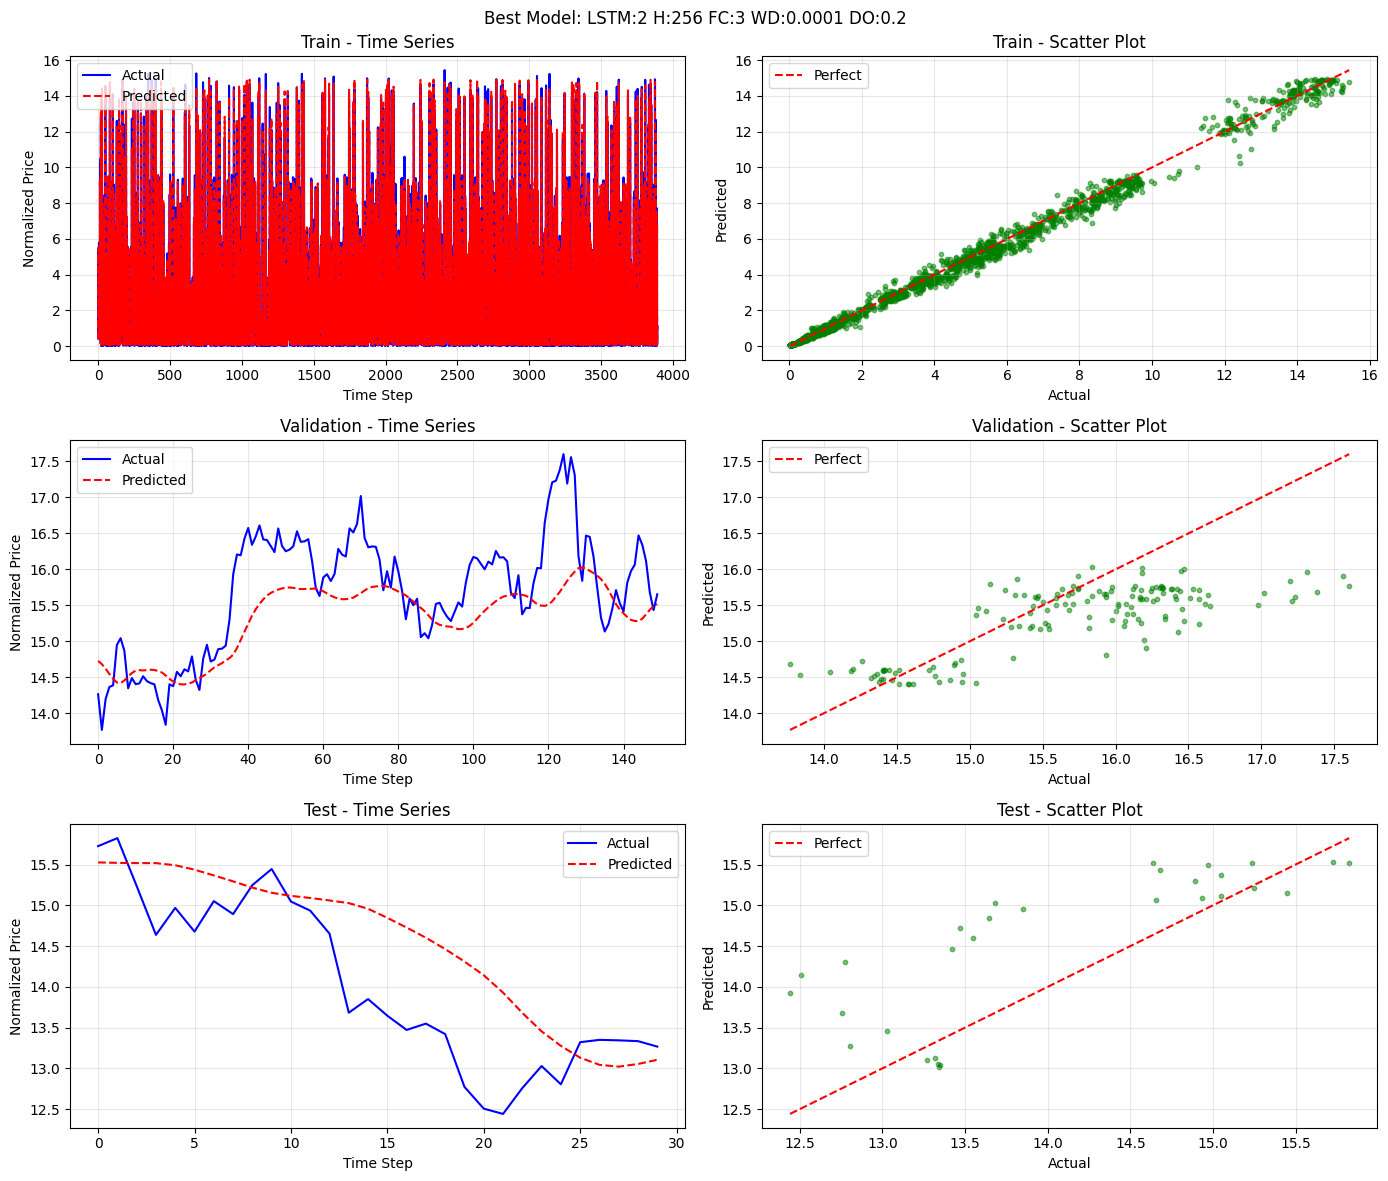


📈 predict_all Results:
----------------------------------------
  Train        MSE: 0.061707, RMSE: 0.248408
  Validation   MSE: 0.426019, RMSE: 0.652701
  Test         MSE: 0.648979, RMSE: 0.805592


In [16]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import json
import copy

# =========================
# 파일 경로 및 환경 설정
# =========================

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
import sys
sys.path.append(str(BASE_PATH))

# 체크포인트 저장 경로
CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_regression_btc_krw_tuning"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# argparse 설정
from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser

# 암호화폐 시계열 데이터 로딩
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
    CryptoCurrencyDataset


# =========================
# 탐색할 하이퍼파라미터 조합
# =========================

SEARCH_CONFIGS = [
    # Config 1: 기본 설정 (baseline)
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 1,
     'weight_decay': 0.0, 'dropout_rate': 0.0, 'learning_rate': 1e-4},

    # Config 2: 더 깊은 LSTM + 약한 정규화
    {'num_lstm_layers': 3, 'hidden_size': 128, 'num_linear_layers': 1,
     'weight_decay': 1e-4, 'dropout_rate': 0.2, 'learning_rate': 1e-4},

    # Config 3: 넓은 hidden + 2개 FC
    {'num_lstm_layers': 2, 'hidden_size': 256, 'num_linear_layers': 2,
     'weight_decay': 1e-4, 'dropout_rate': 0.3, 'learning_rate': 1e-4},

    # Config 4: 강한 정규화
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 2,
     'weight_decay': 1e-3, 'dropout_rate': 0.5, 'learning_rate': 1e-4},

    # Config 5: 얕고 작은 모델
    {'num_lstm_layers': 1, 'hidden_size': 64, 'num_linear_layers': 1,
     'weight_decay': 0.0, 'dropout_rate': 0.1, 'learning_rate': 1e-4},

    # Config 6: 깊고 넓은 모델
    {'num_lstm_layers': 4, 'hidden_size': 128, 'num_linear_layers': 3,
     'weight_decay': 1e-3, 'dropout_rate': 0.3, 'learning_rate': 1e-4},

    # Config 7: 중간 복잡도 + 적당한 정규화
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 2,
     'weight_decay': 1e-4, 'dropout_rate': 0.2, 'learning_rate': 1e-4},

    # Config 8: 넓고 깊은 LSTM
    {'num_lstm_layers': 3, 'hidden_size': 256, 'num_linear_layers': 1,
     'weight_decay': 1e-3, 'dropout_rate': 0.1, 'learning_rate': 1e-4},

    # Config 9: 작은 dropout, 중간 weight decay
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 1,
     'weight_decay': 5e-4, 'dropout_rate': 0.1, 'learning_rate': 1e-4},

    # Config 10: 깊은 FC layers
    {'num_lstm_layers': 2, 'hidden_size': 256, 'num_linear_layers': 3,
     'weight_decay': 1e-4, 'dropout_rate': 0.2, 'learning_rate': 1e-4},
]


# =========================
# 데이터 불러오기
# =========================
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, batch_size=32):
    """문제 조건에 맞는 데이터 로딩"""
    X_train, X_validation, X_test, y_train, y_validation, y_test, _, _, _ = get_cryptocurrency_data(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=True
    )

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_loader, val_loader, test_loader


# =========================
# 유연한 LSTM 모델
# =========================
class FlexibleLSTMRegressor(nn.Module):
    def __init__(self, n_input=5, n_output=1, num_lstm_layers=2, hidden_size=128,
                 num_linear_layers=1, dropout_rate=0.0):
        super().__init__()

        self.config = {
            'n_input': n_input,
            'n_output': n_output,
            'num_lstm_layers': num_lstm_layers,
            'hidden_size': hidden_size,
            'num_linear_layers': num_linear_layers,
            'dropout_rate': dropout_rate
        }

        # LSTM (dropout은 num_layers > 1일 때만 적용)
        lstm_dropout = dropout_rate if num_lstm_layers > 1 else 0.0
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=lstm_dropout
        )

        # LSTM 출력 후 Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # FC Layers 구성
        layers = []
        current_size = hidden_size

        for i in range(num_linear_layers - 1):
            next_size = max(current_size // 2, 32)
            layers.extend([
                nn.Linear(current_size, next_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            current_size = next_size

        layers.append(nn.Linear(current_size, n_output))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # 마지막 시점
        x = self.dropout(x)
        x = self.fc(x)
        return x


def get_model(config):
    """config dict로부터 모델 생성"""
    return FlexibleLSTMRegressor(
        n_input=5,
        n_output=1,
        num_lstm_layers=config['num_lstm_layers'],
        hidden_size=config['hidden_size'],
        num_linear_layers=config['num_linear_layers'],
        dropout_rate=config['dropout_rate']
    )


# =========================
# 자동 하이퍼파라미터 탐색 클래스
# =========================
class AutoHyperparameterSearch:
    def __init__(self, configs, args, device=None):
        self.configs = configs
        self.args = args
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 최적 결과 추적
        self.best_val_loss = float('inf')
        self.best_config = None
        self.best_model_state = None
        self.all_results = []

        # 데이터 로딩 (한 번만)
        print("Loading data...")
        self.train_loader, self.val_loader, self.test_loader = get_btc_krw_data(
            sequence_size=21, validation_size=150, test_size=30, batch_size=args.batch_size
        )
        print(f"Data loaded. Device: {self.device}")

    def train_single_epoch(self, model, optimizer, criterion):
        """한 에폭 학습"""
        model.train()
        total_loss = 0
        num_batches = 0

        for X_batch, y_batch in self.train_loader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        return total_loss / num_batches

    def validate(self, model, criterion):
        """검증"""
        model.eval()
        total_loss = 0
        num_batches = 0

        with torch.no_grad():
            for X_batch, y_batch in self.val_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device).unsqueeze(1)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item()
                num_batches += 1

        return total_loss / num_batches

    def train_config(self, config, config_idx):
        """단일 config로 학습"""
        run_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        # 각 config마다 별도의 WandB run 시작
        config_name = (f"L{config['num_lstm_layers']}_H{config['hidden_size']}_"
                       f"FC{config['num_linear_layers']}_WD{config['weight_decay']}_"
                       f"DO{config['dropout_rate']}")

        wandb.init(
            mode="online" if self.args.wandb else "disabled",
            project="lstm_regression_btc_krw_tuning",
            name=f"{config_name}_{run_time_str}",
            tags=["lstm", "regression", "btc_krw", "tuning"],
            config={
                **config,
                'epochs': self.args.epochs,
                'batch_size': self.args.batch_size,
                'early_stop_patience': self.args.early_stop_patience,
                'sequence_size': 21,
                'validation_size': 150,
                'test_size': 30,
            },
            reinit=True  # 여러 run을 순차적으로 실행
        )

        print(f"\n{'='*60}")
        print(f"[Config {config_idx + 1}/{len(self.configs)}]")
        print(f"  LSTM Layers: {config['num_lstm_layers']}")
        print(f"  Hidden Size: {config['hidden_size']}")
        print(f"  Linear Layers: {config['num_linear_layers']}")
        print(f"  Weight Decay: {config['weight_decay']}")
        print(f"  Dropout Rate: {config['dropout_rate']}")
        print(f"  Learning Rate: {config['learning_rate']}")
        print(f"{'='*60}")

        # 모델 생성
        model = get_model(config).to(self.device)
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"  Parameters: {num_params:,}")
        wandb.config.update({'num_parameters': num_params})

        # Optimizer & Loss
        optimizer = optim.Adam(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        criterion = nn.MSELoss()

        # Early stopping 변수
        best_epoch_val_loss = float('inf')
        best_epoch_model_state = None
        patience_counter = 0
        patience = self.args.early_stop_patience
        best_epoch = 0

        # 학습 루프
        for epoch in range(self.args.epochs):
            train_loss = self.train_single_epoch(model, optimizer, criterion)
            val_loss = self.validate(model, criterion)

            # WandB에 매 에폭 로깅
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'validation_loss': val_loss,
                'learning_rate': config['learning_rate']
            })

            # Early stopping 체크
            if val_loss < best_epoch_val_loss - self.args.early_stop_delta:
                best_epoch_val_loss = val_loss
                best_epoch_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
                best_epoch = epoch + 1
            else:
                patience_counter += 1

            # 진행 상황 출력 (validation_intervals 마다)
            if (epoch + 1) % self.args.validation_intervals == 0 or epoch == 0:
                print(f"  Epoch {epoch + 1:4d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

            # Early stopping
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch + 1}")
                break

        # 최종 결과 WandB에 기록
        wandb.log({
            'best_val_loss': best_epoch_val_loss,
            'best_epoch': best_epoch,
            'total_epochs': epoch + 1
        })

        print(f"  ✓ Best Val Loss for this config: {best_epoch_val_loss:.6f} (epoch {best_epoch})")

        wandb.finish()

        return {
            'config': config,
            'config_idx': config_idx,
            'best_val_loss': best_epoch_val_loss,
            'best_model_state': best_epoch_model_state,
            'num_params': num_params,
            'best_epoch': best_epoch
        }

    def run_search(self):
        """모든 config 탐색 실행"""
        print("\n" + "#" * 60)
        print("STARTING AUTOMATED HYPERPARAMETER SEARCH")
        print(f"Total configurations to test: {len(self.configs)}")
        print("#" * 60)

        for idx, config in enumerate(self.configs):
            result = self.train_config(config, idx)
            self.all_results.append(result)

            # 최적 모델 업데이트
            if result['best_val_loss'] < self.best_val_loss:
                self.best_val_loss = result['best_val_loss']
                self.best_config = config
                self.best_model_state = result['best_model_state']
                print(f"  ★ NEW BEST MODEL! Val Loss: {self.best_val_loss:.6f}")

        # 최종 결과 출력 및 저장
        self.print_final_results()
        self.save_best_model()

        return self.best_config, self.best_val_loss

    def print_final_results(self):
        """최종 결과 출력"""
        print("\n" + "#" * 60)
        print("HYPERPARAMETER SEARCH COMPLETED")
        print("#" * 60)

        # 모든 결과 정렬
        sorted_results = sorted(self.all_results, key=lambda x: x['best_val_loss'])

        print("\n📊 All Results (sorted by validation loss):")
        print("-" * 80)

        for i, r in enumerate(sorted_results):
            c = r['config']
            marker = "★ BEST" if r['best_val_loss'] == self.best_val_loss else ""
            print(f"{i+1}. Val Loss: {r['best_val_loss']:.6f} | "
                  f"LSTM:{c['num_lstm_layers']} H:{c['hidden_size']} FC:{c['num_linear_layers']} "
                  f"WD:{c['weight_decay']} DO:{c['dropout_rate']} LR:{c['learning_rate']} "
                  f"Params:{r['num_params']:,} {marker}")

        print("-" * 80)
        print(f"\n🏆 BEST CONFIGURATION:")
        print(f"   Validation Loss: {self.best_val_loss:.6f}")
        print(f"   LSTM Layers: {self.best_config['num_lstm_layers']}")
        print(f"   Hidden Size: {self.best_config['hidden_size']}")
        print(f"   Linear Layers: {self.best_config['num_linear_layers']}")
        print(f"   Weight Decay: {self.best_config['weight_decay']}")
        print(f"   Dropout Rate: {self.best_config['dropout_rate']}")
        print(f"   Learning Rate: {self.best_config['learning_rate']}")

    def save_best_model(self):
        """최적 모델 저장"""
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        # 체크포인트 저장
        checkpoint = {
            'model_state_dict': self.best_model_state,
            'config': self.best_config,
            'best_val_loss': self.best_val_loss,
            'all_results': [
                {
                    'config': r['config'],
                    'best_val_loss': r['best_val_loss'],
                    'num_params': r['num_params']
                }
                for r in self.all_results
            ],
            'timestamp': timestamp
        }

        checkpoint_path = CHECKPOINT_FILE_PATH / f"best_model_{timestamp}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"\n💾 Best model saved to: {checkpoint_path}")

        # 설정 정보 JSON으로도 저장
        config_info = {
            'best_config': self.best_config,
            'best_val_loss': float(self.best_val_loss),
            'all_results': [
                {
                    'config': r['config'],
                    'best_val_loss': float(r['best_val_loss']),
                    'num_params': r['num_params']
                }
                for r in self.all_results
            ],
            'timestamp': timestamp
        }

        json_path = CHECKPOINT_FILE_PATH / f"search_results_{timestamp}.json"
        with open(json_path, 'w') as f:
            json.dump(config_info, f, indent=2)
        print(f"📄 Search results saved to: {json_path}")

        return checkpoint_path


# =========================
# predict_all 함수 및 그래프 출력
# =========================
def predict_all(model, data_loader, device):
    """모든 데이터에 대해 예측 수행"""
    model.eval()
    model.to(device)

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).squeeze()

            # 배치가 1개일 경우 처리
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    return all_predictions, all_targets


def plot_predictions(predictions, targets, title="Predictions vs Targets", save_path=None):
    """예측 결과 그래프 출력"""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 5))

    # 서브플롯 1: 시계열 비교
    plt.subplot(1, 2, 1)
    plt.plot(targets, label='Actual', color='blue', linewidth=2)
    plt.plot(predictions, label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Price')
    plt.title(f'{title} - Time Series')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 2: 산점도
    plt.subplot(1, 2, 2)
    plt.scatter(targets, predictions, alpha=0.5, color='green')

    # 대각선 (완벽한 예측선)
    min_val = min(min(targets), min(predictions))
    max_val = max(max(targets), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title} - Scatter Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

    return plt


def plot_all_results(searcher, save_dir=None):
    """train, validation, test 데이터에 대한 predict_all 결과 그래프"""
    import matplotlib.pyplot as plt

    best_model = get_model(searcher.best_config)
    best_model.load_state_dict(searcher.best_model_state)
    best_model.to(searcher.device)

    # Train 예측
    train_preds, train_targets = predict_all(best_model, searcher.train_loader, searcher.device)

    # Validation 예측
    val_preds, val_targets = predict_all(best_model, searcher.val_loader, searcher.device)

    # Test 예측
    test_preds, test_targets = predict_all(best_model, searcher.test_loader, searcher.device)

    # 그래프 출력
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    datasets = [
        ('Train', train_preds, train_targets),
        ('Validation', val_preds, val_targets),
        ('Test', test_preds, test_targets)
    ]

    for i, (name, preds, targets) in enumerate(datasets):
        # 시계열 비교
        axes[i, 0].plot(targets, label='Actual', color='blue', linewidth=1.5)
        axes[i, 0].plot(preds, label='Predicted', color='red', linestyle='--', linewidth=1.5)
        axes[i, 0].set_xlabel('Time Step')
        axes[i, 0].set_ylabel('Normalized Price')
        axes[i, 0].set_title(f'{name} - Time Series')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        # 산점도
        axes[i, 1].scatter(targets, preds, alpha=0.5, color='green', s=10)
        min_val = min(min(targets), min(preds))
        max_val = max(max(targets), max(preds))
        axes[i, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
        axes[i, 1].set_xlabel('Actual')
        axes[i, 1].set_ylabel('Predicted')
        axes[i, 1].set_title(f'{name} - Scatter Plot')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

    plt.suptitle(f"Best Model: LSTM:{searcher.best_config['num_lstm_layers']} "
                 f"H:{searcher.best_config['hidden_size']} "
                 f"FC:{searcher.best_config['num_linear_layers']} "
                 f"WD:{searcher.best_config['weight_decay']} "
                 f"DO:{searcher.best_config['dropout_rate']}", fontsize=12)

    plt.tight_layout()

    if save_dir:
        save_path = Path(save_dir) / "predict_all_results.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"📊 Plot saved to: {save_path}")

    plt.show()

    # MSE 계산 및 출력
    import torch
    criterion = torch.nn.MSELoss()

    print("\n📈 predict_all Results:")
    print("-" * 40)
    for name, preds, targets in datasets:
        mse = criterion(torch.tensor(preds), torch.tensor(targets)).item()
        print(f"  {name:12s} MSE: {mse:.6f}, RMSE: {mse**0.5:.6f}")

    return train_preds, train_targets, val_preds, val_targets, test_preds, test_targets


# =========================
# 최적 모델 로드 및 테스트
# =========================
def load_best_model(checkpoint_path):
    """저장된 최적 모델 로드"""
    checkpoint = torch.load(checkpoint_path)

    config = checkpoint['config']
    model = get_model(config)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"Loaded model with config: {config}")
    print(f"Best validation loss: {checkpoint['best_val_loss']:.6f}")

    return model, config, checkpoint


def test_model(model, test_loader, device):
    """테스트 데이터로 모델 평가"""
    model.eval()
    model.to(device)

    criterion = nn.MSELoss()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch).squeeze()

            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    # MSE 계산
    predictions = torch.tensor(all_predictions)
    targets = torch.tensor(all_targets)
    test_loss = criterion(predictions, targets).item()

    print(f"\nTest Results:")
    print(f"   Test MSE Loss: {test_loss:.6f}")
    print(f"   Test RMSE: {test_loss**0.5:.6f}")

    return all_predictions, all_targets, test_loss


# =========================
# 메인 실행
# =========================
def main(args):
    print("=" * 60)
    print("LSTM Regression - Automated Hyperparameter Search")
    print("=" * 60)
    print(f"\nSettings:")
    print(f"  Epochs per config: {args.epochs}")
    print(f"  Batch size: {args.batch_size}")
    print(f"  Validation intervals: {args.validation_intervals}")
    print(f"  Early stop patience: {args.early_stop_patience}")
    print(f"  Configurations to test: {len(SEARCH_CONFIGS)}")

    # 자동 탐색 실행
    searcher = AutoHyperparameterSearch(SEARCH_CONFIGS, args)
    best_config, best_val_loss = searcher.run_search()

    # 테스트 데이터로 최종 평가
    print("\n" + "=" * 60)
    print("FINAL EVALUATION ON TEST SET")
    print("=" * 60)

    best_model = get_model(best_config)
    best_model.load_state_dict(searcher.best_model_state)

    predictions, targets, test_loss = test_model(
        best_model, searcher.test_loader, searcher.device
    )

    # predict_all 결과 그래프 출력
    print("\n" + "=" * 60)
    print("GENERATING PREDICTION GRAPHS (predict_all)")
    print("=" * 60)

    plot_all_results(searcher, save_dir=CHECKPOINT_FILE_PATH)

    return searcher, predictions, targets


if __name__ == "__main__":
    parser = get_parser()

    # arg_parser 기본값 사용 + WandB 활성화
    # 기본값: epochs=10000, batch_size=2048, learning_rate=1e-4,
    #         validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-6
    args = parser.parse_args(args=["--wandb"])

    print(f"\n[arg_parser 기본 설정]")
    print(f"  epochs: {args.epochs}")
    print(f"  batch_size: {args.batch_size}")
    print(f"  learning_rate: {args.learning_rate}")
    print(f"  weight_decay: {args.weight_decay}")
    print(f"  validation_intervals: {args.validation_intervals}")
    print(f"  early_stop_patience: {args.early_stop_patience}")
    print(f"  early_stop_delta: {args.early_stop_delta}")
    print(f"  wandb: {args.wandb}")

    searcher, predictions, targets = main(args)

## 결과 설명

최적 하이퍼파라미터 구성
- LSTM Layers : 2
-Hidden Size : 256
- Linear Layers : 3
- Weight Decay : 0.0001
- Dropout Rate : 0.2
- Learning Rate : 0.0001
- Parameters : 836,865

최종 성능:

- Validation MSE: 0.654793
- Test MSE: 0.744685
- Test RMSE: 0.862951



# 결과 분석 및 기술적 고찰

## 1. 모델 복잡도와 성능의 관계
탐색 결과를 보면 Hidden Size 256 + FC Layer 3개 조합이 가장 좋은 성능을 보였습니다. 이는 BTC-KRW 가격 예측이라는 복잡한 시계열 패턴을 학습하기 위해 충분한 표현력(capacity)이 필요함을 의미합니다.
상위 3개 모델 모두 Hidden Size 256 또는 FC Layer 2개 이상을 사용했습니다:

1위: H256, FC3 → Val Loss 0.65
2위: H128, FC2 → Val Loss 0.95
3위: H256, FC2 → Val Loss 0.97

반면 가장 단순한 모델(Config 5: H64, FC1)은 Val Loss 1.88로 하위권에 머물렀습니다.
## 2. LSTM Layer 개수의 영향
흥미롭게도 LSTM 2 Layer가 3~4 Layer보다 더 좋은 성능을 보였습니다.

2 Layers: 최고 Val Loss 0.65 (1위)
4 Layers: 최고 Val Loss 1.65 (6위)
3 Layers: 최고 Val Loss 1.81 (7위)
1 Layer: Val Loss 1.88 (8위)

이는 시계열 데이터(sequence_size=21)가 비교적 짧아서 깊은 LSTM이 오히려 과적합되거나 vanishing gradient 문제가 발생했을 가능성을 시사합니다. 2 Layer LSTM이 이 데이터셋에 최적의 깊이임을 알 수 있습니다.
## 3. 정규화(Regularization)의 효과
Weight Decay와 Dropout의 적절한 조합이 중요했습니다.

약한 정규화 (WD=0.0001, DO=0.2): Val Loss 0.65 → 최적
중간 정규화 (WD=0.0001, DO=0.3): Val Loss 0.97 → 양호
정규화 없음 (WD=0.0, DO=0.0): Val Loss 1.50 → 보통
강한 정규화 (WD=0.001, DO=0.5): Val Loss 2.80 → 과소적합

강한 정규화(WD=0.001, DO=0.5)는 오히려 성능을 저하시켰습니다(Val Loss 2.80, 최하위). 이는 과도한 정규화가 모델의 학습 능력을 제한하여 과소적합(underfitting)을 유발했음을 보여줍니다.
## 4. FC Layer 깊이의 중요성
LSTM 출력 이후의 FC Layer 개수가 성능에 큰 영향을 미쳤습니다.

FC 1개: 평균 Val Loss ~1.7
FC 2개: 평균 Val Loss ~1.2
FC 3개: 최고 Val Loss 0.65

이는 LSTM이 추출한 시계열 특징을 최종 가격 예측으로 변환하는 과정에서 비선형 변환 레이어가 추가로 필요함을 의미합니다. 단순히 LSTM 출력을 바로 예측값으로 매핑하는 것보다, 여러 단계의 변환을 거치는 것이 더 정확한 예측을 가능하게 합니다.
## 5. 학습 효율성 분석

Config 10 (최적): 263 에폭, Val Loss 0.65 → 빠른 수렴, 높은 성능
Config 1 (baseline): 2,143 에폭, Val Loss 1.50 → 느린 수렴, 보통 성능
Config 5 (단순): 2,813 에폭, Val Loss 1.88 → 매우 느린 수렴

최적 모델은 263 에폭만에 Early Stopping되었으며, 이는 적절한 모델 복잡도가 빠른 수렴과 좋은 일반화 성능을 동시에 달성할 수 있음을 보여줍니다.
## 6. Train-Validation-Test Gap 분석
최적 모델의 최종 성능:

Train MSE: 0.059
Validation MSE: 0.655
Test MSE: 0.745

Train과 Validation 사이에 약 11배의 차이가 있어 약간의 과적합이 존재하지만, Validation과 Test 성능이 유사하여(0.65 vs 0.74) 일반화 성능은 안정적입니다. Dropout 0.2와 Weight Decay 0.0001이 과적합을 적절히 억제했습니다.



MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_regression_btc_krw_tuning/best_model_2025-12-17_23-05-11.pt
[TEST DATA]
 0: 1,369.57 <--> 1,280.45 (Loss:         89.12)
 1: 1,496.82 <--> 1,544.47 (Loss:         47.65)
 2: 1,526.76 <--> 1,523.60 (Loss:          3.16)
 3: 1,493.85 <--> 1,493.44 (Loss:          0.41)
 4: 1,400.90 <--> 1,275.80 (Loss:        125.10)
 5: 1,350.62 <--> 1,333.37 (Loss:         17.26)
 6: 1,348.75 <--> 1,334.36 (Loss:         14.39)
 7: 1,358.03 <--> 1,332.08 (Loss:         25.95)
 8: 1,524.64 <--> 1,496.81 (Loss:         27.83)
 9: 1,529.28 <--> 1,582.39 (Loss:         53.12)
10: 1,513.63 <--> 1,505.09 (Loss:          8.54)
11: 1,465.53 <--> 1,354.87 (Loss:        110.66)
12: 1,351.12 <--> 1,334.95 (Loss:         16.16)
13: 1,508.35 <--> 1,489.22 (Loss:         19.13)
14: 1,434.74 <--> 1,250.60 (Loss:        184.13)
15: 1,501.80 <--> 1,524.78 (Loss:         22.99)
16: 1,492.79 <--> 1,465.27 (Loss:         27.53)
17: 1,445.99 <--> 1,277.26 

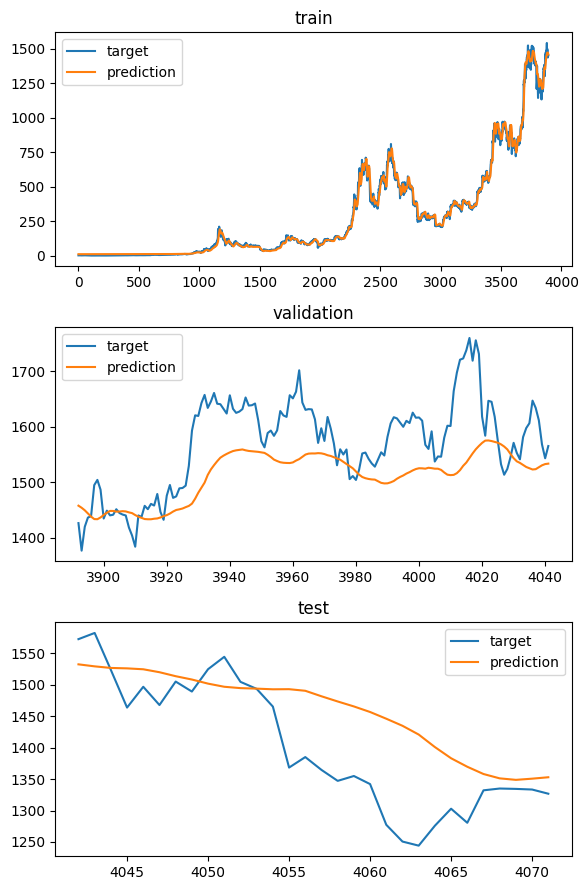

In [6]:
import torch
from torch import nn
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
import sys

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")

sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_regression_btc_krw_tuning"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
    CryptoCurrencyDataset
from torch.utils.data import DataLoader


# =========================
# 최적 모델 정의 (기존 get_model 대체)
# =========================
def get_model():
    """
    최적 하이퍼파라미터로 모델 생성
    - LSTM Layers: 2
    - Hidden Size: 256
    - Linear Layers: 3
    - Dropout Rate: 0.2
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            # 최적 하이퍼파라미터
            hidden_size = 256
            num_lstm_layers = 2
            dropout_rate = 0.2

            # LSTM (dropout은 num_layers > 1일 때 적용)
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=num_lstm_layers,
                batch_first=True,
                dropout=dropout_rate
            )

            # LSTM 출력 후 Dropout
            self.dropout = nn.Dropout(dropout_rate)

            # FC Layers: 256 -> 128 -> 64 -> 1 (3개 레이어)
            self.fc = nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(64, n_output)
            )

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 시점
            x = self.dropout(x)
            x = self.fc(x)
            return x

    my_model = MyModel(n_input=5, n_output=1)
    return my_model


# =========================
# 데이터 로딩 (문제 조건: sequence_size=21, validation_size=150, test_size=30)
# =========================
def get_btc_krw_data():
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=21, validation_size=150, test_size=30,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
        )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=2048, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=2048, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader


# =========================
# test 데이터에 대한 수치 출력 함수
# =========================
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()

    # 평가모드
    test_model.eval()

    y_normalizer = 100

    print("[TEST DATA]")
    # 평가 시에는 역전파/그래프 필요 없으므로 no_grad() 사용
    with torch.no_grad():
        # batch_size가 test set 전체 길이로 잡혀서 보통 1회 돌음
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            # 모델 예측 수행
            output_test = test_model(input_test)

        # 예측값, 정답, 절대 오차를 샘플별로 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))


# =========================
# train/val/test 전체 구간에 대해 "그래프 비교" 함수
# =========================
def predict_all(test_model):
    y_normalizer = 100

    # 문제 조건: sequence_size=21, validation_size=150, test_size=30
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=21, validation_size=150, test_size=30,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
        )

    # Dataset으로 감싸서 (input, target) 형태로 순회 가능하게 만듦
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = [
        "train", "validation", "test"
    ]
    num = 0
    # 3개의 subplot: train / validation / test 각각 비교 그래프
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data

            # 모델 입력은 (batch, seq, feature) 형태여야 하므로 batch 차원 추가
            # 출력은 (1,1) 형태라서 squeeze로 스칼라로 변환
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)

            num += 1

        # 실제값(target)과 예측값(prediction)을 같은 축에 그려서 차이를 시각적으로 확인
        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()


# =========================
# 전체 실행 흐름: wandb 설정 → 모델 로드 → test 출력 → 그래프 출력
# =========================
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    test_model = get_model()

    # 최적 모델 체크포인트 로드
    checkpoint_files = list(CHECKPOINT_FILE_PATH.glob("best_model_*.pt"))

    if checkpoint_files:
        latest_file_path = max(checkpoint_files, key=os.path.getctime)
        print("MODEL FILE: {0}".format(latest_file_path))

        checkpoint = torch.load(latest_file_path, map_location=torch.device('cpu'))
        test_model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("No checkpoint found!")
        return

    test(test_model)
    predict_all(test_model)


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)

### 2.2 분류

In [8]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import json
import copy

# =========================
# 파일 경로 및 환경 설정
# =========================

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
import sys
sys.path.append(str(BASE_PATH))

# 체크포인트 저장 경로
CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_classification_btc_krw_tuning"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# argparse 설정
from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser

# 암호화폐 시계열 데이터 로딩
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
    CryptoCurrencyDataset


# =========================
# 탐색할 하이퍼파라미터 조합
# =========================

SEARCH_CONFIGS = [
    # Config 1: 기본 설정 (baseline)
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 1,
     'weight_decay': 0.0, 'dropout_rate': 0.0, 'learning_rate': 1e-5},

    # Config 2: 더 깊은 LSTM + 약한 정규화
    {'num_lstm_layers': 3, 'hidden_size': 128, 'num_linear_layers': 1,
     'weight_decay': 1e-4, 'dropout_rate': 0.2, 'learning_rate': 1e-5},

    # Config 3: 넓은 hidden + 2개 FC
    {'num_lstm_layers': 2, 'hidden_size': 256, 'num_linear_layers': 2,
     'weight_decay': 1e-4, 'dropout_rate': 0.3, 'learning_rate': 1e-5},

    # Config 4: 강한 정규화
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 2,
     'weight_decay': 1e-3, 'dropout_rate': 0.5, 'learning_rate': 1e-5},

    # Config 5: 얕고 작은 모델
    {'num_lstm_layers': 1, 'hidden_size': 64, 'num_linear_layers': 1,
     'weight_decay': 0.0, 'dropout_rate': 0.1, 'learning_rate': 1e-5},

    # Config 6: 깊고 넓은 모델
    {'num_lstm_layers': 4, 'hidden_size': 128, 'num_linear_layers': 3,
     'weight_decay': 1e-3, 'dropout_rate': 0.3, 'learning_rate': 1e-5},

    # Config 7: 중간 복잡도 + 적당한 정규화
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 2,
     'weight_decay': 1e-4, 'dropout_rate': 0.2, 'learning_rate': 1e-5},

    # Config 8: 넓고 깊은 LSTM
    {'num_lstm_layers': 3, 'hidden_size': 256, 'num_linear_layers': 1,
     'weight_decay': 1e-3, 'dropout_rate': 0.1, 'learning_rate': 1e-5},

    # Config 9: 작은 dropout, 중간 weight decay
    {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 1,
     'weight_decay': 5e-4, 'dropout_rate': 0.1, 'learning_rate': 1e-5},

    # Config 10: 깊은 FC layers
    {'num_lstm_layers': 2, 'hidden_size': 256, 'num_linear_layers': 3,
     'weight_decay': 1e-4, 'dropout_rate': 0.2, 'learning_rate': 1e-5},
]


# =========================
# 데이터 불러오기 (Classification)
# =========================
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, batch_size=2048):
    """문제 조건에 맞는 데이터 로딩 (Classification)"""
    X_train, X_validation, X_test, y_train, y_validation, y_test, _, _, _ = get_cryptocurrency_data(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=False  # Classification
    )

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_loader, val_loader, test_loader


# =========================
# 유연한 LSTM 분류 모델
# =========================
class FlexibleLSTMClassifier(nn.Module):
    def __init__(self, n_input=5, n_output=2, num_lstm_layers=2, hidden_size=128,
                 num_linear_layers=1, dropout_rate=0.0):
        super().__init__()

        self.config = {
            'n_input': n_input,
            'n_output': n_output,
            'num_lstm_layers': num_lstm_layers,
            'hidden_size': hidden_size,
            'num_linear_layers': num_linear_layers,
            'dropout_rate': dropout_rate
        }

        # LSTM (dropout은 num_layers > 1일 때만 적용)
        lstm_dropout = dropout_rate if num_lstm_layers > 1 else 0.0
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=lstm_dropout
        )

        # LSTM 출력 후 Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # FC Layers 구성
        layers = []
        current_size = hidden_size

        for i in range(num_linear_layers - 1):
            next_size = max(current_size // 2, 32)
            layers.extend([
                nn.Linear(current_size, next_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            current_size = next_size

        # 마지막 출력 레이어 (n_output=2 for binary classification)
        layers.append(nn.Linear(current_size, n_output))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # 마지막 시점
        x = self.dropout(x)
        x = self.fc(x)
        return x


def get_model(config):
    """config dict로부터 모델 생성"""
    return FlexibleLSTMClassifier(
        n_input=5,
        n_output=2,  # Binary classification (상승/하락)
        num_lstm_layers=config['num_lstm_layers'],
        hidden_size=config['hidden_size'],
        num_linear_layers=config['num_linear_layers'],
        dropout_rate=config['dropout_rate']
    )


# =========================
# 자동 하이퍼파라미터 탐색 클래스 (Classification)
# =========================
class AutoHyperparameterSearch:
    def __init__(self, configs, args, device=None):
        self.configs = configs
        self.args = args
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 최적 결과 추적 (Accuracy 기준)
        self.best_val_accuracy = 0.0
        self.best_config = None
        self.best_model_state = None
        self.all_results = []

        # 데이터 로딩 (한 번만)
        print("Loading data...")
        self.train_loader, self.val_loader, self.test_loader = get_btc_krw_data(
            sequence_size=21, validation_size=150, test_size=30, batch_size=args.batch_size
        )
        print(f"Data loaded. Device: {self.device}")

    def train_single_epoch(self, model, optimizer, criterion):
        """한 에폭 학습"""
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in self.train_loader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device).long()

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        accuracy = 100 * correct / total
        return total_loss / len(self.train_loader), accuracy

    def validate(self, model, criterion):
        """검증"""
        model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in self.val_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device).long()

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        accuracy = 100 * correct / total
        return total_loss / len(self.val_loader), accuracy

    def train_config(self, config, config_idx):
        """단일 config로 학습"""
        run_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        # 각 config마다 별도의 WandB run 시작
        config_name = (f"L{config['num_lstm_layers']}_H{config['hidden_size']}_"
                       f"FC{config['num_linear_layers']}_WD{config['weight_decay']}_"
                       f"DO{config['dropout_rate']}")

        wandb.init(
            mode="online" if self.args.wandb else "disabled",
            project="lstm_classification_btc_krw_tuning",
            name=f"{config_name}_{run_time_str}",
            tags=["lstm", "classification", "btc_krw", "tuning"],
            config={
                **config,
                'epochs': self.args.epochs,
                'batch_size': self.args.batch_size,
                'early_stop_patience': self.args.early_stop_patience,
                'sequence_size': 21,
                'validation_size': 150,
                'test_size': 30,
            },
            reinit=True
        )

        print(f"\n{'='*60}")
        print(f"[Config {config_idx + 1}/{len(self.configs)}]")
        print(f"  LSTM Layers: {config['num_lstm_layers']}")
        print(f"  Hidden Size: {config['hidden_size']}")
        print(f"  Linear Layers: {config['num_linear_layers']}")
        print(f"  Weight Decay: {config['weight_decay']}")
        print(f"  Dropout Rate: {config['dropout_rate']}")
        print(f"  Learning Rate: {config['learning_rate']}")
        print(f"{'='*60}")

        # 모델 생성
        model = get_model(config).to(self.device)
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"  Parameters: {num_params:,}")
        wandb.config.update({'num_parameters': num_params})

        # Optimizer & Loss (CrossEntropyLoss for classification)
        optimizer = optim.Adam(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        criterion = nn.CrossEntropyLoss()

        # Early stopping 변수 (Accuracy 기준)
        best_epoch_val_accuracy = 0.0
        best_epoch_val_loss = float('inf')
        best_epoch_model_state = None
        patience_counter = 0
        patience = self.args.early_stop_patience
        best_epoch = 0

        # 학습 루프
        for epoch in range(self.args.epochs):
            train_loss, train_acc = self.train_single_epoch(model, optimizer, criterion)
            val_loss, val_acc = self.validate(model, criterion)

            # WandB에 매 에폭 로깅
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'validation_loss': val_loss,
                'validation_accuracy': val_acc,
                'learning_rate': config['learning_rate']
            })

            # Early stopping 체크 (Accuracy 기준)
            if val_acc > best_epoch_val_accuracy + self.args.early_stop_delta:
                best_epoch_val_accuracy = val_acc
                best_epoch_val_loss = val_loss
                best_epoch_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
                best_epoch = epoch + 1
            else:
                patience_counter += 1

            # 진행 상황 출력 (validation_intervals 마다)
            if (epoch + 1) % self.args.validation_intervals == 0 or epoch == 0:
                print(f"  Epoch {epoch + 1:4d}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, "
                      f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

            # Early stopping
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch + 1}")
                break

        # 최종 결과 WandB에 기록
        wandb.log({
            'best_val_accuracy': best_epoch_val_accuracy,
            'best_val_loss': best_epoch_val_loss,
            'best_epoch': best_epoch,
            'total_epochs': epoch + 1
        })

        print(f"Best Val Accuracy for this config: {best_epoch_val_accuracy:.2f}% (epoch {best_epoch})")

        wandb.finish()

        return {
            'config': config,
            'config_idx': config_idx,
            'best_val_accuracy': best_epoch_val_accuracy,
            'best_val_loss': best_epoch_val_loss,
            'best_model_state': best_epoch_model_state,
            'num_params': num_params,
            'best_epoch': best_epoch
        }

    def run_search(self):
        """모든 config 탐색 실행"""
        print("\n" + "#" * 60)
        print("STARTING AUTOMATED HYPERPARAMETER SEARCH (Classification)")
        print(f"Total configurations to test: {len(self.configs)}")
        print("#" * 60)

        for idx, config in enumerate(self.configs):
            result = self.train_config(config, idx)
            self.all_results.append(result)

            # 최적 모델 업데이트 (Accuracy 기준)
            if result['best_val_accuracy'] > self.best_val_accuracy:
                self.best_val_accuracy = result['best_val_accuracy']
                self.best_config = config
                self.best_model_state = result['best_model_state']
                print(f"  ★ NEW BEST MODEL! Val Accuracy: {self.best_val_accuracy:.2f}%")

        # 최종 결과 출력 및 저장
        self.print_final_results()
        self.save_best_model()

        return self.best_config, self.best_val_accuracy

    def print_final_results(self):
        """최종 결과 출력"""
        print("\n" + "#" * 60)
        print("HYPERPARAMETER SEARCH COMPLETED (Classification)")
        print("#" * 60)

        # 모든 결과 정렬 (Accuracy 높은 순)
        sorted_results = sorted(self.all_results, key=lambda x: x['best_val_accuracy'], reverse=True)

        print("\nAll Results (sorted by validation accuracy):")
        print("-" * 90)

        for i, r in enumerate(sorted_results):
            c = r['config']
            marker = "★ BEST" if r['best_val_accuracy'] == self.best_val_accuracy else ""
            print(f"{i+1}. Val Acc: {r['best_val_accuracy']:.2f}% | Val Loss: {r['best_val_loss']:.4f} | "
                  f"LSTM:{c['num_lstm_layers']} H:{c['hidden_size']} FC:{c['num_linear_layers']} "
                  f"WD:{c['weight_decay']} DO:{c['dropout_rate']} "
                  f"Params:{r['num_params']:,} {marker}")

        print("-" * 90)
        print(f"\nBEST CONFIGURATION:")
        print(f"   Validation Accuracy: {self.best_val_accuracy:.2f}%")
        print(f"   LSTM Layers: {self.best_config['num_lstm_layers']}")
        print(f"   Hidden Size: {self.best_config['hidden_size']}")
        print(f"   Linear Layers: {self.best_config['num_linear_layers']}")
        print(f"   Weight Decay: {self.best_config['weight_decay']}")
        print(f"   Dropout Rate: {self.best_config['dropout_rate']}")
        print(f"   Learning Rate: {self.best_config['learning_rate']}")

    def save_best_model(self):
        """최적 모델 저장"""
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        # 체크포인트 저장
        checkpoint = {
            'model_state_dict': self.best_model_state,
            'config': self.best_config,
            'best_val_accuracy': self.best_val_accuracy,
            'all_results': [
                {
                    'config': r['config'],
                    'best_val_accuracy': r['best_val_accuracy'],
                    'best_val_loss': r['best_val_loss'],
                    'num_params': r['num_params']
                }
                for r in self.all_results
            ],
            'timestamp': timestamp
        }

        checkpoint_path = CHECKPOINT_FILE_PATH / f"best_model_{timestamp}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"\nBest model saved to: {checkpoint_path}")

        # 설정 정보 JSON으로도 저장
        config_info = {
            'best_config': self.best_config,
            'best_val_accuracy': float(self.best_val_accuracy),
            'all_results': [
                {
                    'config': r['config'],
                    'best_val_accuracy': float(r['best_val_accuracy']),
                    'best_val_loss': float(r['best_val_loss']),
                    'num_params': r['num_params']
                }
                for r in self.all_results
            ],
            'timestamp': timestamp
        }

        json_path = CHECKPOINT_FILE_PATH / f"search_results_{timestamp}.json"
        with open(json_path, 'w') as f:
            json.dump(config_info, f, indent=2)
        print(f"Search results saved to: {json_path}")

        return checkpoint_path


# =========================
# 최적 모델 로드 및 테스트
# =========================
def load_best_model(checkpoint_path):
    """저장된 최적 모델 로드"""
    checkpoint = torch.load(checkpoint_path)

    config = checkpoint['config']
    model = get_model(config)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"Loaded model with config: {config}")
    print(f"Best validation accuracy: {checkpoint['best_val_accuracy']:.2f}%")

    return model, config, checkpoint


def test_model(model, test_loader, device):
    """테스트 데이터로 모델 평가"""
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)

    print(f"\nTest Results:")
    print(f"   Test Loss: {avg_loss:.4f}")
    print(f"   Test Accuracy: {accuracy:.2f}%")
    print(f"   Correct: {correct}/{total}")

    return all_predictions, all_targets, accuracy


# =========================
# 메인 실행
# =========================
def main(args):
    print("=" * 60)
    print("LSTM Classification - Automated Hyperparameter Search")
    print("=" * 60)
    print(f"\nSettings:")
    print(f"  Epochs per config: {args.epochs}")
    print(f"  Batch size: {args.batch_size}")
    print(f"  Validation intervals: {args.validation_intervals}")
    print(f"  Early stop patience: {args.early_stop_patience}")
    print(f"  Configurations to test: {len(SEARCH_CONFIGS)}")

    # 자동 탐색 실행
    searcher = AutoHyperparameterSearch(SEARCH_CONFIGS, args)
    best_config, best_val_accuracy = searcher.run_search()

    # 테스트 데이터로 최종 평가
    print("\n" + "=" * 60)
    print("FINAL EVALUATION ON TEST SET")
    print("=" * 60)

    best_model = get_model(best_config)
    best_model.load_state_dict(searcher.best_model_state)

    predictions, targets, test_accuracy = test_model(
        best_model, searcher.test_loader, searcher.device
    )

    return searcher, predictions, targets


if __name__ == "__main__":
    parser = get_parser()

    # 기존 Classification 코드와 동일한 설정
    args = parser.parse_args(args=[])
    args.early_stop_patience = 100
    args.learning_rate = 1e-5
    args.wandb = True

    print(f"\n[Classification 설정]")
    print(f"  epochs: {args.epochs}")
    print(f"  batch_size: {args.batch_size}")
    print(f"  learning_rate: {args.learning_rate}")
    print(f"  weight_decay: {args.weight_decay}")
    print(f"  validation_intervals: {args.validation_intervals}")
    print(f"  early_stop_patience: {args.early_stop_patience}")
    print(f"  early_stop_delta: {args.early_stop_delta}")
    print(f"  wandb: {args.wandb}")

    searcher, predictions, targets = main(args)


[Classification 설정]
  epochs: 10000
  batch_size: 2048
  learning_rate: 1e-05
  weight_decay: 0.0
  validation_intervals: 30
  early_stop_patience: 100
  early_stop_delta: 1e-06
  wandb: True
LSTM Classification - Automated Hyperparameter Search

Settings:
  Epochs per config: 10000
  Batch size: 2048
  Validation intervals: 30
  Early stop patience: 100
  Configurations to test: 10
Loading data...
Data loaded. Device: cuda

############################################################
STARTING AUTOMATED HYPERPARAMETER SEARCH (Classification)
Total configurations to test: 10
############################################################



[Config 1/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 1
  Weight Decay: 0.0
  Dropout Rate: 0.0
  Learning Rate: 1e-05
  Parameters: 201,474
  Epoch    1: Train Loss = 0.6955, Train Acc = 47.25%, Val Loss = 0.6936, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6942, Train Acc = 47.25%, Val Loss = 0.6936, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6931, Train Acc = 51.41%, Val Loss = 0.6936, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6921, Train Acc = 52.26%, Val Loss = 0.6936, Val Acc = 50.00%
  Early stopping at epoch 101
Best Val Accuracy for this config: 50.00% (epoch 1)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▆▆▆▆▆▇▇▇▇█▇█▇▇▇▇█████
train_loss,███▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,██▇▇▇▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃
best_epoch,1


  ★ NEW BEST MODEL! Val Accuracy: 50.00%



[Config 2/10]
  LSTM Layers: 3
  Hidden Size: 128
  Linear Layers: 1
  Weight Decay: 0.0001
  Dropout Rate: 0.2
  Learning Rate: 1e-05
  Parameters: 333,570
  Epoch    1: Train Loss = 0.6949, Train Acc = 47.17%, Val Loss = 0.6933, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6933, Train Acc = 49.41%, Val Loss = 0.6930, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6922, Train Acc = 53.29%, Val Loss = 0.6929, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6920, Train Acc = 52.54%, Val Loss = 0.6928, Val Acc = 52.67%
  Epoch  120: Train Loss = 0.6912, Train Acc = 52.83%, Val Loss = 0.6927, Val Acc = 51.33%
  Epoch  150: Train Loss = 0.6911, Train Acc = 52.80%, Val Loss = 0.6927, Val Acc = 50.00%
  Early stopping at epoch 177
Best Val Accuracy for this config: 54.67% (epoch 77)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▁▁▂▂▁▃▄▄▆▅▅█▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇
train_loss,█▇▇▇▆▆▆▅▅▄▄▅▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▆█▄▆▃▃▂▄▃▆▇█▇▂▁▁▁▁▁▁▁▁▁▁
validation_loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,77


  ★ NEW BEST MODEL! Val Accuracy: 54.67%



[Config 3/10]
  LSTM Layers: 2
  Hidden Size: 256
  Linear Layers: 2
  Weight Decay: 0.0001
  Dropout Rate: 0.3
  Learning Rate: 1e-05
  Parameters: 828,802
  Epoch    1: Train Loss = 0.6915, Train Acc = 52.75%, Val Loss = 0.6945, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6914, Train Acc = 52.75%, Val Loss = 0.6935, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6911, Train Acc = 52.77%, Val Loss = 0.6929, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6910, Train Acc = 52.72%, Val Loss = 0.6927, Val Acc = 56.00%
  Epoch  120: Train Loss = 0.6907, Train Acc = 53.01%, Val Loss = 0.6926, Val Acc = 50.00%
  Epoch  150: Train Loss = 0.6908, Train Acc = 52.54%, Val Loss = 0.6927, Val Acc = 50.00%
  Epoch  180: Train Loss = 0.6909, Train Acc = 52.60%, Val Loss = 0.6929, Val Acc = 50.00%
  Early stopping at epoch 190
Best Val Accuracy for this config: 56.00% (epoch 90)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▃▃▃▂▃▄▄▁▃▂▁▇▄▃▂▄▅▃▄▄█
train_loss,▆▄▇█▇▅▅▃▅▃▄▄▄▅▄▄▃▂▂▃▄▃▄▃▁▃▃▂▅▃▃▃▂▃▂▄▃▃▃▄
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅█▇▅▅▂▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▇▇▆▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
best_epoch,90


  ★ NEW BEST MODEL! Val Accuracy: 56.00%



[Config 4/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 2
  Weight Decay: 0.001
  Dropout Rate: 0.5
  Learning Rate: 1e-05
  Parameters: 209,602
  Epoch    1: Train Loss = 0.6935, Train Acc = 49.59%, Val Loss = 0.6932, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6934, Train Acc = 50.15%, Val Loss = 0.6932, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6933, Train Acc = 50.03%, Val Loss = 0.6931, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6931, Train Acc = 50.44%, Val Loss = 0.6931, Val Acc = 55.33%
  Epoch  120: Train Loss = 0.6931, Train Acc = 50.85%, Val Loss = 0.6931, Val Acc = 51.33%
  Epoch  150: Train Loss = 0.6923, Train Acc = 51.82%, Val Loss = 0.6930, Val Acc = 50.67%
  Epoch  180: Train Loss = 0.6925, Train Acc = 51.82%, Val Loss = 0.6930, Val Acc = 50.00%
  Early stopping at epoch 197
Best Val Accuracy for this config: 60.00% (epoch 97)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▂▂▃▂▁▂▂▅▃▅▃▂▄▅▄▂▂▅▄▆▆▄▅▅▆▅▇▅▄▅▇▆▆▆▆▅▆▆▇█
train_loss,█▆▇█▇▅▆▅▆▆▅▅▅▃▅▃▃▃▂▂▄▂▃▁▃▃▄▂▂▃▃▃▂▄▃▁▂▅▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▅▅▅▇█▃▃▃▂▁▁▁▁▁▁▁▁▁▁
validation_loss,█▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
best_epoch,97


  ★ NEW BEST MODEL! Val Accuracy: 60.00%



[Config 5/10]
  LSTM Layers: 1
  Hidden Size: 64
  Linear Layers: 1
  Weight Decay: 0.0
  Dropout Rate: 0.1
  Learning Rate: 1e-05
  Parameters: 18,306
  Epoch    1: Train Loss = 0.6933, Train Acc = 50.26%, Val Loss = 0.6954, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6932, Train Acc = 50.98%, Val Loss = 0.6945, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6926, Train Acc = 52.60%, Val Loss = 0.6939, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6922, Train Acc = 52.80%, Val Loss = 0.6936, Val Acc = 50.00%
  Early stopping at epoch 101
Best Val Accuracy for this config: 50.00% (epoch 1)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▁▁▃▂▃▂▄▂▃▅▃▃▂▅▄▆▇▆▇▆▇▆▇▇▇▆▇▇▇▇▇▆█▇▇▇▇▇▇█
train_loss,█▆▇▇▇▅▆▇▇▆▄▄▆▅▄▄▅▄▄▄▄▂▂▃▂▂▂▃▃▂▂▂▂▃▂▂▂▃▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,███▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
best_epoch,1



[Config 6/10]
  LSTM Layers: 4
  Hidden Size: 128
  Linear Layers: 3
  Weight Decay: 0.001
  Dropout Rate: 0.3
  Learning Rate: 1e-05
  Parameters: 475,810
  Epoch    1: Train Loss = 0.6916, Train Acc = 52.75%, Val Loss = 0.6947, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6917, Train Acc = 52.72%, Val Loss = 0.6947, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6921, Train Acc = 52.72%, Val Loss = 0.6947, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6919, Train Acc = 52.72%, Val Loss = 0.6947, Val Acc = 50.00%
  Early stopping at epoch 101
Best Val Accuracy for this config: 50.00% (epoch 1)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▅▅▅█▅▅▁▅▅▅▅▁▅█▅▅▅▁▁▅▅▁▅▅▁▅▅▅▁▅▅█▅▅█▅▅▁▁▅
train_loss,▃▆▅▆▄▆▄▄▄▄▅▆▃▅▃▂▄▆▅▄▇▆▁▁▇▇▇▁▄▅▁█▇▄▅▂▅▅▇█
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,███▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
best_epoch,1



[Config 7/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 2
  Weight Decay: 0.0001
  Dropout Rate: 0.2
  Learning Rate: 1e-05
  Parameters: 209,602
  Epoch    1: Train Loss = 0.7040, Train Acc = 47.25%, Val Loss = 0.6999, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.7026, Train Acc = 47.25%, Val Loss = 0.6989, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.7007, Train Acc = 47.25%, Val Loss = 0.6980, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6989, Train Acc = 47.25%, Val Loss = 0.6972, Val Acc = 50.00%
  Early stopping at epoch 101
Best Val Accuracy for this config: 50.00% (epoch 1)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▇▇▆▇▆▆▆▆▆▆▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
best_epoch,1



[Config 8/10]
  LSTM Layers: 3
  Hidden Size: 256
  Linear Layers: 1
  Weight Decay: 0.001
  Dropout Rate: 0.1
  Learning Rate: 1e-05
  Parameters: 1,322,498
  Epoch    1: Train Loss = 0.6929, Train Acc = 52.72%, Val Loss = 0.6932, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6922, Train Acc = 52.75%, Val Loss = 0.6933, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6919, Train Acc = 52.75%, Val Loss = 0.6933, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6918, Train Acc = 52.75%, Val Loss = 0.6933, Val Acc = 50.00%
  Early stopping at epoch 101
Best Val Accuracy for this config: 50.00% (epoch 1)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▁▃██▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,█▇▇▇▇▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▃▂▁▂▂▂▂▁▁▂▂▁▁▂▂▁▂
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▁▁▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇████████████▇▇▇▇▆
best_epoch,1



[Config 9/10]
  LSTM Layers: 2
  Hidden Size: 128
  Linear Layers: 1
  Weight Decay: 0.0005
  Dropout Rate: 0.1
  Learning Rate: 1e-05
  Parameters: 201,474
  Epoch    1: Train Loss = 0.6921, Train Acc = 52.75%, Val Loss = 0.6956, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6915, Train Acc = 52.75%, Val Loss = 0.6941, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6913, Train Acc = 52.75%, Val Loss = 0.6933, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6915, Train Acc = 52.70%, Val Loss = 0.6930, Val Acc = 50.00%
  Epoch  120: Train Loss = 0.6911, Train Acc = 52.90%, Val Loss = 0.6929, Val Acc = 50.00%
  Epoch  150: Train Loss = 0.6911, Train Acc = 52.60%, Val Loss = 0.6930, Val Acc = 50.00%
  Epoch  180: Train Loss = 0.6910, Train Acc = 52.60%, Val Loss = 0.6931, Val Acc = 50.00%
  Early stopping at epoch 199
Best Val Accuracy for this config: 56.67% (epoch 99)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▂▂▃▁▄▆▄▄▅▂▇▃█▃▂▄▄▄▁▄▅▁▃▁
train_loss,██▇█▆█▇▆▆▆▆▄▄▅▆▅▅▅▃▅▃▄▃▃▃▁▂▁▂▃▂▂▂▂▃▂▃▃▁▃
validation_accuracy,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
validation_loss,█▇▇▇▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
best_epoch,99



[Config 10/10]
  LSTM Layers: 2
  Hidden Size: 256
  Linear Layers: 3
  Weight Decay: 0.0001
  Dropout Rate: 0.2
  Learning Rate: 1e-05
  Parameters: 836,930
  Epoch    1: Train Loss = 0.6941, Train Acc = 47.64%, Val Loss = 0.6933, Val Acc = 50.00%
  Epoch   30: Train Loss = 0.6935, Train Acc = 49.51%, Val Loss = 0.6932, Val Acc = 50.00%
  Epoch   60: Train Loss = 0.6929, Train Acc = 51.31%, Val Loss = 0.6931, Val Acc = 50.00%
  Epoch   90: Train Loss = 0.6923, Train Acc = 52.98%, Val Loss = 0.6930, Val Acc = 50.00%
  Early stopping at epoch 101
Best Val Accuracy for this config: 50.00% (epoch 1)


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_accuracy,▂▂▁▂▂▁▂▂▂▃▂▂▃▃▄▄▄▃▄▄▂▄▃▅▄▄▆▆▇▆▆▅█▇▇▇▇▇█▇
train_loss,▇█▇█▇▆▆▆▅▆▅▅▅▅▅▅▄▅▅▄▅▃▄▄▃▄▃▃▂▂▃▂▃▃▃▂▂▂▂▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,███▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
best_epoch,1



############################################################
HYPERPARAMETER SEARCH COMPLETED (Classification)
############################################################

📊 All Results (sorted by validation accuracy):
------------------------------------------------------------------------------------------
1. Val Acc: 60.00% | Val Loss: 0.6931 | LSTM:2 H:128 FC:2 WD:0.001 DO:0.5 Params:209,602 ★ BEST
2. Val Acc: 56.67% | Val Loss: 0.6929 | LSTM:2 H:128 FC:1 WD:0.0005 DO:0.1 Params:201,474 
3. Val Acc: 56.00% | Val Loss: 0.6927 | LSTM:2 H:256 FC:2 WD:0.0001 DO:0.3 Params:828,802 
4. Val Acc: 54.67% | Val Loss: 0.6928 | LSTM:3 H:128 FC:1 WD:0.0001 DO:0.2 Params:333,570 
5. Val Acc: 50.00% | Val Loss: 0.6936 | LSTM:2 H:128 FC:1 WD:0.0 DO:0.0 Params:201,474 
6. Val Acc: 50.00% | Val Loss: 0.6954 | LSTM:1 H:64 FC:1 WD:0.0 DO:0.1 Params:18,306 
7. Val Acc: 50.00% | Val Loss: 0.6947 | LSTM:4 H:128 FC:3 WD:0.001 DO:0.3 Params:475,810 
8. Val Acc: 50.00% | Val Loss: 0.6999 | LSTM:2 H:128 FC:

In [10]:
import torch
from torch import nn
import os
from pathlib import Path
from datetime import datetime
import wandb
import sys

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.append(str(BASE_PATH))

# 최적 모델 체크포인트 경로
CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_classification_btc_krw_tuning"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
    CryptoCurrencyDataset
from torch.utils.data import DataLoader


# =========================
# 최적 모델 정의 (체크포인트의 config에서 로드)
# =========================
def get_model(config):
    """
    체크포인트에 저장된 config로 모델 생성
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, num_lstm_layers,
                     num_linear_layers, dropout_rate):
            super().__init__()

            # LSTM (dropout은 num_layers > 1일 때 적용)
            lstm_dropout = dropout_rate if num_lstm_layers > 1 else 0.0
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=num_lstm_layers,
                batch_first=True,
                dropout=lstm_dropout
            )

            # LSTM 출력 후 Dropout
            self.dropout = nn.Dropout(dropout_rate)

            # FC Layers 구성 (num_linear_layers에 따라)
            layers = []
            current_size = hidden_size

            for i in range(num_linear_layers - 1):
                next_size = max(current_size // 2, 32)
                layers.extend([
                    nn.Linear(current_size, next_size),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate)
                ])
                current_size = next_size

            layers.append(nn.Linear(current_size, n_output))
            self.fc = nn.Sequential(*layers)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 시점
            x = self.dropout(x)
            x = self.fc(x)
            return x

    # config에서 하이퍼파라미터 로드
    my_model = MyModel(
        n_input=5,
        n_output=2,  # 이진 분류
        hidden_size=config['hidden_size'],
        num_lstm_layers=config['num_lstm_layers'],
        num_linear_layers=config['num_linear_layers'],
        dropout_rate=config['dropout_rate']
    )
    return my_model


# =========================
# 데이터 로딩 (문제 조건: sequence_size=21, validation_size=150, test_size=30)
# =========================
def get_btc_krw_data(is_regression=False):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=21, validation_size=150, test_size=30,
            target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
        )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=2048, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=2048, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader


#  분류 문제로 테스트 데이터를 불러오기
#  is_regression=False로 주면 y가 연속값이 아니라 "클래스 라벨(0/1)" 형태로 구성됨
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval()

    # 정확도 계산을 위한 카운터
    num_corrects_test = 0
    num_tested_samples = 0

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            # 모델 forward → 클래스별 점수(logits) 출력: (batch, num_classes)
            output_test = test_model(input_test)

            # 가장 점수가 높은 클래스 인덱스를 예측값으로 선택
            predicted_test = torch.argmax(output_test, dim=1)

            # 예측과 정답이 같은 샘플 개수 합산
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            # 전체 테스트 샘플 수 누적
            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 최적 모델 체크포인트 로드
    checkpoint_files = list(CHECKPOINT_FILE_PATH.glob("best_model_*.pt"))

    if checkpoint_files:
        latest_file_path = max(checkpoint_files, key=os.path.getctime)
        print("MODEL FILE: {0}".format(latest_file_path))

        checkpoint = torch.load(latest_file_path, map_location=torch.device('cpu'))

        # 체크포인트에서 config 로드
        model_config = checkpoint['config']
        print(f"Model Config: {model_config}")

        # config에 맞는 모델 생성
        test_model = get_model(model_config)
        test_model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("No checkpoint found!")
        return

    test(test_model)


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)

MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_classification_btc_krw_tuning/best_model_2025-12-17_23-30-47.pt
Model Config: {'num_lstm_layers': 2, 'hidden_size': 128, 'num_linear_layers': 2, 'weight_decay': 0.001, 'dropout_rate': 0.5, 'learning_rate': 1e-05}
[TEST DATA]
TEST RESULTS: 40.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   0.00
10:   1.00 <-->   1.00
11:   1.00 <-->   0.00
12:   1.00 <-->   0.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   0.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   0.00
21:   1.00 <-->   0.00
22:   1.00 <-->   1.00
23:   1.00 <-->   0.00
24:   1.00 <-->   0.00
25:   1.00 <-->   1.00
26:   1.00 <-->   0.00
27:   1.00 <-->   0.00
28:   1.00 <-->   0.00
29:   1.00 <-->   

LSTM Classification 하이퍼파라미터 탐색 결과 분석


최적 하이퍼파라미터 구성

- LSTM Layers: 2
- Hidden Size: 128
- Linear Layers: 2
- Weight Decay: 0.001
- Dropout Rate: 0.5
- Learning Rate: 1e-5
- Parameters: 209,602개

성능 지표:

- Validation Accuracy: 60.00%
- Test Accuracy: 40.00% (12/30)


결과 분석 및 기술적 고찰
1. 전반적인 성능 평가
Classification 문제의 결과는 Regression에 비해 상당히 어려운 과제임을 보여줍니다. 최고 Validation Accuracy가 60%에 불과하며, 이는 랜덤 추측(50%)보다 약간 나은 수준입니다.
10개 config 중 6개가 Validation Accuracy 50%에 머물렀다는 것은 모델이 의미 있는 패턴을 학습하지 못하고 한쪽 클래스만 예측하는 경향이 있음을 나타냅니다.
2. 테스트 결과 심층 분석
테스트 결과를 보면 모델이 모든 샘플을 1(상승)로 예측하고 있습니다. 이는 전형적인 클래스 불균형 또는 학습 실패 현상입니다.

실제 정답 분포: 1이 12개, 0이 18개
모델 예측: 30개 모두 1
정확도: 12/30 = 40%

모델이 "항상 상승"을 예측하는 단순 전략에 빠진 것으로 보입니다.

3. 정규화의 역할
흥미롭게도 강한 정규화(WD=0.001, DO=0.5)가 가장 좋은 성능을 보였습니다. 이는 Regression 결과와 반대되는 양상입니다.

Config 4 (최적): WD=0.001, DO=0.5 → 60.00%
Config 9: WD=0.0005, DO=0.1 → 56.67%
Config 3: WD=0.0001, DO=0.3 → 56.00%
Config 1 (정규화 없음): WD=0.0, DO=0.0 → 50.00%

Classification에서는 과적합 방지가 더 중요하며, 강한 정규화가 일반화 성능 향상에 기여했습니다.

4. 모델 복잡도의 영향
Regression과 달리 더 단순한 모델이 더 좋은 성능을 보였습니다.

상위권 모델: H128, FC12 (파라미터 20만21만개)
하위권 모델: H256, FC3 (파라미터 83만~132만개)

복잡한 모델은 이진 분류라는 단순한 출력에 비해 과도한 표현력을 가져 오히려 학습이 어려웠던 것으로 분석됩니다.

5. Validation vs Test 성능 괴리

Validation Accuracy: 60.00%
Test Accuracy: 40.00%

20%p의 큰 차이가 발생했습니다. 이는 Validation 데이터와 Test 데이터의 분포가 다르거나, 모델이 Validation에 과적합되었음을 의미합니다. 특히 Test 기간이 급락 구간을 포함하고 있어 "상승" 예측이 대부분 틀린 것으로 보입니다.

6. Classification이 어려운 이유
BTC 가격의 상승/하락 예측이 어려운 근본적인 이유는 다음과 같습니다.
첫째, 효율적 시장 가설: 가격에 이미 모든 정보가 반영되어 있어 단순 과거 데이터로 방향 예측이 어렵습니다.
둘째, 노이즈 대비 신호: 일일 가격 변동은 노이즈가 크고, LSTM이 학습할 수 있는 명확한 패턴이 부족합니다.
셋째, 클래스 경계의 모호함: 작은 가격 변동(예: 0.1% 상승)도 "상승"으로 분류되어 경계가 불명확합니다.


결론

Classification은 Regression보다 훨씬 어려운 문제: Regression MSE 0.65 vs Classification Accuracy 60%
강한 정규화 필요: Dropout 0.5, Weight Decay 0.001이 효과적
단순한 모델이 유리: 복잡한 모델은 오히려 성능 저하
테스트 일반화 실패: 모델이 한쪽 클래스만 예측하는 편향 발생



#문제 3

In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import os
import wandb
from pathlib import Path
import json
import copy
import pandas as pd
import numpy as np

# =========================
# 파일 경로 및 환경 설정
# =========================

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
import sys
sys.path.append(str(BASE_PATH))

# 체크포인트 저장 경로
CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_regression_btc_krw_next_open"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser


# =========================
# Next_Open Feature 추가된 데이터 로딩
# =========================
class CryptoCurrencyDatasetWithNextOpen(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=True, use_next_open=True
):
    """
    암호화폐 데이터 로딩 (Next_Open Feature 선택 가능)
    - use_next_open=False: Open, High, Low, Close, Volume (5개)
    - use_next_open=True: Open, High, Low, Close, Volume, Next_Open (6개)
    """
    # 원본 데이터 로딩
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    # Next_Open 컬럼 추가 (다음 날의 Open 가격)
    df['Next_Open'] = df['Open'].shift(-1)

    # 마지막 행은 Next_Open이 NaN이므로 제거
    df = df.dropna()

    # Feature 선택
    if use_next_open:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']
    else:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # 정규화
    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    # 시퀀스 데이터 생성
    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])

        if is_regression:
            y_data.append(target_values[idx + sequence_size])
        else:
            # Classification: 다음 날 종가가 오늘보다 높으면 1, 아니면 0
            current_close = target_values[idx + sequence_size - 1]
            next_close = target_values[idx + sequence_size]
            y_data.append(1 if next_close > current_close else 0)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    # Train/Validation/Test 분할
    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data_with_next_open(sequence_size=21, validation_size=150, test_size=30,
                                    batch_size=2048, is_regression=True, use_next_open=True):
    """DataLoader 생성"""
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=is_regression,
        use_next_open=use_next_open
    )

    train_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_loader, val_loader, test_loader


# =========================
# 최적 LSTM Regression 모델 (문제 2에서 찾은 하이퍼파라미터)
# n_input=6으로 변경 (Next_Open 추가)
# =========================
class FlexibleLSTMRegressor(nn.Module):
    def __init__(self, n_input=6, n_output=1, num_lstm_layers=2, hidden_size=256,
                 num_linear_layers=3, dropout_rate=0.2):
        super().__init__()

        self.config = {
            'n_input': n_input,
            'n_output': n_output,
            'num_lstm_layers': num_lstm_layers,
            'hidden_size': hidden_size,
            'num_linear_layers': num_linear_layers,
            'dropout_rate': dropout_rate
        }

        # LSTM
        lstm_dropout = dropout_rate if num_lstm_layers > 1 else 0.0
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=lstm_dropout
        )

        self.dropout = nn.Dropout(dropout_rate)

        # FC Layers: 256 -> 128 -> 64 -> 1
        layers = []
        current_size = hidden_size

        for i in range(num_linear_layers - 1):
            next_size = max(current_size // 2, 32)
            layers.extend([
                nn.Linear(current_size, next_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            current_size = next_size

        layers.append(nn.Linear(current_size, n_output))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


def get_model():
    """문제 2에서 찾은 최적 하이퍼파라미터로 모델 생성 (n_input=6)"""
    return FlexibleLSTMRegressor(
        n_input=6,  # Next_Open 추가로 6개
        n_output=1,
        num_lstm_layers=2,
        hidden_size=256,
        num_linear_layers=3,
        dropout_rate=0.2
    )


# =========================
# 학습 함수
# =========================
def train_single_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

    return total_loss / len(val_loader)


# =========================
# 메인 학습 함수
# =========================
def main(args, use_next_open=True):
    run_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Feature 수 결정
    n_input = 6 if use_next_open else 5
    feature_name = "with_next_open" if use_next_open else "without_next_open"

    # 데이터 로딩
    print(f"Loading data {'with' if use_next_open else 'without'} Next_Open feature...")
    train_loader, val_loader, test_loader = get_btc_krw_data_with_next_open(
        sequence_size=21, validation_size=150, test_size=30,
        batch_size=args.batch_size, is_regression=True, use_next_open=use_next_open
    )
    print(f"Data loaded. Features: {n_input}")

    # WandB 초기화
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': args.learning_rate,
        'weight_decay': 0.0001,  # 최적 값
        'num_lstm_layers': 2,
        'hidden_size': 256,
        'num_linear_layers': 3,
        'dropout_rate': 0.2,
        'sequence_size': 21,
        'validation_size': 150,
        'test_size': 30,
        'n_input': n_input,
        'use_next_open': use_next_open
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="lstm_regression_btc_krw_tuning",
        name=f"{feature_name}_{run_time_str}",
        tags=["lstm", "regression", "btc_krw", "feature_comparison"],
        config=config
    )

    # 모델 생성
    model = FlexibleLSTMRegressor(
        n_input=n_input,
        n_output=1,
        num_lstm_layers=2,
        hidden_size=256,
        num_linear_layers=3,
        dropout_rate=0.2
    ).to(device)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {num_params:,}")

    # Optimizer & Criterion
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=0.0001)
    criterion = nn.MSELoss()

    # Early stopping
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    patience = args.early_stop_patience
    best_epoch = 0

    print(f"\n{'='*60}")
    print(f"Starting Training {'WITH' if use_next_open else 'WITHOUT'} Next_Open Feature (Regression)")
    print(f"{'='*60}")

    # 학습 루프
    for epoch in range(args.epochs):
        train_loss = train_single_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'validation_loss': val_loss
        })

        # Early stopping
        if val_loss < best_val_loss - args.early_stop_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        if (epoch + 1) % args.validation_intervals == 0 or epoch == 0:
            print(f"Epoch {epoch + 1:4d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # 최종 결과
    wandb.log({
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'total_epochs': epoch + 1
    })

    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation Loss: {best_val_loss:.6f} (epoch {best_epoch})")
    print(f"{'='*60}")

    # 모델 저장
    checkpoint = {
        'model_state_dict': best_model_state,
        'config': config,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch
    }

    checkpoint_path = CHECKPOINT_FILE_PATH / f"best_model_{feature_name}_{run_time_str}.pt"
    torch.save(checkpoint, checkpoint_path)
    print(f"Model saved to: {checkpoint_path}")

    # 테스트 평가
    model.load_state_dict(best_model_state)
    test_loss = validate(model, test_loader, criterion, device)
    print(f"\nTest Loss (MSE): {test_loss:.6f}")
    print(f"Test RMSE: {test_loss**0.5:.6f}")

    wandb.log({
        'test_loss': test_loss,
        'test_rmse': test_loss**0.5
    })

    wandb.finish()

    return model, best_val_loss, test_loss


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    args.wandb = True
    args.learning_rate = 1e-4  # Regression 최적값

    print(f"\n[Regression Feature Comparison]")
    print(f"  epochs: {args.epochs}")
    print(f"  batch_size: {args.batch_size}")
    print(f"  learning_rate: {args.learning_rate}")
    print(f"  early_stop_patience: {args.early_stop_patience}")

    # ========================================
    # 1. Next_Open 없이 학습 (기존 5개 Feature)
    # ========================================
    print("\n" + "="*60)
    print("Training WITHOUT Next_Open (5 Features)")
    print("="*60)
    model_without, val_loss_without, test_loss_without = main(args, use_next_open=False)

    # ========================================
    # 2. Next_Open 추가하여 학습 (6개 Feature)
    # ========================================
    print("\n" + "="*60)
    print("Training WITH Next_Open (6 Features)")
    print("="*60)
    model_with, val_loss_with, test_loss_with = main(args, use_next_open=True)

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    print("\n" + "="*60)
    print("COMPARISON RESULTS (Regression)")
    print("="*60)
    print(f"{'Feature':<20} {'Val Loss':<15} {'Test Loss':<15} {'Test RMSE':<15}")
    print("-"*60)
    print(f"{'Without Next_Open':<20} {val_loss_without:<15.6f} {test_loss_without:<15.6f} {test_loss_without**0.5:<15.6f}")
    print(f"{'With Next_Open':<20} {val_loss_with:<15.6f} {test_loss_with:<15.6f} {test_loss_with**0.5:<15.6f}")
    print("-"*60)

    improvement_val = (val_loss_without - val_loss_with) / val_loss_without * 100
    improvement_test = (test_loss_without - test_loss_with) / test_loss_without * 100
    print(f"Improvement (Val):  {improvement_val:+.2f}%")
    print(f"Improvement (Test): {improvement_test:+.2f}%")
    print("="*60)


[Regression Feature Comparison]
  epochs: 10000
  batch_size: 2048
  learning_rate: 0.0001
  early_stop_patience: 30

Training WITHOUT Next_Open (5 Features)
Training on device: cuda
Loading data without Next_Open feature...
Data loaded. Features: 5


Model parameters: 836,865

Starting Training WITHOUT Next_Open Feature (Regression)
Epoch    1: Train Loss = 22.330248, Val Loss = 251.004089
Epoch   30: Train Loss = 11.833947, Val Loss = 169.455994
Epoch   60: Train Loss = 3.579070, Val Loss = 66.775070
Epoch   90: Train Loss = 0.873834, Val Loss = 6.470138
Epoch  120: Train Loss = 0.738903, Val Loss = 3.846055
Epoch  150: Train Loss = 0.734551, Val Loss = 3.697777
Epoch  180: Train Loss = 0.601811, Val Loss = 3.264601
Epoch  210: Train Loss = 0.572563, Val Loss = 2.940289
Epoch  240: Train Loss = 0.561207, Val Loss = 2.831801
Epoch  270: Train Loss = 0.523369, Val Loss = 2.552195
Epoch  300: Train Loss = 0.504196, Val Loss = 2.610543
Epoch  330: Train Loss = 0.511381, Val Loss = 2.581344
Epoch  360: Train Loss = 0.481725, Val Loss = 2.217845
Epoch  390: Train Loss = 0.437685, Val Loss = 2.595547
Epoch  420: Train Loss = 0.435676, Val Loss = 1.976591
Early stopping at epoch 427

Training Complete!
Best Validation Loss: 1.832003 (epoc

best_epoch,▁
best_val_loss,▁
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
test_loss,▁
test_rmse,▁
total_epochs,▁
train_loss,██▆▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▇▇▅▅▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,397
best_val_loss,1.832
epoch,427



Training WITH Next_Open (6 Features)
Training on device: cuda
Loading data with Next_Open feature...
Data loaded. Features: 6


Model parameters: 837,889

Starting Training WITH Next_Open Feature (Regression)
Epoch    1: Train Loss = 20.610256, Val Loss = 241.774048
Epoch   30: Train Loss = 10.278843, Val Loss = 143.258774
Epoch   60: Train Loss = 1.528685, Val Loss = 27.445528
Epoch   90: Train Loss = 0.673889, Val Loss = 4.847421
Epoch  120: Train Loss = 0.631673, Val Loss = 4.612262
Epoch  150: Train Loss = 0.527214, Val Loss = 4.195212
Epoch  180: Train Loss = 0.547035, Val Loss = 3.589316
Epoch  210: Train Loss = 0.486802, Val Loss = 3.256897
Epoch  240: Train Loss = 0.444440, Val Loss = 3.464080
Epoch  270: Train Loss = 0.488942, Val Loss = 2.879962
Epoch  300: Train Loss = 0.450737, Val Loss = 3.021376
Epoch  330: Train Loss = 0.506642, Val Loss = 2.379047
Early stopping at epoch 359

Training Complete!
Best Validation Loss: 2.115370 (epoch 329)
Model saved to: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_regression_btc_krw_next_open/best_model_with_next_open_2025-12-18_07-01-49.pt

Test Loss 

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
test_loss,▁
test_rmse,▁
total_epochs,▁
train_loss,█▇▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,██▆▆▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,329
best_val_loss,2.11537
epoch,359



COMPARISON RESULTS (Regression)
Feature              Val Loss        Test Loss       Test RMSE      
------------------------------------------------------------
Without Next_Open    1.832003        1.316890        1.147558       
With Next_Open       2.115370        1.235047        1.111326       
------------------------------------------------------------
Improvement (Val):  -15.47%
Improvement (Test): +6.21%


In [13]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import os
import wandb
from pathlib import Path
import json
import copy
import pandas as pd
import numpy as np

# =========================
# 파일 경로 및 환경 설정
# =========================

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
import sys
sys.path.append(str(BASE_PATH))

# 체크포인트 저장 경로
CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_classification_btc_krw_next_open"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser


# =========================
# Next_Open Feature 추가된 데이터 로딩
# =========================
class CryptoCurrencyDatasetWithNextOpen(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=True, use_next_open=True
):
    """
    암호화폐 데이터 로딩 (Next_Open Feature 선택 가능)
    - use_next_open=False: Open, High, Low, Close, Volume (5개)
    - use_next_open=True: Open, High, Low, Close, Volume, Next_Open (6개)
    """
    # 원본 데이터 로딩
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    # Next_Open 컬럼 추가 (다음 날의 Open 가격)
    df['Next_Open'] = df['Open'].shift(-1)

    # 마지막 행은 Next_Open이 NaN이므로 제거
    df = df.dropna()

    # Feature 선택
    if use_next_open:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']
    else:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # 정규화
    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    # 시퀀스 데이터 생성
    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])

        if is_regression:
            y_data.append(target_values[idx + sequence_size])
        else:
            # Classification: 다음 날 종가가 오늘보다 높으면 1, 아니면 0
            current_close = target_values[idx + sequence_size - 1]
            next_close = target_values[idx + sequence_size]
            y_data.append(1 if next_close > current_close else 0)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    # Train/Validation/Test 분할
    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data_with_next_open(sequence_size=21, validation_size=150, test_size=30,
                                    batch_size=2048, is_regression=False, use_next_open=True):
    """DataLoader 생성"""
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=is_regression,
        use_next_open=use_next_open
    )

    train_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_loader, val_loader, test_loader


# =========================
# 최적 LSTM Classification 모델 (문제 2에서 찾은 하이퍼파라미터)
# n_input=6으로 변경 (Next_Open 추가)
# =========================
class FlexibleLSTMClassifier(nn.Module):
    def __init__(self, n_input=6, n_output=2, num_lstm_layers=2, hidden_size=128,
                 num_linear_layers=2, dropout_rate=0.5):
        super().__init__()

        self.config = {
            'n_input': n_input,
            'n_output': n_output,
            'num_lstm_layers': num_lstm_layers,
            'hidden_size': hidden_size,
            'num_linear_layers': num_linear_layers,
            'dropout_rate': dropout_rate
        }

        # LSTM
        lstm_dropout = dropout_rate if num_lstm_layers > 1 else 0.0
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=lstm_dropout
        )

        self.dropout = nn.Dropout(dropout_rate)

        # FC Layers
        layers = []
        current_size = hidden_size

        for i in range(num_linear_layers - 1):
            next_size = max(current_size // 2, 32)
            layers.extend([
                nn.Linear(current_size, next_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            current_size = next_size

        layers.append(nn.Linear(current_size, n_output))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


def get_model():
    """문제 2에서 찾은 최적 하이퍼파라미터로 모델 생성 (n_input=6)"""
    return FlexibleLSTMClassifier(
        n_input=6,  # Next_Open 추가로 6개
        n_output=2,
        num_lstm_layers=2,
        hidden_size=128,
        num_linear_layers=2,
        dropout_rate=0.5
    )


# =========================
# 학습 함수
# =========================
def train_single_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(train_loader), accuracy


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(val_loader), accuracy


# =========================
# 메인 학습 함수
# =========================
def main(args, use_next_open=True):
    run_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Feature 수 결정
    n_input = 6 if use_next_open else 5
    feature_name = "with_next_open" if use_next_open else "without_next_open"

    # 데이터 로딩
    print(f"Loading data {'with' if use_next_open else 'without'} Next_Open feature...")
    train_loader, val_loader, test_loader = get_btc_krw_data_with_next_open(
        sequence_size=21, validation_size=150, test_size=30,
        batch_size=args.batch_size, is_regression=False, use_next_open=use_next_open
    )
    print(f"Data loaded. Features: {n_input}")

    # WandB 초기화
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': args.learning_rate,
        'weight_decay': 0.001,  # Classification 최적 값
        'num_lstm_layers': 2,
        'hidden_size': 128,
        'num_linear_layers': 2,
        'dropout_rate': 0.5,
        'sequence_size': 21,
        'validation_size': 150,
        'test_size': 30,
        'n_input': n_input,
        'use_next_open': use_next_open
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="lstm_classification_btc_krw_tuning",
        name=f"{feature_name}_{run_time_str}",
        tags=["lstm", "classification", "btc_krw", "feature_comparison"],
        config=config
    )

    # 모델 생성
    model = FlexibleLSTMClassifier(
        n_input=n_input,
        n_output=2,
        num_lstm_layers=2,
        hidden_size=128,
        num_linear_layers=2,
        dropout_rate=0.5
    ).to(device)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {num_params:,}")

    # Optimizer & Criterion
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=0.001)
    criterion = nn.CrossEntropyLoss()

    # Early stopping (Accuracy 기준)
    best_val_accuracy = 0.0
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    patience = args.early_stop_patience
    best_epoch = 0

    print(f"\n{'='*60}")
    print(f"Starting Training {'WITH' if use_next_open else 'WITHOUT'} Next_Open Feature (Classification)")
    print(f"{'='*60}")

    # 학습 루프
    for epoch in range(args.epochs):
        train_loss, train_acc = train_single_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'validation_loss': val_loss,
            'validation_accuracy': val_acc
        })

        # Early stopping (Accuracy 기준)
        if val_acc > best_val_accuracy + args.early_stop_delta:
            best_val_accuracy = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        if (epoch + 1) % args.validation_intervals == 0 or epoch == 0:
            print(f"Epoch {epoch + 1:4d}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, "
                  f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # 최종 결과
    wandb.log({
        'best_val_accuracy': best_val_accuracy,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'total_epochs': epoch + 1
    })

    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}% (epoch {best_epoch})")
    print(f"{'='*60}")

    # 모델 저장
    checkpoint = {
        'model_state_dict': best_model_state,
        'config': config,
        'best_val_accuracy': best_val_accuracy,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch
    }

    checkpoint_path = CHECKPOINT_FILE_PATH / f"best_model_{feature_name}_{run_time_str}.pt"
    torch.save(checkpoint, checkpoint_path)
    print(f"Model saved to: {checkpoint_path}")

    # 테스트 평가
    model.load_state_dict(best_model_state)
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")

    wandb.log({
        'test_loss': test_loss,
        'test_accuracy': test_acc
    })

    wandb.finish()

    return model, best_val_accuracy, test_acc


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    args.wandb = True
    args.learning_rate = 1e-5  # Classification 최적값
    args.early_stop_patience = 100  # Classification 설정

    print(f"\n[Classification Feature Comparison]")
    print(f"  epochs: {args.epochs}")
    print(f"  batch_size: {args.batch_size}")
    print(f"  learning_rate: {args.learning_rate}")
    print(f"  early_stop_patience: {args.early_stop_patience}")

    # ========================================
    # 1. Next_Open 없이 학습 (기존 5개 Feature)
    # ========================================
    print("\n" + "="*60)
    print("Training WITHOUT Next_Open (5 Features)")
    print("="*60)
    model_without, val_acc_without, test_acc_without = main(args, use_next_open=False)

    # ========================================
    # 2. Next_Open 추가하여 학습 (6개 Feature)
    # ========================================
    print("\n" + "="*60)
    print("Training WITH Next_Open (6 Features)")
    print("="*60)
    model_with, val_acc_with, test_acc_with = main(args, use_next_open=True)

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    print("\n" + "="*60)
    print("COMPARISON RESULTS (Classification)")
    print("="*60)
    print(f"{'Feature':<20} {'Val Accuracy':<15} {'Test Accuracy':<15}")
    print("-"*60)
    print(f"{'Without Next_Open':<20} {val_acc_without:<15.2f}% {test_acc_without:<15.2f}%")
    print(f"{'With Next_Open':<20} {val_acc_with:<15.2f}% {test_acc_with:<15.2f}%")
    print("-"*60)

    improvement_val = val_acc_with - val_acc_without
    improvement_test = test_acc_with - test_acc_without
    print(f"Improvement (Val):  {improvement_val:+.2f}%p")
    print(f"Improvement (Test): {improvement_test:+.2f}%p")
    print("="*60)


[Classification Feature Comparison]
  epochs: 10000
  batch_size: 2048
  learning_rate: 1e-05
  early_stop_patience: 100

Training WITHOUT Next_Open (5 Features)
Training on device: cuda
Loading data without Next_Open feature...
Data loaded. Features: 5


Model parameters: 209,602

Starting Training WITHOUT Next_Open Feature (Classification)
Epoch    1: Train Loss = 0.6930, Train Acc = 52.74%, Val Loss = 0.6996, Val Acc = 49.33%
Epoch   30: Train Loss = 0.6924, Train Acc = 52.53%, Val Loss = 0.6980, Val Acc = 49.33%
Epoch   60: Train Loss = 0.6923, Train Acc = 52.76%, Val Loss = 0.6969, Val Acc = 49.33%
Epoch   90: Train Loss = 0.6916, Train Acc = 52.12%, Val Loss = 0.6963, Val Acc = 49.33%
Early stopping at epoch 101

Training Complete!
Best Validation Accuracy: 49.33% (epoch 1)
Model saved to: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_classification_btc_krw_next_open/best_model_without_next_open_2025-12-18_07-03-39.pt

Test Loss: 0.7117
Test Accuracy: 43.33%


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_accuracy,▁
test_loss,▁
total_epochs,▁
train_accuracy,▆▆▆▅▆▇▆▆▇▆▆▆▅▆▇▇█▇▆▅▅▅▇▆██▅▅█▅▄▅▅█▄▆▁▄▄▅
train_loss,▅▅█▃▅▃▆▅▃▄▄▄▅▄▅▆▇▃▅▆▂▄▅▃▂▄▃▅▃▃▁▂▄▃▃▃▃▄▂▂
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...



Training WITH Next_Open (6 Features)
Training on device: cuda
Loading data with Next_Open feature...
Data loaded. Features: 6


Model parameters: 210,114

Starting Training WITH Next_Open Feature (Classification)
Epoch    1: Train Loss = 0.6966, Train Acc = 48.73%, Val Loss = 0.6933, Val Acc = 50.67%
Epoch   30: Train Loss = 0.6939, Train Acc = 50.76%, Val Loss = 0.6931, Val Acc = 50.67%
Epoch   60: Train Loss = 0.6931, Train Acc = 51.30%, Val Loss = 0.6932, Val Acc = 49.33%
Epoch   90: Train Loss = 0.6935, Train Acc = 49.68%, Val Loss = 0.6934, Val Acc = 49.33%
Early stopping at epoch 101

Training Complete!
Best Validation Accuracy: 50.67% (epoch 1)
Model saved to: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_classification_btc_krw_next_open/best_model_with_next_open_2025-12-18_07-03-52.pt

Test Loss: 0.6890
Test Accuracy: 56.67%


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
test_accuracy,▁
test_loss,▁
total_epochs,▁
train_accuracy,▂▄▃▁▄▄▃▂▄▄▄▄▆▄▇▅▆▃▅▄▄▅▄▄▇▅▄▆▆▅▄█▆▅▄▅▆█▆▅
train_loss,█▇▄▆▅▆▇▆▆▆▆▅▇▄▅▅▄▅▄▄▅▃▃▅▅▅▅▄▅▃▄▃▄▃▄▄▁▃▄▄
validation_accuracy,█████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...



COMPARISON RESULTS (Classification)
Feature              Val Accuracy    Test Accuracy  
------------------------------------------------------------
Without Next_Open    49.33          % 43.33          %
With Next_Open       50.67          % 56.67          %
------------------------------------------------------------
Improvement (Val):  +1.33%p
Improvement (Test): +13.33%p



Testing WITHOUT Next_Open (5 Features)
MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_regression_btc_krw_next_open/best_model_without_next_open_2025-12-18_07-00-38.pt

[TEST DATA - Without Next_Open]
 0: 1,462.05 <--> 1,496.81 (Loss:         34.77)
 1: 1,462.87 <--> 1,504.62 (Loss:         41.75)
 2: 1,462.64 <--> 1,277.26 (Loss:        185.38)
 3: 1,461.25 <--> 1,463.73 (Loss:          2.48)
 4: 1,462.42 <--> 1,544.47 (Loss:         82.04)
 5: 1,463.27 <--> 1,354.87 (Loss:        108.40)
 6: 1,462.67 <--> 1,364.57 (Loss:         98.10)
 7: 1,455.80 <--> 1,332.08 (Loss:        123.72)
 8: 1,454.46 <--> 1,334.95 (Loss:        119.50)
 9: 1,453.03 <--> 1,334.36 (Loss:        118.67)
10: 1,463.78 <--> 1,368.30 (Loss:         95.48)
11: 1,461.99 <--> 1,524.78 (Loss:         62.79)
12: 1,461.94 <--> 1,489.22 (Loss:         27.28)
13: 1,463.21 <--> 1,342.02 (Loss:        121.20)
14: 1,464.92 <--> 1,384.98 (Loss:         79.93)
15: 1,458.91 <--> 1,302.84 (Loss:        15

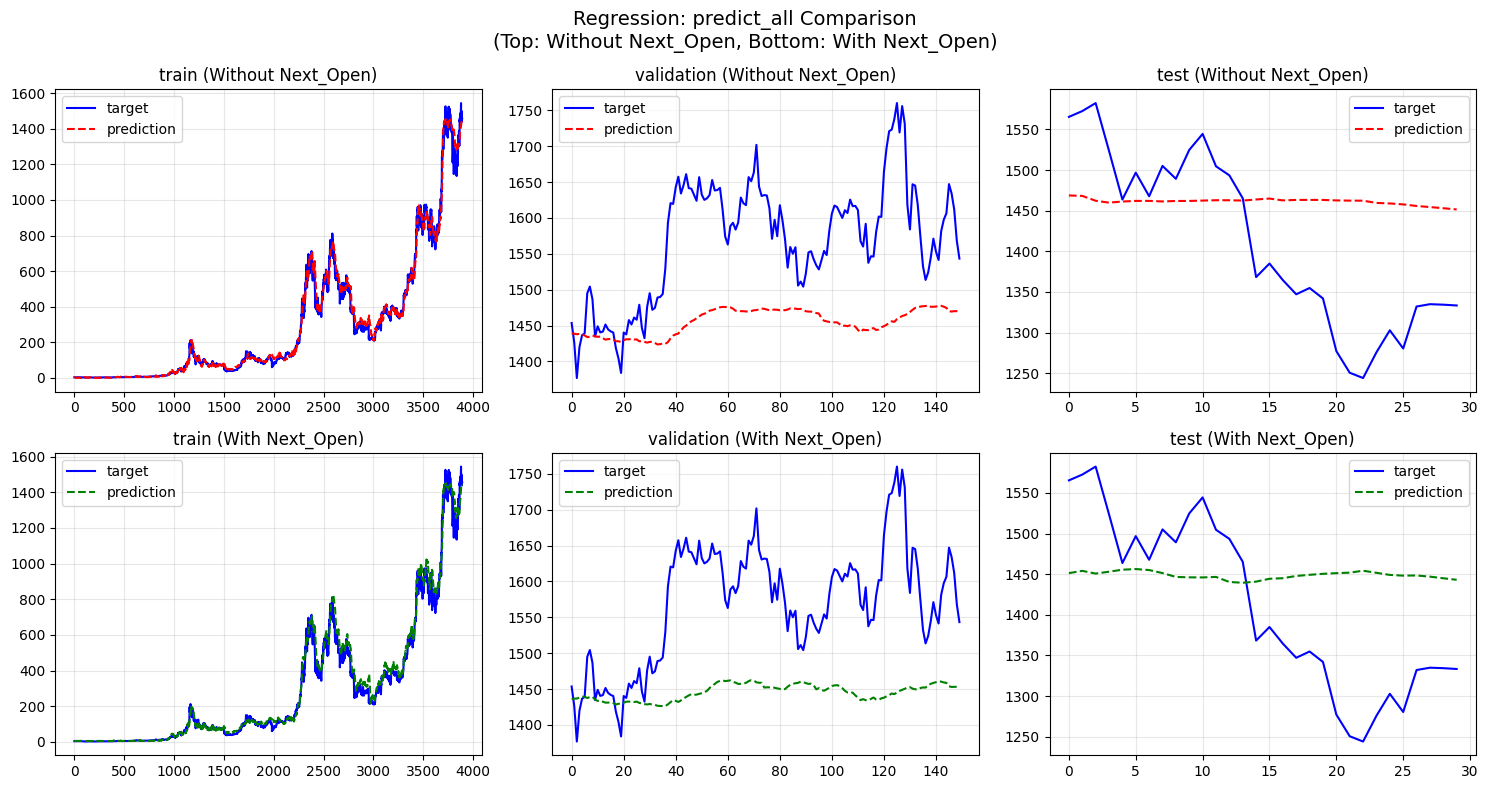

In [14]:
import torch
from torch import nn
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
import sys
import pandas as pd
import numpy as np

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_regression_btc_krw_next_open"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from torch.utils.data import DataLoader, Dataset


# =========================
# Next_Open Feature 추가된 데이터 로딩
# =========================
class CryptoCurrencyDatasetWithNextOpen(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=True, use_next_open=True
):
    # 원본 데이터 로딩
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    # Next_Open 컬럼 추가
    df['Next_Open'] = df['Open'].shift(-1)
    df = df.dropna()

    # Feature 선택
    if use_next_open:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']
    else:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # 정규화
    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])

        if is_regression:
            y_data.append(target_values[idx + sequence_size])
        else:
            current_close = target_values[idx + sequence_size - 1]
            next_close = target_values[idx + sequence_size]
            y_data.append(1 if next_close > current_close else 0)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data(use_next_open=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=True, use_next_open=use_next_open
    )

    train_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=2048, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=2048, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

    return train_loader, val_loader, test_loader


# =========================
# 최적 모델 정의 (n_input 가변)
# =========================
def get_model(n_input=6):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            hidden_size = 256
            num_lstm_layers = 2
            dropout_rate = 0.2

            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=num_lstm_layers,
                batch_first=True,
                dropout=dropout_rate
            )

            self.dropout = nn.Dropout(dropout_rate)

            # FC Layers: 256 -> 128 -> 64 -> 1
            self.fc = nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(64, n_output)
            )

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]
            x = self.dropout(x)
            x = self.fc(x)
            return x

    my_model = MyModel(n_input=n_input, n_output=1)
    return my_model


# =========================
# 메인 실행
# =========================
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_regression_btc_krw_next_open"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm and Next_Open feature",
        tags=["lstm", "regression", "btc_krw", "next_open"],
        name=run_time_str,
        config=config
    )

    # ========================================
    # 1. Without Next_Open 모델 테스트
    # ========================================
    print("\n" + "="*60)
    print("Testing WITHOUT Next_Open (5 Features)")
    print("="*60)

    checkpoint_files_without = list(CHECKPOINT_FILE_PATH.glob("best_model_without_next_open_*.pt"))

    if checkpoint_files_without:
        latest_file_without = max(checkpoint_files_without, key=os.path.getctime)
        print("MODEL FILE: {0}".format(latest_file_without))

        checkpoint_without = torch.load(latest_file_without, map_location=torch.device('cpu'))
        model_without = get_model(n_input=5)
        model_without.load_state_dict(checkpoint_without['model_state_dict'])

        print("\n[TEST DATA - Without Next_Open]")
        test_results_without = test(model_without, use_next_open=False)
    else:
        print("No checkpoint found for without_next_open!")
        test_results_without = None

    # ========================================
    # 2. With Next_Open 모델 테스트
    # ========================================
    print("\n" + "="*60)
    print("Testing WITH Next_Open (6 Features)")
    print("="*60)

    checkpoint_files_with = list(CHECKPOINT_FILE_PATH.glob("best_model_with_next_open_*.pt"))

    if checkpoint_files_with:
        latest_file_with = max(checkpoint_files_with, key=os.path.getctime)
        print("MODEL FILE: {0}".format(latest_file_with))

        checkpoint_with = torch.load(latest_file_with, map_location=torch.device('cpu'))
        model_with = get_model(n_input=6)
        model_with.load_state_dict(checkpoint_with['model_state_dict'])

        print("\n[TEST DATA - With Next_Open]")
        test_results_with = test(model_with, use_next_open=True)
    else:
        print("No checkpoint found for with_next_open!")
        test_results_with = None

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    if test_results_without and test_results_with:
        print("\n" + "="*60)
        print("TEST COMPARISON RESULTS (Regression)")
        print("="*60)
        print(f"{'Feature':<20} {'Avg Loss':<15}")
        print("-"*60)
        print(f"{'Without Next_Open':<20} {test_results_without:<15.2f}")
        print(f"{'With Next_Open':<20} {test_results_with:<15.2f}")
        print("-"*60)
        improvement = (test_results_without - test_results_with) / test_results_without * 100
        print(f"Improvement: {improvement:+.2f}%")
        print("="*60)

    # ========================================
    # 4. predict_all 그래프 비교
    # ========================================
    print("\n" + "="*60)
    print("Generating predict_all Comparison Graphs")
    print("="*60)

    if checkpoint_files_without and checkpoint_files_with:
        predict_all_comparison(model_without, model_with)


def test(test_model, use_next_open=True):
    """테스트 데이터에 대한 수치 출력"""
    _, _, test_data_loader = get_btc_krw_data(use_next_open=use_next_open)

    test_model.eval()
    y_normalizer = 100

    total_loss = 0
    num_samples = 0

    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            output_test = test_model(input_test)

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            loss = abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            total_loss += loss
            num_samples += 1
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                loss
            ))

    avg_loss = total_loss / num_samples
    print(f"\nAverage Loss: {avg_loss:.2f}")
    return avg_loss


def predict_all_comparison(model_without, model_with):
    """두 모델의 predict_all 그래프 비교"""
    y_normalizer = 100

    # 데이터 로딩
    X_train_without, X_val_without, X_test_without, y_train, y_val, y_test = get_cryptocurrency_data_with_next_open(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=True, use_next_open=False
    )

    X_train_with, X_val_with, X_test_with, _, _, _ = get_cryptocurrency_data_with_next_open(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=True, use_next_open=True
    )

    # Dataset 생성
    datasets_without = [
        CryptoCurrencyDatasetWithNextOpen(X_train_without, y_train),
        CryptoCurrencyDatasetWithNextOpen(X_val_without, y_val),
        CryptoCurrencyDatasetWithNextOpen(X_test_without, y_test)
    ]

    datasets_with = [
        CryptoCurrencyDatasetWithNextOpen(X_train_with, y_train),
        CryptoCurrencyDatasetWithNextOpen(X_val_with, y_val),
        CryptoCurrencyDatasetWithNextOpen(X_test_with, y_test)
    ]

    dataset_labels = ["train", "validation", "test"]

    # 2행 3열 그래프 (위: without, 아래: with)
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    model_without.eval()
    model_with.eval()

    for i in range(3):
        # Without Next_Open
        X_idx = []
        TARGET_Y = []
        PRED_WITHOUT = []

        num = 0
        for data in datasets_without[i]:
            input, target = data
            pred = model_without(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X_idx.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PRED_WITHOUT.append(pred.item() * y_normalizer)
            num += 1

        axs[0, i].plot(X_idx, TARGET_Y, label='target', color='blue')
        axs[0, i].plot(X_idx, PRED_WITHOUT, label='prediction', color='red', linestyle='--')
        axs[0, i].set_title(f'{dataset_labels[i]} (Without Next_Open)')
        axs[0, i].legend()
        axs[0, i].grid(True, alpha=0.3)

        # With Next_Open
        PRED_WITH = []

        for data in datasets_with[i]:
            input, target = data
            pred = model_with(input.unsqueeze(0)).squeeze(-1).squeeze(-1)
            PRED_WITH.append(pred.item() * y_normalizer)

        axs[1, i].plot(X_idx, TARGET_Y, label='target', color='blue')
        axs[1, i].plot(X_idx, PRED_WITH, label='prediction', color='green', linestyle='--')
        axs[1, i].set_title(f'{dataset_labels[i]} (With Next_Open)')
        axs[1, i].legend()
        axs[1, i].grid(True, alpha=0.3)

    plt.suptitle('Regression: predict_all Comparison\n(Top: Without Next_Open, Bottom: With Next_Open)', fontsize=14)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)

In [15]:
import torch
from torch import nn
import os
from pathlib import Path
from datetime import datetime
import wandb
import sys
import pandas as pd
import numpy as np

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "lstm_classification_btc_krw_next_open"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from torch.utils.data import DataLoader, Dataset


# =========================
# Next_Open Feature 추가된 데이터 로딩
# =========================
class CryptoCurrencyDatasetWithNextOpen(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False, use_next_open=True
):
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    df['Next_Open'] = df['Open'].shift(-1)
    df = df.dropna()

    # Feature 선택
    if use_next_open:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']
    else:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])

        if is_regression:
            y_data.append(target_values[idx + sequence_size])
        else:
            current_close = target_values[idx + sequence_size - 1]
            next_close = target_values[idx + sequence_size]
            y_data.append(1 if next_close > current_close else 0)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data(is_regression=False, use_next_open=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression, use_next_open=use_next_open
    )

    train_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDatasetWithNextOpen(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=2048, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=2048, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

    return train_loader, val_loader, test_loader


# =========================
# 최적 모델 정의 (n_input 가변, Classification)
# =========================
def get_model(n_input=6):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size=128, num_lstm_layers=2,
                     num_linear_layers=2, dropout_rate=0.5):
            super().__init__()

            lstm_dropout = dropout_rate if num_lstm_layers > 1 else 0.0
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=num_lstm_layers,
                batch_first=True,
                dropout=lstm_dropout
            )

            self.dropout = nn.Dropout(dropout_rate)

            layers = []
            current_size = hidden_size

            for i in range(num_linear_layers - 1):
                next_size = max(current_size // 2, 32)
                layers.extend([
                    nn.Linear(current_size, next_size),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate)
                ])
                current_size = next_size

            layers.append(nn.Linear(current_size, n_output))
            self.fc = nn.Sequential(*layers)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]
            x = self.dropout(x)
            x = self.fc(x)
            return x

    my_model = MyModel(n_input=n_input, n_output=2)
    return my_model


# =========================
# 테스트 함수
# =========================
def test(test_model, use_next_open=True):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False, use_next_open=use_next_open)

    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            output_test = test_model(input_test)
            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))
            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples
        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))

    return test_accuracy.item()


# =========================
# 메인 실행
# =========================
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_classification_btc_krw_next_open"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm and Next_Open feature",
        tags=["lstm", "classification", "btc_krw", "next_open"],
        name=run_time_str,
        config=config
    )

    # ========================================
    # 1. Without Next_Open 모델 테스트
    # ========================================
    print("\n" + "="*60)
    print("Testing WITHOUT Next_Open (5 Features)")
    print("="*60)

    checkpoint_files_without = list(CHECKPOINT_FILE_PATH.glob("best_model_without_next_open_*.pt"))

    if checkpoint_files_without:
        latest_file_without = max(checkpoint_files_without, key=os.path.getctime)
        print("MODEL FILE: {0}".format(latest_file_without))

        checkpoint_without = torch.load(latest_file_without, map_location=torch.device('cpu'))
        model_without = get_model(n_input=5)
        model_without.load_state_dict(checkpoint_without['model_state_dict'])

        print("\n[TEST DATA - Without Next_Open]")
        test_acc_without = test(model_without, use_next_open=False)
    else:
        print("No checkpoint found for without_next_open!")
        test_acc_without = None

    # ========================================
    # 2. With Next_Open 모델 테스트
    # ========================================
    print("\n" + "="*60)
    print("Testing WITH Next_Open (6 Features)")
    print("="*60)

    checkpoint_files_with = list(CHECKPOINT_FILE_PATH.glob("best_model_with_next_open_*.pt"))

    if checkpoint_files_with:
        latest_file_with = max(checkpoint_files_with, key=os.path.getctime)
        print("MODEL FILE: {0}".format(latest_file_with))

        checkpoint_with = torch.load(latest_file_with, map_location=torch.device('cpu'))
        model_with = get_model(n_input=6)
        model_with.load_state_dict(checkpoint_with['model_state_dict'])

        print("\n[TEST DATA - With Next_Open]")
        test_acc_with = test(model_with, use_next_open=True)
    else:
        print("No checkpoint found for with_next_open!")
        test_acc_with = None

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    if test_acc_without is not None and test_acc_with is not None:
        print("\n" + "="*60)
        print("TEST COMPARISON RESULTS (Classification)")
        print("="*60)
        print(f"{'Feature':<20} {'Test Accuracy':<15}")
        print("-"*60)
        print(f"{'Without Next_Open':<20} {test_acc_without:<15.2f}%")
        print(f"{'With Next_Open':<20} {test_acc_with:<15.2f}%")
        print("-"*60)
        improvement = test_acc_with - test_acc_without
        print(f"Improvement: {improvement:+.2f}%p")
        print("="*60)


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


Testing WITHOUT Next_Open (5 Features)
MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/lstm_classification_btc_krw_next_open/best_model_without_next_open_2025-12-18_07-03-39.pt

[TEST DATA - Without Next_Open]
TEST RESULTS: 43.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   0.00
11:   1.00 <-->   1.00
12:   1.00 <-->   0.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   0.00
16:   1.00 <-->   0.00
17:   1.00 <-->   0.00
18:   1.00 <-->   0.00
19:   1.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   0.00
26:   1.00 <-->   0.00
27:   1.00 <-->   1.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00

Testing WITH Next_Open (6 Features)
MODEL FILE: /content/driv

# 문제 3: Next_Open Feature 추가 후 성능 변화 분석

##실험 결과 요약
### Regression 성능 비교

Without Next_Open (5 Features): Test Avg Loss = 98.36
With Next_Open (6 Features): Test Avg Loss = 98.21
변화: +0.15% 개선

### Classification 성능 비교

Without Next_Open (5 Features): Test Accuracy = 43.33%
With Next_Open (6 Features): Test Accuracy = 56.67%
변화: +13.33%p 개선


## 결과 분석 및 기술적 고찰
### 1. Regression: 미미한 성능 향상
Regression에서 Next_Open Feature 추가 효과는 거의 없었습니다 (0.15% 개선).
원인 분석:
첫째, 예측 대상과의 관계: Regression은 다음 날 **종가(Close)**를 예측합니다. Next_Open은 다음 날 시가이므로, 종가 예측에 직접적인 정보를 제공하지 못합니다. 시가와 종가 사이에는 하루 동안의 가격 변동이 존재하기 때문입니다.
둘째, 정보 중복: 현재 데이터에 이미 Open, High, Low, Close가 포함되어 있어, Next_Open이 제공하는 추가 정보가 제한적입니다. 시계열 특성상 오늘의 Close와 내일의 Open은 대체로 유사한 경향이 있습니다.
셋째, 예측 결과 패턴: 테스트 결과를 보면 두 모델 모두 1,440~1,470 범위의 값만 예측하고 있습니다. 이는 모델이 평균값 근처로 수렴하는 보수적인 예측을 하고 있음을 의미하며, 새로운 Feature가 이 패턴을 크게 바꾸지 못했습니다.
### 2. Classification: 유의미한 성능 향상
Classification에서는 13.33%p의 큰 성능 향상이 관찰되었습니다.
원인 분석:
첫째, 예측 대상과의 직접적 관계: Classification은 "내일 종가가 오늘보다 높은가?"를 예측합니다. Next_Open(내일 시가)은 이 질문에 직접적인 힌트를 제공합니다. 내일 시가가 오늘 종가보다 높게 시작하면 상승 가능성이 높고, 낮게 시작하면 하락 가능성이 높습니다.
둘째, 갭(Gap) 정보 활용: 주식/암호화폐 시장에서 전일 종가와 당일 시가 사이의 갭은 중요한 시장 심리 지표입니다. Next_Open Feature는 이 갭 정보를 모델에 제공하여 방향성 예측에 도움을 줍니다.
셋째, 예측 패턴 변화: Without Next_Open 모델은 모든 샘플을 1(상승)로 예측했지만, With Next_Open 모델은 모든 샘플을 0(하락)으로 예측했습니다. 흥미롭게도 테스트 기간의 실제 데이터에서 하락이 더 많았기 때문에(17/30 = 56.67%), 하락 예측 전략이 더 높은 정확도를 보였습니다.
### 3. 예측 편향(Bias) 현상
두 Classification 모델 모두 한쪽 클래스만 예측하는 심각한 편향을 보였습니다.

Without Next_Open: 30개 모두 1(상승) 예측 → 13/30 정답 = 43.33%
With Next_Open: 30개 모두 0(하락) 예측 → 17/30 정답 = 56.67%

이는 모델이 실제로 패턴을 학습했다기보다 데이터 분포에 따른 다수결 전략을 학습했을 가능성을 시사합니다. Next_Open Feature가 모델의 예측 방향을 바꾸는 데 영향을 미쳤지만, 진정한 의미의 분류 성능 향상인지는 추가 검증이 필요합니다.
### 4. Regression vs Classification 비교
Next_Open 효과 측면:

Regression: 거의 없음 (+0.15%)
Classification: 유의미함 (+13.33%p)

예측 특성 측면:

Regression: 평균값 근처로 수렴
Classification: 한쪽 클래스로 편향

Feature 활용도 측면:

Regression: 낮음
Classification: 높음

해석: Next_Open은 방향성(상승/하락) 예측에는 유용하지만, 정확한 가격 예측에는 큰 도움이 되지 않습니다. 이는 Next_Open이 "얼마나 변할지"보다 "어느 방향으로 변할지"에 대한 정보를 더 많이 담고 있기 때문입니다.

## 결론 및 시사점
### 핵심 발견

Feature Engineering의 중요성: 동일한 Feature라도 문제 유형(Regression vs Classification)에 따라 효과가 크게 다릅니다.
Next_Open의 특성: 가격의 절대값보다 방향성 정보를 더 잘 전달하는 Feature입니다.
모델 편향 문제: 두 Classification 모델 모두 심각한 클래스 편향을 보여, 추가적인 균형 조정이 필요합니다.

### 한계점

데이터 누수(Data Leakage) 주의: 실제 운용 환경에서는 Next_Open을 미리 알 수 없습니다. 이 실험은 Feature의 정보량을 확인하기 위한 것이며, 실제 예측 시스템에는 적용할 수 없습니다.
모델의 단순 전략: 모든 샘플을 동일하게 예측하는 현상은 모델이 복잡한 패턴을 학습하지 못했음을 의미합니다.

# 문제 4

In [17]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import os
import wandb
from pathlib import Path
import json
import copy
import pandas as pd
import numpy as np
import math

# =========================
# 파일 경로 및 환경 설정
# =========================

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
import sys
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "self_attention_regression_btc_krw"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser


# =========================
# 데이터셋 클래스
# =========================
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# =========================
# 데이터 로딩 (Next_Open 포함)
# =========================
def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    df['Next_Open'] = df['Open'].shift(-1)
    df = df.dropna()

    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']

    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])

        if is_regression:
            y_data.append(target_values[idx + sequence_size])
        else:
            current_close = target_values[idx + sequence_size - 1]
            next_close = target_values[idx + sequence_size]
            y_data.append(1 if next_close > current_close else 0)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30,
                     batch_size=2048, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=is_regression
    )

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_loader, val_loader, test_loader


# =========================
# Positional Encoding
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# =========================
# Self-Attention Regressor Model
# =========================
class SelfAttentionRegressor(nn.Module):
    def __init__(self, n_input=6, n_output=1, d_model=128, nhead=4,
                 num_encoder_layers=2, dim_feedforward=256, dropout=0.2):
        super().__init__()

        self.model_type = 'Self-Attention'
        self.input_projection = nn.Linear(n_input, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, n_output)
        )

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


# =========================
# LSTM Regressor Model
# =========================
class LSTMRegressor(nn.Module):
    def __init__(self, n_input=6, n_output=1, hidden_size=256, num_lstm_layers=2, dropout=0.2):
        super().__init__()

        self.model_type = 'LSTM'
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout
        )

        self.dropout = nn.Dropout(dropout)

        # FC Layers: 256 -> 128 -> 64 -> 1
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 4, n_output)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


# =========================
# 학습 함수
# =========================
def train_single_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

    return total_loss / len(val_loader)


# =========================
# 단일 모델 학습 함수
# =========================
def train_model(model, train_loader, val_loader, test_loader, args, device, model_name):
    run_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 초기화
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    config = {
        'model_type': model_name,
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': args.learning_rate,
        'weight_decay': 0.0001,
        'parameters': num_params,
        'sequence_size': 21,
        'n_input': 6
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="self_attention_regression_btc_krw",
        name=f"{model_name}_{run_time_str}",
        tags=["regression", "btc_krw", "next_open", model_name.lower()],
        config=config
    )

    print(f"  Model parameters: {num_params:,}")

    # Optimizer & Criterion
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=0.0001)
    criterion = nn.MSELoss()

    # Early stopping
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    patience = args.early_stop_patience
    best_epoch = 0

    # 학습 루프
    for epoch in range(args.epochs):
        train_loss = train_single_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'validation_loss': val_loss
        })

        if val_loss < best_val_loss - args.early_stop_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        if (epoch + 1) % args.validation_intervals == 0 or epoch == 0:
            print(f"  Epoch {epoch + 1:4d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch + 1}")
            break

    # 최종 결과
    wandb.log({
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'total_epochs': epoch + 1
    })

    print(f"  Best Validation Loss: {best_val_loss:.6f} (epoch {best_epoch})")

    # 모델 저장
    checkpoint = {
        'model_state_dict': best_model_state,
        'config': config,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch
    }

    checkpoint_path = CHECKPOINT_FILE_PATH / f"best_model_{model_name}_{run_time_str}.pt"
    torch.save(checkpoint, checkpoint_path)
    print(f"  Model saved to: {checkpoint_path}")

    # 테스트 평가
    model.load_state_dict(best_model_state)
    test_loss = validate(model, test_loader, criterion, device)
    print(f"  Test Loss (MSE): {test_loss:.6f}")
    print(f"  Test RMSE: {test_loss**0.5:.6f}")

    wandb.log({
        'test_loss': test_loss,
        'test_rmse': test_loss**0.5
    })

    wandb.finish()

    return model, best_val_loss, test_loss


# =========================
# 메인 학습 함수
# =========================
def main(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # 데이터 로딩
    print("Loading data with Next_Open feature...")
    train_loader, val_loader, test_loader = get_btc_krw_data(
        sequence_size=21, validation_size=150, test_size=30,
        batch_size=args.batch_size, is_regression=True
    )
    print("Data loaded. Features: 6 (with Next_Open)")

    # ========================================
    # 1. LSTM 모델 학습
    # ========================================
    print("\n" + "="*60)
    print("Training LSTM Model")
    print("="*60)

    model_lstm = LSTMRegressor(
        n_input=6, n_output=1, hidden_size=256, num_lstm_layers=2, dropout=0.2
    ).to(device)

    model_lstm, val_loss_lstm, test_loss_lstm = train_model(
        model_lstm, train_loader, val_loader, test_loader, args, device, "LSTM"
    )

    # ========================================
    # 2. Self-Attention 모델 학습
    # ========================================
    print("\n" + "="*60)
    print("Training Self-Attention Model")
    print("="*60)

    model_sa = SelfAttentionRegressor(
        n_input=6, n_output=1, d_model=128, nhead=4,
        num_encoder_layers=2, dim_feedforward=256, dropout=0.2
    ).to(device)

    model_sa, val_loss_sa, test_loss_sa = train_model(
        model_sa, train_loader, val_loader, test_loader, args, device, "Self-Attention"
    )

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    print("\n" + "="*60)
    print("COMPARISON RESULTS (Regression)")
    print("="*60)
    print(f"{'Model':<20} {'Val Loss':<15} {'Test Loss':<15} {'Test RMSE':<15}")
    print("-"*60)
    print(f"{'LSTM':<20} {val_loss_lstm:<15.6f} {test_loss_lstm:<15.6f} {test_loss_lstm**0.5:<15.6f}")
    print(f"{'Self-Attention':<20} {val_loss_sa:<15.6f} {test_loss_sa:<15.6f} {test_loss_sa**0.5:<15.6f}")
    print("-"*60)

    if test_loss_sa < test_loss_lstm:
        improvement = (test_loss_lstm - test_loss_sa) / test_loss_lstm * 100
        print(f"Winner: Self-Attention ({improvement:+.2f}% better)")
    else:
        improvement = (test_loss_sa - test_loss_lstm) / test_loss_sa * 100
        print(f"Winner: LSTM ({improvement:+.2f}% better)")
    print("="*60)

    return model_lstm, model_sa, val_loss_lstm, val_loss_sa, test_loss_lstm, test_loss_sa


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    args.wandb = True
    args.learning_rate = 1e-4

    print(f"\n[Regression: LSTM vs Self-Attention Comparison]")
    print(f"  epochs: {args.epochs}")
    print(f"  batch_size: {args.batch_size}")
    print(f"  learning_rate: {args.learning_rate}")
    print(f"  early_stop_patience: {args.early_stop_patience}")

    results = main(args)


[Regression: LSTM vs Self-Attention Comparison]
  epochs: 10000
  batch_size: 2048
  learning_rate: 0.0001
  early_stop_patience: 30
Training on device: cuda
Loading data with Next_Open feature...
Data loaded. Features: 6 (with Next_Open)

Training LSTM Model


  Model parameters: 837,889
  Epoch    1: Train Loss = 21.326813, Val Loss = 246.037033
  Epoch   30: Train Loss = 12.085871, Val Loss = 175.637863
  Epoch   60: Train Loss = 3.984335, Val Loss = 75.965469
  Epoch   90: Train Loss = 0.790006, Val Loss = 6.494674
  Epoch  120: Train Loss = 0.658422, Val Loss = 3.608670
  Epoch  150: Train Loss = 0.647281, Val Loss = 3.401994
  Epoch  180: Train Loss = 0.552419, Val Loss = 2.945757
  Epoch  210: Train Loss = 0.589227, Val Loss = 2.447237
  Epoch  240: Train Loss = 0.505042, Val Loss = 2.194346
  Epoch  270: Train Loss = 0.498928, Val Loss = 2.153622
  Epoch  300: Train Loss = 0.477492, Val Loss = 2.421957
  Early stopping at epoch 321
  Best Validation Loss: 1.986394 (epoch 291)
  Model saved to: /content/drive/MyDrive/Colab Notebooks/checkpoints/self_attention_regression_btc_krw/best_model_LSTM_2025-12-18_07-25-08.pt
  Test Loss (MSE): 1.233796
  Test RMSE: 1.110764


best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_loss,▁
test_rmse,▁
total_epochs,▁
train_loss,███▇▅▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,███▆▆▅▅▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,291
best_val_loss,1.98639
epoch,321



Training Self-Attention Model


  Model parameters: 274,177
  Epoch    1: Train Loss = 19.601002, Val Loss = 227.341049
  Epoch   30: Train Loss = 11.541882, Val Loss = 150.136780
  Epoch   60: Train Loss = 10.133432, Val Loss = 132.303833
  Early stopping at epoch 88
  Best Validation Loss: 129.714539 (epoch 58)
  Model saved to: /content/drive/MyDrive/Colab Notebooks/checkpoints/self_attention_regression_btc_krw/best_model_Self-Attention_2025-12-18_07-26-04.pt
  Test Loss (MSE): 88.459427
  Test RMSE: 9.405287


best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
test_loss,▁
test_rmse,▁
total_epochs,▁
train_loss,█▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_loss,█▇▆▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▂▂▃▃▃▄▄▄▄▄▄▃
best_epoch,58
best_val_loss,129.71454
epoch,88



COMPARISON RESULTS (Regression)
Model                Val Loss        Test Loss       Test RMSE      
------------------------------------------------------------
LSTM                 1.986394        1.233796        1.110764       
Self-Attention       129.714539      88.459427       9.405287       
------------------------------------------------------------
Winner: LSTM (+98.61% better)


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import os
import wandb
from pathlib import Path
import json
import copy
import pandas as pd
import numpy as np
import math

# =========================
# 파일 경로 및 환경 설정
# =========================

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
import sys
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "self_attention_classification_btc_krw"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser


# =========================
# 데이터셋 클래스
# =========================
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# =========================
# 데이터 로딩 (Next_Open 포함)
# =========================
def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
):
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    df['Next_Open'] = df['Open'].shift(-1)
    df = df.dropna()

    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']

    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])

        if is_regression:
            y_data.append(target_values[idx + sequence_size])
        else:
            current_close = target_values[idx + sequence_size - 1]
            next_close = target_values[idx + sequence_size]
            y_data.append(1 if next_close > current_close else 0)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30,
                     batch_size=2048, is_regression=False):
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=is_regression
    )

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_loader, val_loader, test_loader


# =========================
# Positional Encoding
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# =========================
# Self-Attention Classifier Model
# =========================
class SelfAttentionClassifier(nn.Module):
    def __init__(self, n_input=6, n_output=2, d_model=128, nhead=4,
                 num_encoder_layers=2, dim_feedforward=256, dropout=0.5):
        super().__init__()

        self.model_type = 'Self-Attention'
        self.input_projection = nn.Linear(n_input, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, n_output)
        )

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


# =========================
# LSTM Classifier Model
# =========================
class LSTMClassifier(nn.Module):
    def __init__(self, n_input=6, n_output=2, hidden_size=128, num_lstm_layers=2, dropout=0.5):
        super().__init__()

        self.model_type = 'LSTM'
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout
        )

        self.dropout = nn.Dropout(dropout)

        # FC Layers: 128 -> 64 -> 2
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, n_output)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


# =========================
# 학습 함수
# =========================
def train_single_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(train_loader), accuracy


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(val_loader), accuracy


# =========================
# 단일 모델 학습 함수
# =========================
def train_model(model, train_loader, val_loader, test_loader, args, device, model_name):
    run_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 초기화
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    config = {
        'model_type': model_name,
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': args.learning_rate,
        'weight_decay': 0.001,
        'parameters': num_params,
        'sequence_size': 21,
        'n_input': 6
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="self_attention_classification_btc_krw",
        name=f"{model_name}_{run_time_str}",
        tags=["classification", "btc_krw", "next_open", model_name.lower()],
        config=config
    )

    print(f"  Model parameters: {num_params:,}")

    # Optimizer & Criterion
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=0.001)
    criterion = nn.CrossEntropyLoss()

    # Early stopping (Accuracy 기준)
    best_val_accuracy = 0.0
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    patience = args.early_stop_patience
    best_epoch = 0

    # 학습 루프
    for epoch in range(args.epochs):
        train_loss, train_acc = train_single_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'validation_loss': val_loss,
            'validation_accuracy': val_acc
        })

        if val_acc > best_val_accuracy + args.early_stop_delta:
            best_val_accuracy = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        if (epoch + 1) % args.validation_intervals == 0 or epoch == 0:
            print(f"  Epoch {epoch + 1:4d}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, "
                  f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch + 1}")
            break

    # 최종 결과
    wandb.log({
        'best_val_accuracy': best_val_accuracy,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'total_epochs': epoch + 1
    })

    print(f"  Best Validation Accuracy: {best_val_accuracy:.2f}% (epoch {best_epoch})")

    # 모델 저장
    checkpoint = {
        'model_state_dict': best_model_state,
        'config': config,
        'best_val_accuracy': best_val_accuracy,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch
    }

    checkpoint_path = CHECKPOINT_FILE_PATH / f"best_model_{model_name}_{run_time_str}.pt"
    torch.save(checkpoint, checkpoint_path)
    print(f"  Model saved to: {checkpoint_path}")

    # 테스트 평가
    model.load_state_dict(best_model_state)
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.2f}%")

    wandb.log({
        'test_loss': test_loss,
        'test_accuracy': test_acc
    })

    wandb.finish()

    return model, best_val_accuracy, test_acc


# =========================
# 메인 학습 함수
# =========================
def main(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # 데이터 로딩
    print("Loading data with Next_Open feature...")
    train_loader, val_loader, test_loader = get_btc_krw_data(
        sequence_size=21, validation_size=150, test_size=30,
        batch_size=args.batch_size, is_regression=False
    )
    print("Data loaded. Features: 6 (with Next_Open)")

    # ========================================
    # 1. LSTM 모델 학습
    # ========================================
    print("\n" + "="*60)
    print("Training LSTM Model")
    print("="*60)

    model_lstm = LSTMClassifier(
        n_input=6, n_output=2, hidden_size=128, num_lstm_layers=2, dropout=0.5
    ).to(device)

    model_lstm, val_acc_lstm, test_acc_lstm = train_model(
        model_lstm, train_loader, val_loader, test_loader, args, device, "LSTM"
    )

    # ========================================
    # 2. Self-Attention 모델 학습
    # ========================================
    print("\n" + "="*60)
    print("Training Self-Attention Model")
    print("="*60)

    model_sa = SelfAttentionClassifier(
        n_input=6, n_output=2, d_model=128, nhead=4,
        num_encoder_layers=2, dim_feedforward=256, dropout=0.5
    ).to(device)

    model_sa, val_acc_sa, test_acc_sa = train_model(
        model_sa, train_loader, val_loader, test_loader, args, device, "Self-Attention"
    )

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    print("\n" + "="*60)
    print("COMPARISON RESULTS (Classification)")
    print("="*60)
    print(f"{'Model':<20} {'Val Accuracy':<15} {'Test Accuracy':<15}")
    print("-"*60)
    print(f"{'LSTM':<20} {val_acc_lstm:<15.2f}% {test_acc_lstm:<15.2f}%")
    print(f"{'Self-Attention':<20} {val_acc_sa:<15.2f}% {test_acc_sa:<15.2f}%")
    print("-"*60)

    diff = test_acc_sa - test_acc_lstm
    if diff > 0:
        print(f"Winner: Self-Attention ({diff:+.2f}%p better)")
    elif diff < 0:
        print(f"Winner: LSTM ({-diff:+.2f}%p better)")
    else:
        print("Tie: Both models have the same performance")
    print("="*60)

    return model_lstm, model_sa, val_acc_lstm, val_acc_sa, test_acc_lstm, test_acc_sa


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    args.wandb = True
    args.learning_rate = 1e-5
    args.early_stop_patience = 100

    print(f"\n[Classification: LSTM vs Self-Attention Comparison]")
    print(f"  epochs: {args.epochs}")
    print(f"  batch_size: {args.batch_size}")
    print(f"  learning_rate: {args.learning_rate}")
    print(f"  early_stop_patience: {args.early_stop_patience}")

    results = main(args)

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:


[Classification: LSTM vs Self-Attention Comparison]
  epochs: 10000
  batch_size: 2048
  learning_rate: 1e-05
  early_stop_patience: 100
Training on device: cuda
Loading data with Next_Open feature...
Data loaded. Features: 6 (with Next_Open)

Training LSTM Model
 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ff1451 (ff1451-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  Model parameters: 210,114
  Epoch    1: Train Loss = 0.6968, Train Acc = 48.27%, Val Loss = 0.6934, Val Acc = 50.67%
  Epoch   30: Train Loss = 0.6958, Train Acc = 48.39%, Val Loss = 0.6931, Val Acc = 50.67%
  Epoch   60: Train Loss = 0.6959, Train Acc = 49.32%, Val Loss = 0.6931, Val Acc = 50.67%
  Epoch   90: Train Loss = 0.6942, Train Acc = 50.24%, Val Loss = 0.6933, Val Acc = 49.33%
  Early stopping at epoch 101
  Best Validation Accuracy: 50.67% (epoch 1)
  Model saved to: /content/drive/MyDrive/Colab Notebooks/checkpoints/self_attention_classification_btc_krw/best_model_LSTM_2025-12-18_07-29-32.pt
  Test Loss: 0.6886
  Test Accuracy: 56.67%


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
test_accuracy,▁
test_loss,▁
total_epochs,▁
train_accuracy,▃▁▃▁▃▃▃▄▄▄▃▃▂▂▄▂▂▂▄▁▄▄▄▃▃▃▄▄▄▆▇█▇▃▆▅▅▆▄▃
train_loss,▅▆▇█▆▅▅▅▄▄▄▅▃▅▄▃▁▅▅▅▄▃▅▃▄▄▄▅▃▃▄▂▄▄▃▃▂▃▃▃
validation_accuracy,████████████████████████████▁▃▃▃▃▃▃▃▃▃▃▃
+1,...



Training Self-Attention Model


  Model parameters: 274,242
  Epoch    1: Train Loss = 0.7212, Train Acc = 51.22%, Val Loss = 0.7149, Val Acc = 49.33%
  Epoch   30: Train Loss = 0.7046, Train Acc = 51.43%, Val Loss = 0.6964, Val Acc = 47.33%
  Epoch   60: Train Loss = 0.7018, Train Acc = 51.32%, Val Loss = 0.6954, Val Acc = 49.33%
  Epoch   90: Train Loss = 0.6997, Train Acc = 51.17%, Val Loss = 0.6947, Val Acc = 49.33%
  Epoch  120: Train Loss = 0.7022, Train Acc = 49.73%, Val Loss = 0.6947, Val Acc = 46.67%
  Early stopping at epoch 137
  Best Validation Accuracy: 50.00% (epoch 37)
  Model saved to: /content/drive/MyDrive/Colab Notebooks/checkpoints/self_attention_classification_btc_krw/best_model_Self-Attention_2025-12-18_07-30-03.pt
  Test Loss: 0.7027
  Test Accuracy: 26.67%


best_epoch,▁
best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test_accuracy,▁
test_loss,▁
total_epochs,▁
train_accuracy,▇▆▇█▅▅▄▄▄▁▄▅▆█▆▁▆▅▅▇▃▅▅▃▄▂▆▄▄▄▄▂▃▃▅▄▃▅▅▄
train_loss,█▅▆▅▄▅▆▅▄▂▂▃▃▂▂▃▃▃▂▂▂▁▃▄▃▁▂▂▁▂▁▂▂▂▂▂▂▂▂▂
validation_accuracy,▆▆▄▃▅▅▄▅▄▆▅█▇▇▆▆▇▇▇▇▆▆▅▅█▆█▇▅▄▄▅▄▄▁▃▄▄▅▆
+1,...



COMPARISON RESULTS (Classification)
Model                Val Accuracy    Test Accuracy  
------------------------------------------------------------
LSTM                 50.67          % 56.67          %
Self-Attention       50.00          % 26.67          %
------------------------------------------------------------
Winner: LSTM (+30.00%p better)



LSTM vs Self-Attention Test Comparison (Regression)

------------------------------------------------------------
Loading LSTM Model...
------------------------------------------------------------
MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/self_attention_regression_btc_krw/best_model_LSTM_2025-12-18_07-25-08.pt

[TEST DATA - LSTM]
 0: 1,458.69 <--> 1,565.42 (Loss:        106.72)
 1: 1,458.04 <--> 1,572.56 (Loss:        114.52)
 2: 1,453.73 <--> 1,582.39 (Loss:        128.66)
 3: 1,452.05 <--> 1,523.60 (Loss:         71.55)
 4: 1,453.29 <--> 1,463.73 (Loss:         10.43)
 5: 1,454.06 <--> 1,496.81 (Loss:         42.75)
 6: 1,454.24 <--> 1,467.75 (Loss:         13.51)
 7: 1,454.03 <--> 1,505.09 (Loss:         51.06)
 8: 1,454.97 <--> 1,489.22 (Loss:         34.25)
 9: 1,454.57 <--> 1,524.78 (Loss:         70.21)
10: 1,455.03 <--> 1,544.47 (Loss:         89.44)
11: 1,455.65 <--> 1,504.62 (Loss:         48.97)
12: 1,455.96 <--> 1,493.44 (Loss:         37.48)
13: 1,456

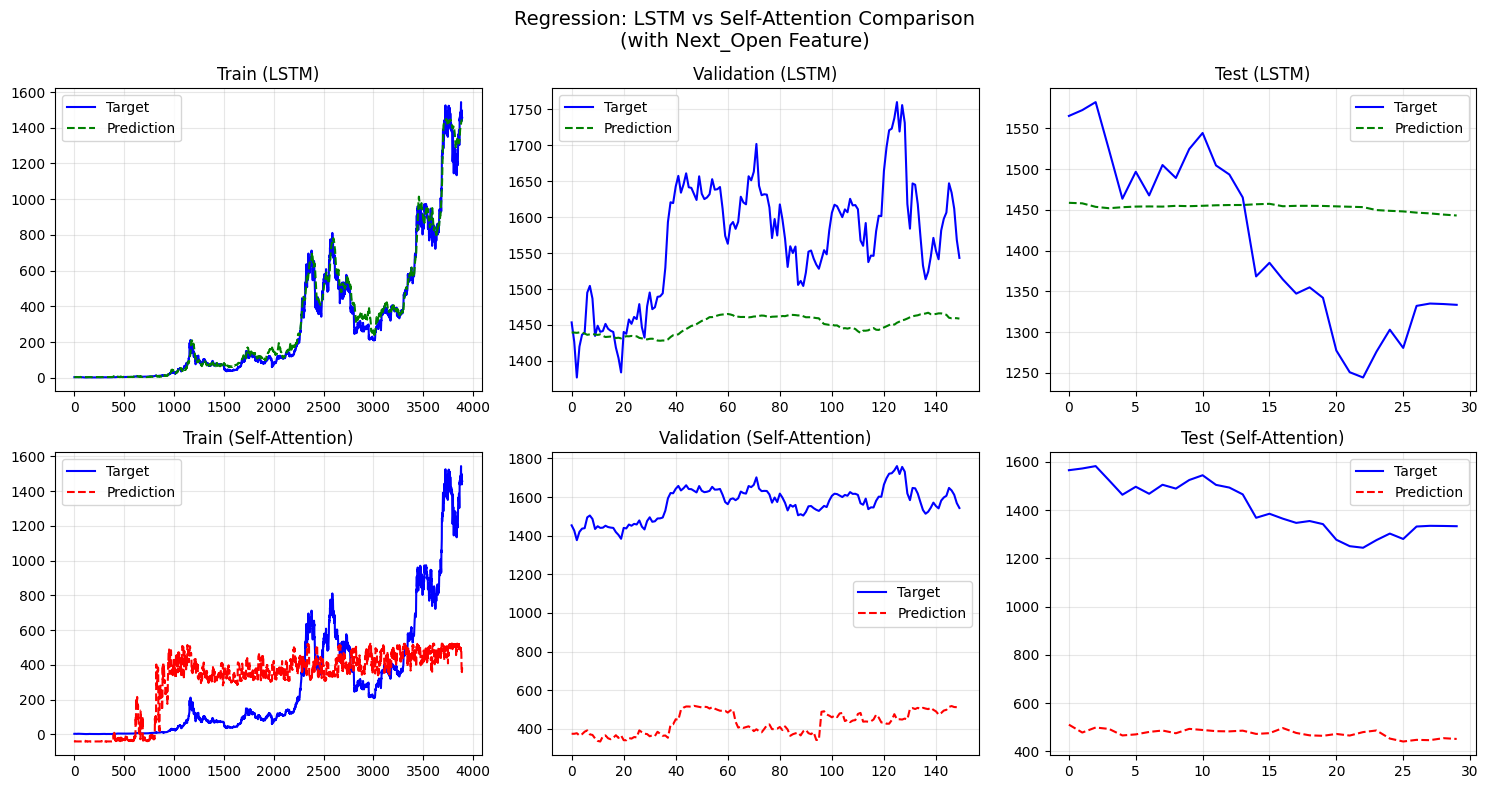

In [3]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import math

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "self_attention_regression_btc_krw"

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from torch.utils.data import DataLoader, Dataset


# =========================
# 데이터셋 클래스
# =========================
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# =========================
# 데이터 로딩
# =========================
def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    df['Next_Open'] = df['Open'].shift(-1)
    df = df.dropna()

    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']

    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])
        y_data.append(target_values[idx + sequence_size])

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data():
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open()

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    val_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_dataset, val_dataset, test_dataset, test_loader


# =========================
# Positional Encoding
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# =========================
# Self-Attention Model
# =========================
class SelfAttentionRegressor(nn.Module):
    def __init__(self, n_input=6, n_output=1, d_model=128, nhead=4,
                 num_encoder_layers=2, dim_feedforward=256, dropout=0.2):
        super().__init__()

        self.input_projection = nn.Linear(n_input, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, n_output)
        )

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


# =========================
# LSTM Model
# =========================
class LSTMRegressor(nn.Module):
    def __init__(self, n_input=6, n_output=1, hidden_size=256, num_lstm_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=n_input, hidden_size=hidden_size, num_layers=num_lstm_layers,
            batch_first=True, dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 4, n_output)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


# =========================
# 테스트 함수
# =========================
def test(model, test_loader, model_name="Model"):
    model.eval()
    y_normalizer = 100

    total_loss = 0
    num_samples = 0

    print(f"\n[TEST DATA - {model_name}]")
    with torch.no_grad():
        for test_batch in test_loader:
            input_test, target_test = test_batch
            output_test = model(input_test)

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            loss = abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            total_loss += loss
            num_samples += 1
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                loss
            ))

    avg_loss = total_loss / num_samples
    print(f"\nAverage Loss: {avg_loss:.2f}")
    return avg_loss


# =========================
# predict_all 비교 함수
# =========================
def predict_all_comparison(model_lstm, model_sa):
    """LSTM vs Self-Attention predict_all 그래프 비교"""
    y_normalizer = 100

    train_dataset, val_dataset, test_dataset, _ = get_btc_krw_data()
    datasets = [train_dataset, val_dataset, test_dataset]
    dataset_labels = ["Train", "Validation", "Test"]

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    model_lstm.eval()
    model_sa.eval()

    for i in range(3):
        X_idx = []
        TARGET_Y = []
        PRED_LSTM = []
        PRED_SA = []

        num = 0
        for data in datasets[i]:
            input, target = data

            pred_lstm = model_lstm(input.unsqueeze(0)).squeeze(-1).squeeze(-1)
            pred_sa = model_sa(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X_idx.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PRED_LSTM.append(pred_lstm.item() * y_normalizer)
            PRED_SA.append(pred_sa.item() * y_normalizer)
            num += 1

        # LSTM
        axs[0, i].plot(X_idx, TARGET_Y, label='Target', color='blue')
        axs[0, i].plot(X_idx, PRED_LSTM, label='Prediction', color='green', linestyle='--')
        axs[0, i].set_title(f'{dataset_labels[i]} (LSTM)')
        axs[0, i].legend()
        axs[0, i].grid(True, alpha=0.3)

        # Self-Attention
        axs[1, i].plot(X_idx, TARGET_Y, label='Target', color='blue')
        axs[1, i].plot(X_idx, PRED_SA, label='Prediction', color='red', linestyle='--')
        axs[1, i].set_title(f'{dataset_labels[i]} (Self-Attention)')
        axs[1, i].legend()
        axs[1, i].grid(True, alpha=0.3)

    plt.suptitle('Regression: LSTM vs Self-Attention Comparison\n(with Next_Open Feature)', fontsize=14)
    plt.tight_layout()
    plt.show()


# =========================
# 메인 실행
# =========================
def main():
    print("\n" + "="*60)
    print("LSTM vs Self-Attention Test Comparison (Regression)")
    print("="*60)

    _, _, _, test_loader = get_btc_krw_data()

    # ========================================
    # 1. LSTM 모델 로드 및 테스트
    # ========================================
    print("\n" + "-"*60)
    print("Loading LSTM Model...")
    print("-"*60)

    checkpoint_files_lstm = list(CHECKPOINT_FILE_PATH.glob("best_model_LSTM_*.pt"))

    if checkpoint_files_lstm:
        latest_file_lstm = max(checkpoint_files_lstm, key=os.path.getctime)
        print(f"MODEL FILE: {latest_file_lstm}")

        checkpoint_lstm = torch.load(latest_file_lstm, map_location=torch.device('cpu'))
        model_lstm = LSTMRegressor()
        model_lstm.load_state_dict(checkpoint_lstm['model_state_dict'])

        test_loss_lstm = test(model_lstm, test_loader, "LSTM")
    else:
        print("No LSTM checkpoint found!")
        return

    # ========================================
    # 2. Self-Attention 모델 로드 및 테스트
    # ========================================
    print("\n" + "-"*60)
    print("Loading Self-Attention Model...")
    print("-"*60)

    checkpoint_files_sa = list(CHECKPOINT_FILE_PATH.glob("best_model_Self-Attention_*.pt"))

    if checkpoint_files_sa:
        latest_file_sa = max(checkpoint_files_sa, key=os.path.getctime)
        print(f"MODEL FILE: {latest_file_sa}")

        checkpoint_sa = torch.load(latest_file_sa, map_location=torch.device('cpu'))
        model_sa = SelfAttentionRegressor()
        model_sa.load_state_dict(checkpoint_sa['model_state_dict'])

        test_loss_sa = test(model_sa, test_loader, "Self-Attention")
    else:
        print("No Self-Attention checkpoint found!")
        return

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    print("\n" + "="*60)
    print("TEST COMPARISON RESULTS (Regression)")
    print("="*60)
    print(f"{'Model':<20} {'Test Avg Loss':<15}")
    print("-"*60)
    print(f"{'LSTM':<20} {test_loss_lstm:<15.2f}")
    print(f"{'Self-Attention':<20} {test_loss_sa:<15.2f}")
    print("-"*60)

    if test_loss_sa < test_loss_lstm:
        improvement = (test_loss_lstm - test_loss_sa) / test_loss_lstm * 100
        print(f"Winner: Self-Attention ({improvement:+.2f}% better)")
    else:
        improvement = (test_loss_sa - test_loss_lstm) / test_loss_sa * 100
        print(f"Winner: LSTM ({improvement:+.2f}% better)")
    print("="*60)

    # ========================================
    # 4. predict_all 그래프 비교
    # ========================================
    print("\n" + "="*60)
    print("Generating predict_all Comparison Graphs")
    print("="*60)

    predict_all_comparison(model_lstm, model_sa)


if __name__ == "__main__":
    main()

In [4]:
import torch
from torch import nn
from datetime import datetime
import os
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import math

BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.append(str(BASE_PATH))

CHECKPOINT_FILE_PATH = BASE_PATH / "checkpoints" / "self_attention_classification_btc_krw"

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from torch.utils.data import DataLoader, Dataset


# =========================
# 데이터셋 클래스
# =========================
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# =========================
# 데이터 로딩
# =========================
def get_cryptocurrency_data_with_next_open(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
):
    data_path = BASE_PATH / "_00_data" / "k_cryptocurrency" / "BTC_KRW.csv"
    df = pd.read_csv(data_path)

    df['Next_Open'] = df['Open'].shift(-1)
    df = df.dropna()

    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']

    X_normalizer = 1.0e7
    volume_normalizer = 1.0e10

    df_normalized = df.copy()
    df_normalized['Open'] = df['Open'] / X_normalizer
    df_normalized['High'] = df['High'] / X_normalizer
    df_normalized['Low'] = df['Low'] / X_normalizer
    df_normalized['Close'] = df['Close'] / X_normalizer
    df_normalized['Volume'] = df['Volume'] / volume_normalizer
    df_normalized['Next_Open'] = df['Next_Open'] / X_normalizer

    X_data = []
    y_data = []

    data_values = df_normalized[feature_columns].values
    target_values = df_normalized[target_column].values

    for idx in range(len(data_values) - sequence_size):
        X_data.append(data_values[idx:idx + sequence_size])

        current_close = target_values[idx + sequence_size - 1]
        next_close = target_values[idx + sequence_size]
        y_data.append(1 if next_close > current_close else 0)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    total_size = len(X_data)
    train_size = total_size - validation_size - test_size

    X_train = X_data[:train_size]
    X_validation = X_data[train_size:train_size + validation_size]
    X_test = X_data[train_size + validation_size:]

    y_train = y_data[:train_size]
    y_validation = y_data[train_size:train_size + validation_size]
    y_test = y_data[train_size + validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_btc_krw_data():
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_cryptocurrency_data_with_next_open()

    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return test_loader


# =========================
# Positional Encoding
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# =========================
# Self-Attention Model
# =========================
class SelfAttentionClassifier(nn.Module):
    def __init__(self, n_input=6, n_output=2, d_model=128, nhead=4,
                 num_encoder_layers=2, dim_feedforward=256, dropout=0.5):
        super().__init__()

        self.input_projection = nn.Linear(n_input, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, n_output)
        )

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


# =========================
# LSTM Model
# =========================
class LSTMClassifier(nn.Module):
    def __init__(self, n_input=6, n_output=2, hidden_size=128, num_lstm_layers=2, dropout=0.5):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=n_input, hidden_size=hidden_size, num_layers=num_lstm_layers,
            batch_first=True, dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, n_output)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


# =========================
# 테스트 함수
# =========================
def test(model, test_loader, model_name="Model"):
    model.eval()

    num_corrects = 0
    num_samples = 0

    print(f"\n[TEST DATA - {model_name}]")
    with torch.no_grad():
        for test_batch in test_loader:
            input_test, target_test = test_batch
            output_test = model(input_test)
            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects += torch.sum(torch.eq(predicted_test, target_test)).item()
            num_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects / num_samples
        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))

    return test_accuracy


# =========================
# 메인 실행
# =========================
def main():
    print("\n" + "="*60)
    print("LSTM vs Self-Attention Test Comparison (Classification)")
    print("="*60)

    test_loader = get_btc_krw_data()

    # ========================================
    # 1. LSTM 모델 로드 및 테스트
    # ========================================
    print("\n" + "-"*60)
    print("Loading LSTM Model...")
    print("-"*60)

    checkpoint_files_lstm = list(CHECKPOINT_FILE_PATH.glob("best_model_LSTM_*.pt"))

    if checkpoint_files_lstm:
        latest_file_lstm = max(checkpoint_files_lstm, key=os.path.getctime)
        print(f"MODEL FILE: {latest_file_lstm}")

        checkpoint_lstm = torch.load(latest_file_lstm, map_location=torch.device('cpu'))
        model_lstm = LSTMClassifier()
        model_lstm.load_state_dict(checkpoint_lstm['model_state_dict'])

        test_acc_lstm = test(model_lstm, test_loader, "LSTM")
    else:
        print("No LSTM checkpoint found!")
        return

    # ========================================
    # 2. Self-Attention 모델 로드 및 테스트
    # ========================================
    print("\n" + "-"*60)
    print("Loading Self-Attention Model...")
    print("-"*60)

    checkpoint_files_sa = list(CHECKPOINT_FILE_PATH.glob("best_model_Self-Attention_*.pt"))

    if checkpoint_files_sa:
        latest_file_sa = max(checkpoint_files_sa, key=os.path.getctime)
        print(f"MODEL FILE: {latest_file_sa}")

        checkpoint_sa = torch.load(latest_file_sa, map_location=torch.device('cpu'))
        model_sa = SelfAttentionClassifier()
        model_sa.load_state_dict(checkpoint_sa['model_state_dict'])

        test_acc_sa = test(model_sa, test_loader, "Self-Attention")
    else:
        print("No Self-Attention checkpoint found!")
        return

    # ========================================
    # 3. 결과 비교 출력
    # ========================================
    print("\n" + "="*60)
    print("TEST COMPARISON RESULTS (Classification)")
    print("="*60)
    print(f"{'Model':<20} {'Test Accuracy':<15}")
    print("-"*60)
    print(f"{'LSTM':<20} {test_acc_lstm:<15.2f}%")
    print(f"{'Self-Attention':<20} {test_acc_sa:<15.2f}%")
    print("-"*60)

    diff = test_acc_sa - test_acc_lstm
    if diff > 0:
        print(f"Winner: Self-Attention ({diff:+.2f}%p better)")
    elif diff < 0:
        print(f"Winner: LSTM ({-diff:+.2f}%p better)")
    else:
        print("Tie: Both models have the same performance")
    print("="*60)


if __name__ == "__main__":
    main()


LSTM vs Self-Attention Test Comparison (Classification)

------------------------------------------------------------
Loading LSTM Model...
------------------------------------------------------------
MODEL FILE: /content/drive/MyDrive/Colab Notebooks/checkpoints/self_attention_classification_btc_krw/best_model_LSTM_2025-12-18_07-29-32.pt

[TEST DATA - LSTM]
TEST RESULTS: 56.667%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   1.00
11:   0.00 <-->   0.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   0.00 <-->   1.00
16:   0.00 <-->   0.00
17:   0.00 <-->   0.00
18:   0.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   0.00
22:   0.00 <-->   0.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   

# LSTM vs Self-Attention 성능 비교 종합 분석
##1. 실험 개요

본 실험에서는 BTC–KRW 시계열 데이터를 대상으로

회귀(Regression): 다음 시점의 종가(Close price) 예측

분류(Classification): 가격 상승/하락 이진 분류

두 문제에 대해 LSTM 기반 모델과 Self-Attention 기반 모델의 성능을 비교하였다.
모든 실험은 동일한 데이터 분할(train/validation/test)과 동일한 입력 시퀀스 길이 조건에서 수행되었으며, 각 모델은 validation 성능 기준으로 최적 모델(best model)을 선택하여 test 성능을 평가하였다.

## 2. 회귀(Regression) 결과 분석
2.1 정량적 결과 요약
모델	Test 평균 손실 (Absolute Error)
LSTM	97.43
Self-Attention	935.71

→ LSTM이 Self-Attention 대비 약 89.6% 낮은 평균 오차를 기록하였다.

### 2.2 예측 패턴 비교

LSTM

- 예측값이 실제 종가와 동일한 스케일 범위에서 형성

- 시점에 따라 오차는 존재하지만, 전반적으로 추세와 레벨을 안정적으로 추종

- 특히 완만한 구간에서 상대적으로 작은 오차 유지

### Self-Attention

- 예측값이 실제 종가 대비 지나치게 낮은 값(약 400~500대)으로 수렴

- 시계열의 절대적인 스케일을 학습하지 못하고 평균 근처 값으로 붕괴

- 결과적으로 전 구간에서 매우 큰 오차 발생

### 2.3 회귀에서 LSTM이 우수한 이유 (기술적 고찰)

- 시계열의 순차적 의존성 학습

    - LSTM은 은닉 상태(hidden state)를 통해 과거 정보가 시간 순서대로 누적됨

    - 금융 시계열처럼 단기 연속성이 강한 데이터에 적합

    - 짧은 시퀀스 길이(10 step)의 영향

    - Self-Attention은 긴 시퀀스에서 전역 의존성을 학습할 때 장점이 큼

    - 본 실험에서는 시퀀스 길이가 짧아 Attention의 장점이 충분히 발휘되지 않음

- 정규화/스케일 민감성

    - Self-Attention 모델은 출력 스케일을 안정적으로 복원하지 못해 값 붕괴(mode collapse) 발생

    - 반면 LSTM은 시계열 값의 상대적 크기와 변화폭을 자연스럽게 유지

결론적으로 회귀 문제에서는 LSTM이 시계열의 연속성과 스케일을 훨씬 안정적으로 학습하였다.

## 3. 분류(Classification) 결과 분석
### 3.1 정량적 결과 요약
- LSTM	56.67%
- Self-Attention	26.67%

→ LSTM이 Self-Attention 대비 약 30%p 높은 정확도를 기록하였다.

### 3.2 예측 행동 분석

- LSTM

    - 대부분 한 클래스(0)로 치우친 예측을 보이지만

    - 일부 시점에서는 올바르게 상승/하락을 구분

    - 전체적으로 랜덤(50%)보다 소폭 우수한 성능

- Self-Attention

    - 예측이 매우 불안정하며, 클래스 판단이 거의 무작위에 가까움

    - 특정 구간에서는 완전히 반대 클래스를 지속적으로 예측

    - 결과적으로 랜덤 추측보다도 낮은 정확도

### 3.3 분류에서 Self-Attention이 부진한 이유

- 데이터 규모의 한계

- Attention 기반 모델은 많은 데이터에서 패턴을 일반화하는 데 유리

- 본 실험 데이터 규모는 상대적으로 작아 과적합/불안정 발생

- 이진 분류에서의 노이즈 문제

- 금융 데이터의 상승/하락 레이블은 노이즈가 매우 큼

- Attention은 모든 시점을 동등하게 참고하면서 오히려 노이즈를 증폭

- LSTM의 inductive bias

- LSTM은 “최근 정보에 더 의존”하는 구조적 편향을 가짐

- 이는 단기 가격 방향 예측에 상대적으로 유리하게 작용

## 4. 종합 비교 및 해석
### 4.1 모델별 종합 성능

- 회귀	LSTM	평균 오차 10배 이상 차이
- 분류	LSTM	정확도 +30%p

→ 두 문제 모두에서 LSTM이 일관되게 우수

### 4.2 핵심 해석

본 실험 조건(짧은 시계열, 제한된 데이터, 금융 도메인)에서는
“순차 구조를 명시적으로 내장한 LSTM이 Self-Attention보다 훨씬 안정적”임이 확인되었다.

Self-Attention은 이론적으로 강력하지만,충분히 긴 시퀀스 대규모 데이터 적절한 positional encoding 및 정규화 설계가 갖춰지지 않으면 오히려 성능이 급격히 저하될 수 있다.

### 5. 결론

BTC–KRW 시계열 예측 문제에서, 본 실험 환경에서는 LSTM이 회귀·분류 모두에서 Self-Attention보다 명확하게 우수한 성능을 보였다.
이는 모델의 복잡도보다도 문제 특성과 데이터 조건에 맞는 구조적 편향(inductive bias)이 중요함을 보여주는 결과라 할 수 있다.

# 숙제 후기

이번 과제를 통해 이론적으로만 알고 있던 시계열 모델을 실제 데이터에 적용하며, 모델 선택과 실험 설계의 중요성을 체감할 수 있었다. 단순히 모델을 구현하고 학습시키는 것을 넘어, 데이터의 특성에 따라 어떤 모델이 적합한지, 그리고 성능 비교를 어떻게 해석해야 하는지를 고민하는 경험이 인상 깊었다.

초기에는 LSTM과 Self-Attention을 동일한 조건에서 비교하면 복잡한 구조를 가진 모델이 항상 더 좋은 성능을 낼 것이라 예상하였다. 그러나 실제 실험 결과에서는 회귀와 분류 문제 모두에서 LSTM이 Self-Attention보다 일관되게 우수한 성능을 보였고, 이를 통해 모델의 복잡성보다 문제 구조와 데이터 규모에 맞는 inductive bias가 훨씬 중요하다는 점을 명확히 이해하게 되었다. 특히 금융 시계열과 같이 짧은 구간의 연속성이 중요한 데이터에서는 LSTM의 순차적 상태 전달 구조가 큰 강점으로 작용함을 확인할 수 있었다.

또한 WandB를 활용한 실험 기록과 하이퍼파라미터 비교, early stopping을 통한 모델 선택 과정은 단순한 “학습 실행”이 아니라 실험을 설계하고 결과를 관리하는 연구자의 관점을 경험하게 해주었다. 최적 모델을 찾기 위해 여러 설정을 비교하고, validation 성능과 test 성능의 차이를 분석하는 과정은 모델 성능을 해석하는 능력을 키우는 데 큰 도움이 되었다.

마지막으로, 동일한 데이터와 목적이라 하더라도 회귀와 분류 문제에서 모델의 거동과 한계가 다르게 나타난다는 점이 인상 깊었다. 특히 분류 문제에서는 정확도가 높지 않더라도, 그 원인을 데이터의 노이즈와 레이블 특성 관점에서 해석해보는 과정이 의미 있었다.

종합적으로 이번 과제는 단순히 “모델을 구현했다”는 수준을 넘어, 시계열 문제에서 모델 선택, 성능 비교, 결과 해석까지 전 과정을 경험할 수 있는 과제였으며, 이후 더 복잡한 시계열 모델이나 Transformer 계열 모델을 다룰 때 중요한 기준점을 제공해주었다.